In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import torch.utils.data as Data
from torch.utils.data import DataLoader
from torch.optim import Adam
import numpy as np
import math
from sklearn.decomposition import NMF
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from numpy import linalg as LA
from scipy.stats import pearsonr
import random

from dataset import PDFDataset
# from ae import AE
# from deepae import DEEPAE
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.ticker import MaxNLocator

import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

## Load physical components of the defects

In [2]:
data_def = np.loadtxt('ana.unfit',delimiter=' ', dtype=float)
data_def = data_def[:,1]
data_def = (data_def-min(data_def))/(max(data_def)-min(data_def))

d1 = np.loadtxt('ana.unfit',delimiter=' ', dtype=float)
d2 = np.loadtxt('tivac.dummy.40.unfit',delimiter=' ', dtype=float)
d3 = np.loadtxt('tii.dummy.40.unfit',delimiter=' ', dtype=float)
d4 = np.loadtxt('oi.dummy.40.unfit',delimiter=' ', dtype=float)
d5 = np.loadtxt('vo.dummy.40.unfit',delimiter=' ', dtype=float)
d1 = d1[:,1]
d2 = d2[:,1]
d3 = d3[:,1]
d4 = d4[:,1]
d5 = d5[:,1]


d1 = (d1-min(d1))/(max(d1)-min(d1))
d2 = (d2-min(d2))/(max(d2)-min(d2))
d3 = (d3-min(d3))/(max(d3)-min(d3))
d4 = (d4-min(d4))/(max(d4)-min(d4))
d5 = (d5-min(d5))/(max(d5)-min(d5))

data_def = np.vstack((data_def,d2-d1))
data_def = np.vstack((data_def,d3-d1))
data_def = np.vstack((data_def,d4-d1))
data_def = np.vstack((data_def,d5-d1))
max(data_def[0,:])

1.0

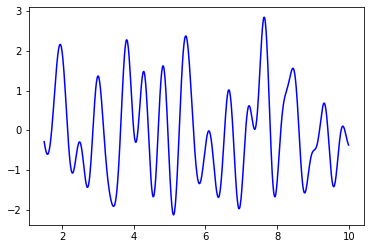

In [10]:
data_test = np.loadtxt('anatase_20191012-221015_365895.txt',delimiter=' ', dtype=float)
plt.figure()
x = np.arange(1.5,10.0,0.01)
plt.plot(x,data_test[:,1], ls='-', markerfacecolor='none',c='b',label="Anatase")

## Load in dataset

In [11]:
data = np.loadtxt('dataset/unfit_rand/mix.ana.rand.'+str(1)+'.unfit',delimiter=' ', dtype=float)
data = data[:,1]
for i in range(2,1601):
    d = np.loadtxt('dataset/unfit_rand/mix.ana.rand.'+str(i)+'.unfit',delimiter=' ', dtype=float)
    data = np.vstack((data,d[:,1]))
    
data1 = np.loadtxt('dataset/unfit_rand_2/mix.ana.rand.'+str(1601)+'.unfit',delimiter=' ', dtype=float)
data1 = data1[:,1]
for i in range(1602,3201):
    d = np.loadtxt('dataset/unfit_rand_2/mix.ana.rand.'+str(i)+'.unfit',delimiter=' ', dtype=float)
    data1 = np.vstack((data1,d[:,1]))
    
data = np.vstack((data,data1))
data.shape

(3200, 850)

## Normalize

In [12]:
data_norm = data 
for i in range(len(data_norm)):
    data_norm[i,:] = (data_norm[i,:]-min(data_norm[i,:]))/(max(data_norm[i,:])-min(data_norm[i,:]))
    
print(data_norm)

[[0.22498298 0.21371485 0.20160944 ... 0.30823645 0.30196323 0.29608836]
 [0.20590325 0.20125483 0.19711506 ... 0.35021511 0.34411069 0.3382405 ]
 [0.27275821 0.26685559 0.26084756 ... 0.35435933 0.34520209 0.33666811]
 ...
 [0.15297123 0.1422598  0.13093006 ... 0.28199449 0.27803996 0.27422141]
 [0.15410877 0.14617571 0.13791391 ... 0.3136141  0.30535041 0.29738862]
 [0.14064325 0.13571453 0.13113439 ... 0.36097874 0.34845392 0.33624978]]


In [13]:
data = data_norm

In [14]:
size = 800
groups = 4
r = 0.9
df = pd.read_excel('800.xlsx',header=None) # can also index sheet by name or fetch all sheets
print(df.shape)
mylist0 = df.to_numpy()
mylist = df.to_numpy()
for i in range(groups-1):
    mylist = np.vstack((mylist, mylist0))
print(mylist.shape)

(800, 5)
(3200, 5)


In [15]:
np.random.seed(333)
train_size = math.floor(size*r)
indices = np.zeros(shape=(math.floor(groups*size*r),))
for i in range(groups):
    indices[0+i*train_size:36+i*train_size] = np.random.choice(np.arange(0,40)+i*size, size=36, replace=False)
    indices[36+i*train_size:36+108+i*train_size] = np.random.choice(np.arange(40,160)+i*size, size=108, replace=False)
    indices[36+108+i*train_size:36+108+144+i*train_size] = np.random.choice(np.arange(160,320)+i*size, size=144, replace=False)
    indices[36+108+144+i*train_size:36+108+144+432+i*train_size] = np.random.choice(np.arange(320,800)+i*size, size=432, replace=False)
# index = np.concatenate((np.sort(random_indices1),np.sort(random_indices2),np.sort(random_indices3),np.sort(random_indices4)),axis=None)
index = np.sort(indices).astype(int)
print(index)
print(data)

data_train = data[index]
print(data_train.shape)

y_train = mylist[index,1:]
print(y_train.shape)

[   0    1    2 ... 3197 3198 3199]
[[0.22498298 0.21371485 0.20160944 ... 0.30823645 0.30196323 0.29608836]
 [0.20590325 0.20125483 0.19711506 ... 0.35021511 0.34411069 0.3382405 ]
 [0.27275821 0.26685559 0.26084756 ... 0.35435933 0.34520209 0.33666811]
 ...
 [0.15297123 0.1422598  0.13093006 ... 0.28199449 0.27803996 0.27422141]
 [0.15410877 0.14617571 0.13791391 ... 0.3136141  0.30535041 0.29738862]
 [0.14064325 0.13571453 0.13113439 ... 0.36097874 0.34845392 0.33624978]]
(2880, 850)
(2880, 4)


In [16]:
test_index_set = set(np.arange(0,800*groups)).difference(set(index))
test_index = sorted(list(test_index_set))
# print(test_index)

data_test = data[test_index]
y_test = mylist[test_index,1:]
data_test.shape

(320, 850)

In [17]:
x_train_torch = torch.from_numpy(data_train.astype(np.float32))
y_train_torch = torch.from_numpy(y_train.astype(np.float32))
y_train_torch.shape

torch.Size([2880, 4])

## Define autoencoder

In [18]:
class AE(torch.nn.Module):
    def __init__(self,latent):
        super().__init__()
          
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(850, latent),
#             torch.nn.Sigmoid()
#             torch.nn.Tanh()
            torch.nn.Softplus()
        )
          
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(latent, 850),
            #torch.nn.ReLU()
        )
  
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return encoded, decoded

In [12]:
latent = 16
model = AE(latent)

# W_nmf_t = W_nmf.astype(np.float32)
# print(W_nmf_t.shape)
W_def = data_def.astype(np.float32).T
W_init = torch.tensor(W_def[:,0:5])
# model.decoder[0].weight.data = model.decoder[0].weight.data*0 + W_init
# r = random.sample(range(latent), 5)

## initialize decoder weights
# model.decoder[0].weight.data[:,r] = model.decoder[0].weight.data[:,r]*0 + W_init
model.decoder[0].weight.data[:,0:5] = model.decoder[0].weight.data[:,0:5]*0 + W_init
# model.decoder[0].weight.data[:,10:15] = model.decoder[0].weight.data[:,10:15]*0 + W_init

In [48]:
lr = 0.00003      # learning rate
num_epochs = 2000
# Validation using MSE Loss function
recon_loss = torch.nn.MSELoss()
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
  
# Using an Adam Optimizer with lr = 0.1
optim = torch.optim.Adam(model.parameters(),lr = lr,weight_decay = 1e-8)

BATCH_SIZE = 32
thresh = 0.4
strength = 10.0

torch_dataset = Data.TensorDataset(x_train_torch, y_train_torch)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

training_loss = []
for epoch in range(num_epochs):
    for n_batch, (local_batch, __) in enumerate(loader):
        y_real = local_batch.to(device)
        # print(local_batch.shape)
   
        Hx, recon_batch = model(y_real)
        # print(y_real)
#         print(y_real.size())

#         loss = loss_function(recon_batch, y_real, Hx)
        loss = recon_loss(recon_batch, y_real)
    
        optim.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optim.step()        # apply gradients
        
        # print loss while training
        if (n_batch + 1) % 5 == 0:
            print("Epoch: [{}/{}], Batch: {}, loss: {}".format(
                epoch, num_epochs, n_batch, loss.item()))
            training_loss.append(loss.item())


Epoch: [0/2000], Batch: 4, loss: 0.37608325481414795
Epoch: [0/2000], Batch: 9, loss: 0.3543712794780731
Epoch: [0/2000], Batch: 14, loss: 0.34671369194984436
Epoch: [0/2000], Batch: 19, loss: 0.33838483691215515
Epoch: [0/2000], Batch: 24, loss: 0.3317195773124695
Epoch: [0/2000], Batch: 29, loss: 0.32766595482826233
Epoch: [0/2000], Batch: 34, loss: 0.3033994138240814
Epoch: [0/2000], Batch: 39, loss: 0.3001951277256012
Epoch: [0/2000], Batch: 44, loss: 0.2901584506034851
Epoch: [0/2000], Batch: 49, loss: 0.29502829909324646
Epoch: [0/2000], Batch: 54, loss: 0.2795638144016266
Epoch: [0/2000], Batch: 59, loss: 0.2743249237537384
Epoch: [0/2000], Batch: 64, loss: 0.27172690629959106
Epoch: [0/2000], Batch: 69, loss: 0.27253830432891846
Epoch: [0/2000], Batch: 74, loss: 0.2744828164577484
Epoch: [0/2000], Batch: 79, loss: 0.2572587728500366
Epoch: [0/2000], Batch: 84, loss: 0.2500338852405548
Epoch: [0/2000], Batch: 89, loss: 0.23989234864711761
Epoch: [1/2000], Batch: 4, loss: 0.24853

Epoch: [9/2000], Batch: 14, loss: 0.162575364112854
Epoch: [9/2000], Batch: 19, loss: 0.16842572391033173
Epoch: [9/2000], Batch: 24, loss: 0.14988356828689575
Epoch: [9/2000], Batch: 29, loss: 0.15321095287799835
Epoch: [9/2000], Batch: 34, loss: 0.14846225082874298
Epoch: [9/2000], Batch: 39, loss: 0.14662930369377136
Epoch: [9/2000], Batch: 44, loss: 0.1567295342683792
Epoch: [9/2000], Batch: 49, loss: 0.14361298084259033
Epoch: [9/2000], Batch: 54, loss: 0.14922629296779633
Epoch: [9/2000], Batch: 59, loss: 0.16292957961559296
Epoch: [9/2000], Batch: 64, loss: 0.15566402673721313
Epoch: [9/2000], Batch: 69, loss: 0.16470780968666077
Epoch: [9/2000], Batch: 74, loss: 0.14603053033351898
Epoch: [9/2000], Batch: 79, loss: 0.1389225721359253
Epoch: [9/2000], Batch: 84, loss: 0.1430334597826004
Epoch: [9/2000], Batch: 89, loss: 0.1463090032339096
Epoch: [10/2000], Batch: 4, loss: 0.1443815380334854
Epoch: [10/2000], Batch: 9, loss: 0.14739449322223663
Epoch: [10/2000], Batch: 14, loss: 

Epoch: [17/2000], Batch: 54, loss: 0.08743304759263992
Epoch: [17/2000], Batch: 59, loss: 0.08624418079853058
Epoch: [17/2000], Batch: 64, loss: 0.08718366175889969
Epoch: [17/2000], Batch: 69, loss: 0.08314750343561172
Epoch: [17/2000], Batch: 74, loss: 0.08623062819242477
Epoch: [17/2000], Batch: 79, loss: 0.07725024968385696
Epoch: [17/2000], Batch: 84, loss: 0.08042638748884201
Epoch: [17/2000], Batch: 89, loss: 0.08910294622182846
Epoch: [18/2000], Batch: 4, loss: 0.08523041009902954
Epoch: [18/2000], Batch: 9, loss: 0.07600434869527817
Epoch: [18/2000], Batch: 14, loss: 0.07993864268064499
Epoch: [18/2000], Batch: 19, loss: 0.08429016172885895
Epoch: [18/2000], Batch: 24, loss: 0.07684551179409027
Epoch: [18/2000], Batch: 29, loss: 0.08356203138828278
Epoch: [18/2000], Batch: 34, loss: 0.0787685289978981
Epoch: [18/2000], Batch: 39, loss: 0.07525670528411865
Epoch: [18/2000], Batch: 44, loss: 0.07637112587690353
Epoch: [18/2000], Batch: 49, loss: 0.0766187235713005
Epoch: [18/200

Epoch: [26/2000], Batch: 69, loss: 0.026768475770950317
Epoch: [26/2000], Batch: 74, loss: 0.027097482234239578
Epoch: [26/2000], Batch: 79, loss: 0.02490134723484516
Epoch: [26/2000], Batch: 84, loss: 0.02468918077647686
Epoch: [26/2000], Batch: 89, loss: 0.02520732395350933
Epoch: [27/2000], Batch: 4, loss: 0.022942300885915756
Epoch: [27/2000], Batch: 9, loss: 0.02448330633342266
Epoch: [27/2000], Batch: 14, loss: 0.025219466537237167
Epoch: [27/2000], Batch: 19, loss: 0.02291625738143921
Epoch: [27/2000], Batch: 24, loss: 0.02454734407365322
Epoch: [27/2000], Batch: 29, loss: 0.023104216903448105
Epoch: [27/2000], Batch: 34, loss: 0.022118335589766502
Epoch: [27/2000], Batch: 39, loss: 0.023418676108121872
Epoch: [27/2000], Batch: 44, loss: 0.022461993619799614
Epoch: [27/2000], Batch: 49, loss: 0.02327347919344902
Epoch: [27/2000], Batch: 54, loss: 0.02207999676465988
Epoch: [27/2000], Batch: 59, loss: 0.021233828738331795
Epoch: [27/2000], Batch: 64, loss: 0.023716524243354797
Ep

Epoch: [36/2000], Batch: 19, loss: 0.005952365696430206
Epoch: [36/2000], Batch: 24, loss: 0.006231844890862703
Epoch: [36/2000], Batch: 29, loss: 0.005975829437375069
Epoch: [36/2000], Batch: 34, loss: 0.0066040633246302605
Epoch: [36/2000], Batch: 39, loss: 0.005877678748220205
Epoch: [36/2000], Batch: 44, loss: 0.005962329916656017
Epoch: [36/2000], Batch: 49, loss: 0.00643257237970829
Epoch: [36/2000], Batch: 54, loss: 0.00643999082967639
Epoch: [36/2000], Batch: 59, loss: 0.006209461018443108
Epoch: [36/2000], Batch: 64, loss: 0.005846866872161627
Epoch: [36/2000], Batch: 69, loss: 0.005851249676197767
Epoch: [36/2000], Batch: 74, loss: 0.006170982960611582
Epoch: [36/2000], Batch: 79, loss: 0.005252404138445854
Epoch: [36/2000], Batch: 84, loss: 0.005869739688932896
Epoch: [36/2000], Batch: 89, loss: 0.006010012235492468
Epoch: [37/2000], Batch: 4, loss: 0.005469406023621559
Epoch: [37/2000], Batch: 9, loss: 0.0060473657213151455
Epoch: [37/2000], Batch: 14, loss: 0.0061130407266

Epoch: [45/2000], Batch: 14, loss: 0.0030140699818730354
Epoch: [45/2000], Batch: 19, loss: 0.0027151652611792088
Epoch: [45/2000], Batch: 24, loss: 0.0027695372700691223
Epoch: [45/2000], Batch: 29, loss: 0.0026655758265405893
Epoch: [45/2000], Batch: 34, loss: 0.00290185259655118
Epoch: [45/2000], Batch: 39, loss: 0.002970685949549079
Epoch: [45/2000], Batch: 44, loss: 0.0031291181221604347
Epoch: [45/2000], Batch: 49, loss: 0.003408147022128105
Epoch: [45/2000], Batch: 54, loss: 0.0029952460899949074
Epoch: [45/2000], Batch: 59, loss: 0.0028852398972958326
Epoch: [45/2000], Batch: 64, loss: 0.0028977449983358383
Epoch: [45/2000], Batch: 69, loss: 0.0030215384904295206
Epoch: [45/2000], Batch: 74, loss: 0.002460980089381337
Epoch: [45/2000], Batch: 79, loss: 0.003100544912740588
Epoch: [45/2000], Batch: 84, loss: 0.0029946810100227594
Epoch: [45/2000], Batch: 89, loss: 0.003182515036314726
Epoch: [46/2000], Batch: 4, loss: 0.002757573965936899
Epoch: [46/2000], Batch: 9, loss: 0.0028

Epoch: [54/2000], Batch: 34, loss: 0.0022420473396778107
Epoch: [54/2000], Batch: 39, loss: 0.0023071884643286467
Epoch: [54/2000], Batch: 44, loss: 0.0019415091956034303
Epoch: [54/2000], Batch: 49, loss: 0.0022836236748844385
Epoch: [54/2000], Batch: 54, loss: 0.0020926068536937237
Epoch: [54/2000], Batch: 59, loss: 0.002453036606311798
Epoch: [54/2000], Batch: 64, loss: 0.002470139879733324
Epoch: [54/2000], Batch: 69, loss: 0.002471078187227249
Epoch: [54/2000], Batch: 74, loss: 0.0024703126400709152
Epoch: [54/2000], Batch: 79, loss: 0.0024052574299275875
Epoch: [54/2000], Batch: 84, loss: 0.002369870198890567
Epoch: [54/2000], Batch: 89, loss: 0.002159821568056941
Epoch: [55/2000], Batch: 4, loss: 0.002241704845800996
Epoch: [55/2000], Batch: 9, loss: 0.0025265198200941086
Epoch: [55/2000], Batch: 14, loss: 0.0020092842169106007
Epoch: [55/2000], Batch: 19, loss: 0.0022377099376171827
Epoch: [55/2000], Batch: 24, loss: 0.002369796857237816
Epoch: [55/2000], Batch: 29, loss: 0.002

Epoch: [63/2000], Batch: 59, loss: 0.002190629718825221
Epoch: [63/2000], Batch: 64, loss: 0.0020743748173117638
Epoch: [63/2000], Batch: 69, loss: 0.002348872134461999
Epoch: [63/2000], Batch: 74, loss: 0.002009805990383029
Epoch: [63/2000], Batch: 79, loss: 0.0019867552910000086
Epoch: [63/2000], Batch: 84, loss: 0.002193808788433671
Epoch: [63/2000], Batch: 89, loss: 0.0022883235942572355
Epoch: [64/2000], Batch: 4, loss: 0.002324168337509036
Epoch: [64/2000], Batch: 9, loss: 0.0020645202603191137
Epoch: [64/2000], Batch: 14, loss: 0.0021005915477871895
Epoch: [64/2000], Batch: 19, loss: 0.002031144453212619
Epoch: [64/2000], Batch: 24, loss: 0.0021666204556822777
Epoch: [64/2000], Batch: 29, loss: 0.002521274844184518
Epoch: [64/2000], Batch: 34, loss: 0.0019243416609242558
Epoch: [64/2000], Batch: 39, loss: 0.0021018004044890404
Epoch: [64/2000], Batch: 44, loss: 0.0024511897936463356
Epoch: [64/2000], Batch: 49, loss: 0.0021693678572773933
Epoch: [64/2000], Batch: 54, loss: 0.002

Epoch: [73/2000], Batch: 9, loss: 0.0023545296862721443
Epoch: [73/2000], Batch: 14, loss: 0.0022392545361071825
Epoch: [73/2000], Batch: 19, loss: 0.0023528384044766426
Epoch: [73/2000], Batch: 24, loss: 0.002020430751144886
Epoch: [73/2000], Batch: 29, loss: 0.0021355506032705307
Epoch: [73/2000], Batch: 34, loss: 0.002073140349239111
Epoch: [73/2000], Batch: 39, loss: 0.001982971793040633
Epoch: [73/2000], Batch: 44, loss: 0.002198547124862671
Epoch: [73/2000], Batch: 49, loss: 0.001899606199003756
Epoch: [73/2000], Batch: 54, loss: 0.0021368719171732664
Epoch: [73/2000], Batch: 59, loss: 0.0020706397481262684
Epoch: [73/2000], Batch: 64, loss: 0.0019749647472053766
Epoch: [73/2000], Batch: 69, loss: 0.0019904894288629293
Epoch: [73/2000], Batch: 74, loss: 0.002411291003227234
Epoch: [73/2000], Batch: 79, loss: 0.0022301890421658754
Epoch: [73/2000], Batch: 84, loss: 0.0019509976264089346
Epoch: [73/2000], Batch: 89, loss: 0.0017299370374530554
Epoch: [74/2000], Batch: 4, loss: 0.00

Epoch: [81/2000], Batch: 64, loss: 0.0019809745717793703
Epoch: [81/2000], Batch: 69, loss: 0.002038082340732217
Epoch: [81/2000], Batch: 74, loss: 0.0017268155934289098
Epoch: [81/2000], Batch: 79, loss: 0.0021609251853078604
Epoch: [81/2000], Batch: 84, loss: 0.0019051245180889964
Epoch: [81/2000], Batch: 89, loss: 0.0019306039903312922
Epoch: [82/2000], Batch: 4, loss: 0.002246435033157468
Epoch: [82/2000], Batch: 9, loss: 0.0019909818656742573
Epoch: [82/2000], Batch: 14, loss: 0.0019121607765555382
Epoch: [82/2000], Batch: 19, loss: 0.0018738227663561702
Epoch: [82/2000], Batch: 24, loss: 0.0020328382961452007
Epoch: [82/2000], Batch: 29, loss: 0.0019411679822951555
Epoch: [82/2000], Batch: 34, loss: 0.0025381871964782476
Epoch: [82/2000], Batch: 39, loss: 0.0019948307890444994
Epoch: [82/2000], Batch: 44, loss: 0.001965341856703162
Epoch: [82/2000], Batch: 49, loss: 0.0020859986543655396
Epoch: [82/2000], Batch: 54, loss: 0.00205010618083179
Epoch: [82/2000], Batch: 59, loss: 0.0

Epoch: [90/2000], Batch: 84, loss: 0.0020287279039621353
Epoch: [90/2000], Batch: 89, loss: 0.002340026432648301
Epoch: [91/2000], Batch: 4, loss: 0.0018252748996019363
Epoch: [91/2000], Batch: 9, loss: 0.0015228006523102522
Epoch: [91/2000], Batch: 14, loss: 0.001968040131032467
Epoch: [91/2000], Batch: 19, loss: 0.002048353897407651
Epoch: [91/2000], Batch: 24, loss: 0.001939989859238267
Epoch: [91/2000], Batch: 29, loss: 0.0022167859133332968
Epoch: [91/2000], Batch: 34, loss: 0.002112432150170207
Epoch: [91/2000], Batch: 39, loss: 0.0017996430397033691
Epoch: [91/2000], Batch: 44, loss: 0.0019171331077814102
Epoch: [91/2000], Batch: 49, loss: 0.0020559097174555063
Epoch: [91/2000], Batch: 54, loss: 0.002178104594349861
Epoch: [91/2000], Batch: 59, loss: 0.0018621403723955154
Epoch: [91/2000], Batch: 64, loss: 0.001958774868398905
Epoch: [91/2000], Batch: 69, loss: 0.0022381737362593412
Epoch: [91/2000], Batch: 74, loss: 0.0021490452345460653
Epoch: [91/2000], Batch: 79, loss: 0.002

Epoch: [100/2000], Batch: 24, loss: 0.001826087012887001
Epoch: [100/2000], Batch: 29, loss: 0.0018500356236472726
Epoch: [100/2000], Batch: 34, loss: 0.0019501292845234275
Epoch: [100/2000], Batch: 39, loss: 0.0017042304389178753
Epoch: [100/2000], Batch: 44, loss: 0.002096836920827627
Epoch: [100/2000], Batch: 49, loss: 0.0019650873728096485
Epoch: [100/2000], Batch: 54, loss: 0.002100918674841523
Epoch: [100/2000], Batch: 59, loss: 0.0019340949365869164
Epoch: [100/2000], Batch: 64, loss: 0.002067112596705556
Epoch: [100/2000], Batch: 69, loss: 0.0016169471200555563
Epoch: [100/2000], Batch: 74, loss: 0.002002035267651081
Epoch: [100/2000], Batch: 79, loss: 0.001763254520483315
Epoch: [100/2000], Batch: 84, loss: 0.001658393070101738
Epoch: [100/2000], Batch: 89, loss: 0.0019036518642678857
Epoch: [101/2000], Batch: 4, loss: 0.002064452273771167
Epoch: [101/2000], Batch: 9, loss: 0.001875918242149055
Epoch: [101/2000], Batch: 14, loss: 0.0018222944345325232
Epoch: [101/2000], Batch:

Epoch: [109/2000], Batch: 44, loss: 0.0024057270493358374
Epoch: [109/2000], Batch: 49, loss: 0.0021044062450528145
Epoch: [109/2000], Batch: 54, loss: 0.00208655814640224
Epoch: [109/2000], Batch: 59, loss: 0.001978409942239523
Epoch: [109/2000], Batch: 64, loss: 0.002017886843532324
Epoch: [109/2000], Batch: 69, loss: 0.0021890399511903524
Epoch: [109/2000], Batch: 74, loss: 0.0019126205006614327
Epoch: [109/2000], Batch: 79, loss: 0.001935668638907373
Epoch: [109/2000], Batch: 84, loss: 0.0021483812015503645
Epoch: [109/2000], Batch: 89, loss: 0.0016707746544852853
Epoch: [110/2000], Batch: 4, loss: 0.0018577026203274727
Epoch: [110/2000], Batch: 9, loss: 0.0021226683165878057
Epoch: [110/2000], Batch: 14, loss: 0.0018585346406325698
Epoch: [110/2000], Batch: 19, loss: 0.001904342439956963
Epoch: [110/2000], Batch: 24, loss: 0.001668182318098843
Epoch: [110/2000], Batch: 29, loss: 0.0020365342497825623
Epoch: [110/2000], Batch: 34, loss: 0.0018624726217240095
Epoch: [110/2000], Batc

Epoch: [118/2000], Batch: 49, loss: 0.0015317039797082543
Epoch: [118/2000], Batch: 54, loss: 0.0017149181803688407
Epoch: [118/2000], Batch: 59, loss: 0.0019644785206764936
Epoch: [118/2000], Batch: 64, loss: 0.0017373014707118273
Epoch: [118/2000], Batch: 69, loss: 0.0017659803852438927
Epoch: [118/2000], Batch: 74, loss: 0.0017728748498484492
Epoch: [118/2000], Batch: 79, loss: 0.0018128191586583853
Epoch: [118/2000], Batch: 84, loss: 0.0017987026367336512
Epoch: [118/2000], Batch: 89, loss: 0.0019113777671009302
Epoch: [119/2000], Batch: 4, loss: 0.0015986320795491338
Epoch: [119/2000], Batch: 9, loss: 0.0017730322433635592
Epoch: [119/2000], Batch: 14, loss: 0.002045941539108753
Epoch: [119/2000], Batch: 19, loss: 0.0015206104144454002
Epoch: [119/2000], Batch: 24, loss: 0.001773386262357235
Epoch: [119/2000], Batch: 29, loss: 0.0018878476694226265
Epoch: [119/2000], Batch: 34, loss: 0.0015314783668145537
Epoch: [119/2000], Batch: 39, loss: 0.0016341196605935693
Epoch: [119/2000],

Epoch: [128/2000], Batch: 39, loss: 0.0016596666537225246
Epoch: [128/2000], Batch: 44, loss: 0.001654133666306734
Epoch: [128/2000], Batch: 49, loss: 0.0015265957918018103
Epoch: [128/2000], Batch: 54, loss: 0.0018091504462063313
Epoch: [128/2000], Batch: 59, loss: 0.001573079382069409
Epoch: [128/2000], Batch: 64, loss: 0.0017999937990680337
Epoch: [128/2000], Batch: 69, loss: 0.0013557246420532465
Epoch: [128/2000], Batch: 74, loss: 0.0017273409757763147
Epoch: [128/2000], Batch: 79, loss: 0.0018838323885574937
Epoch: [128/2000], Batch: 84, loss: 0.0014124477747827768
Epoch: [128/2000], Batch: 89, loss: 0.0014922822592779994
Epoch: [129/2000], Batch: 4, loss: 0.0015149565879255533
Epoch: [129/2000], Batch: 9, loss: 0.0017034150660037994
Epoch: [129/2000], Batch: 14, loss: 0.0019024931825697422
Epoch: [129/2000], Batch: 19, loss: 0.0015587408561259508
Epoch: [129/2000], Batch: 24, loss: 0.0016777749406173825
Epoch: [129/2000], Batch: 29, loss: 0.001499160542152822
Epoch: [129/2000], 

Epoch: [136/2000], Batch: 89, loss: 0.0015282484237104654
Epoch: [137/2000], Batch: 4, loss: 0.001697683590464294
Epoch: [137/2000], Batch: 9, loss: 0.0013969553401693702
Epoch: [137/2000], Batch: 14, loss: 0.001374766114167869
Epoch: [137/2000], Batch: 19, loss: 0.0015478248242288828
Epoch: [137/2000], Batch: 24, loss: 0.0014476680662482977
Epoch: [137/2000], Batch: 29, loss: 0.0016074456507340074
Epoch: [137/2000], Batch: 34, loss: 0.001617247937247157
Epoch: [137/2000], Batch: 39, loss: 0.0013196812942624092
Epoch: [137/2000], Batch: 44, loss: 0.0012876669643446803
Epoch: [137/2000], Batch: 49, loss: 0.001644572475925088
Epoch: [137/2000], Batch: 54, loss: 0.0016735399840399623
Epoch: [137/2000], Batch: 59, loss: 0.001323700649663806
Epoch: [137/2000], Batch: 64, loss: 0.0014895531348884106
Epoch: [137/2000], Batch: 69, loss: 0.001613717875443399
Epoch: [137/2000], Batch: 74, loss: 0.0015119779855012894
Epoch: [137/2000], Batch: 79, loss: 0.0014963370049372315
Epoch: [137/2000], Bat

Epoch: [145/2000], Batch: 39, loss: 0.0013510199496522546
Epoch: [145/2000], Batch: 44, loss: 0.001472015050239861
Epoch: [145/2000], Batch: 49, loss: 0.001149550429545343
Epoch: [145/2000], Batch: 54, loss: 0.0014154508244246244
Epoch: [145/2000], Batch: 59, loss: 0.0014215083792805672
Epoch: [145/2000], Batch: 64, loss: 0.001232770155183971
Epoch: [145/2000], Batch: 69, loss: 0.0011911292094737291
Epoch: [145/2000], Batch: 74, loss: 0.0014272276312112808
Epoch: [145/2000], Batch: 79, loss: 0.0014511952176690102
Epoch: [145/2000], Batch: 84, loss: 0.0015179304173216224
Epoch: [145/2000], Batch: 89, loss: 0.0016804059268906713
Epoch: [146/2000], Batch: 4, loss: 0.0012112607946619391
Epoch: [146/2000], Batch: 9, loss: 0.001401614281348884
Epoch: [146/2000], Batch: 14, loss: 0.0014099052641540766
Epoch: [146/2000], Batch: 19, loss: 0.0013275288511067629
Epoch: [146/2000], Batch: 24, loss: 0.0013814609264954925
Epoch: [146/2000], Batch: 29, loss: 0.0013617357471957803
Epoch: [146/2000], B

Epoch: [154/2000], Batch: 14, loss: 0.001271152519620955
Epoch: [154/2000], Batch: 19, loss: 0.0011777005856856704
Epoch: [154/2000], Batch: 24, loss: 0.0014407107373699546
Epoch: [154/2000], Batch: 29, loss: 0.0013408854138106108
Epoch: [154/2000], Batch: 34, loss: 0.0011952908243983984
Epoch: [154/2000], Batch: 39, loss: 0.0012316000647842884
Epoch: [154/2000], Batch: 44, loss: 0.0014899233356118202
Epoch: [154/2000], Batch: 49, loss: 0.0011727689998224378
Epoch: [154/2000], Batch: 54, loss: 0.0013652816414833069
Epoch: [154/2000], Batch: 59, loss: 0.0012216061586514115
Epoch: [154/2000], Batch: 64, loss: 0.0013142669340595603
Epoch: [154/2000], Batch: 69, loss: 0.0014431942254304886
Epoch: [154/2000], Batch: 74, loss: 0.0012318944791331887
Epoch: [154/2000], Batch: 79, loss: 0.0012219034833833575
Epoch: [154/2000], Batch: 84, loss: 0.0012350447941571474
Epoch: [154/2000], Batch: 89, loss: 0.0011712078703567386
Epoch: [155/2000], Batch: 4, loss: 0.0013576674973592162
Epoch: [155/2000

Epoch: [163/2000], Batch: 19, loss: 0.0013191865291446447
Epoch: [163/2000], Batch: 24, loss: 0.0014035857748240232
Epoch: [163/2000], Batch: 29, loss: 0.0012327416334301233
Epoch: [163/2000], Batch: 34, loss: 0.001063697854988277
Epoch: [163/2000], Batch: 39, loss: 0.001156587852165103
Epoch: [163/2000], Batch: 44, loss: 0.0011372416047379375
Epoch: [163/2000], Batch: 49, loss: 0.0009786005830392241
Epoch: [163/2000], Batch: 54, loss: 0.0010227597085759044
Epoch: [163/2000], Batch: 59, loss: 0.0011465130373835564
Epoch: [163/2000], Batch: 64, loss: 0.001221705344505608
Epoch: [163/2000], Batch: 69, loss: 0.0012918999418616295
Epoch: [163/2000], Batch: 74, loss: 0.0011235707206651568
Epoch: [163/2000], Batch: 79, loss: 0.001165300840511918
Epoch: [163/2000], Batch: 84, loss: 0.0014371291035786271
Epoch: [163/2000], Batch: 89, loss: 0.0014786433894187212
Epoch: [164/2000], Batch: 4, loss: 0.0012124653439968824
Epoch: [164/2000], Batch: 9, loss: 0.0012160969199612737
Epoch: [164/2000], B

Epoch: [171/2000], Batch: 89, loss: 0.0012314561754465103
Epoch: [172/2000], Batch: 4, loss: 0.001170787145383656
Epoch: [172/2000], Batch: 9, loss: 0.0010030919220298529
Epoch: [172/2000], Batch: 14, loss: 0.0009784637950360775
Epoch: [172/2000], Batch: 19, loss: 0.0012844429584220052
Epoch: [172/2000], Batch: 24, loss: 0.0010526854312047362
Epoch: [172/2000], Batch: 29, loss: 0.0010878369212150574
Epoch: [172/2000], Batch: 34, loss: 0.0010657062521204352
Epoch: [172/2000], Batch: 39, loss: 0.001441025990061462
Epoch: [172/2000], Batch: 44, loss: 0.0010512764565646648
Epoch: [172/2000], Batch: 49, loss: 0.001186452922411263
Epoch: [172/2000], Batch: 54, loss: 0.0013106204569339752
Epoch: [172/2000], Batch: 59, loss: 0.0008354877936653793
Epoch: [172/2000], Batch: 64, loss: 0.0010506612015888095
Epoch: [172/2000], Batch: 69, loss: 0.0010664664441719651
Epoch: [172/2000], Batch: 74, loss: 0.001287140417844057
Epoch: [172/2000], Batch: 79, loss: 0.0011939385440200567
Epoch: [172/2000], B

Epoch: [180/2000], Batch: 74, loss: 0.001147343427874148
Epoch: [180/2000], Batch: 79, loss: 0.0011151133803650737
Epoch: [180/2000], Batch: 84, loss: 0.000930811045691371
Epoch: [180/2000], Batch: 89, loss: 0.0012218463234603405
Epoch: [181/2000], Batch: 4, loss: 0.001016066875308752
Epoch: [181/2000], Batch: 9, loss: 0.0011268706293776631
Epoch: [181/2000], Batch: 14, loss: 0.0010733824456110597
Epoch: [181/2000], Batch: 19, loss: 0.0010557544883340597
Epoch: [181/2000], Batch: 24, loss: 0.0010384792694821954
Epoch: [181/2000], Batch: 29, loss: 0.001119324704632163
Epoch: [181/2000], Batch: 34, loss: 0.0009876465192064643
Epoch: [181/2000], Batch: 39, loss: 0.0009481736342422664
Epoch: [181/2000], Batch: 44, loss: 0.001210523652844131
Epoch: [181/2000], Batch: 49, loss: 0.0009931992972269654
Epoch: [181/2000], Batch: 54, loss: 0.001192785333842039
Epoch: [181/2000], Batch: 59, loss: 0.001069598481990397
Epoch: [181/2000], Batch: 64, loss: 0.0009930023225024343
Epoch: [181/2000], Batc

Epoch: [189/2000], Batch: 69, loss: 0.0010040380293503404
Epoch: [189/2000], Batch: 74, loss: 0.0010011348640546203
Epoch: [189/2000], Batch: 79, loss: 0.001081752241589129
Epoch: [189/2000], Batch: 84, loss: 0.001058976980857551
Epoch: [189/2000], Batch: 89, loss: 0.0009467056370340288
Epoch: [190/2000], Batch: 4, loss: 0.0011571411741897464
Epoch: [190/2000], Batch: 9, loss: 0.001169996103271842
Epoch: [190/2000], Batch: 14, loss: 0.0008599073044024408
Epoch: [190/2000], Batch: 19, loss: 0.0009740881505422294
Epoch: [190/2000], Batch: 24, loss: 0.000884771638084203
Epoch: [190/2000], Batch: 29, loss: 0.000967586413025856
Epoch: [190/2000], Batch: 34, loss: 0.0009752350742928684
Epoch: [190/2000], Batch: 39, loss: 0.0009188918629661202
Epoch: [190/2000], Batch: 44, loss: 0.0010088933631777763
Epoch: [190/2000], Batch: 49, loss: 0.0009004828752949834
Epoch: [190/2000], Batch: 54, loss: 0.001024719444103539
Epoch: [190/2000], Batch: 59, loss: 0.0007669261540286243
Epoch: [190/2000], Bat

Epoch: [198/2000], Batch: 69, loss: 0.0009781488915905356
Epoch: [198/2000], Batch: 74, loss: 0.0009219420608133078
Epoch: [198/2000], Batch: 79, loss: 0.0008324573864229023
Epoch: [198/2000], Batch: 84, loss: 0.0008248184458352625
Epoch: [198/2000], Batch: 89, loss: 0.0010049495613202453
Epoch: [199/2000], Batch: 4, loss: 0.0009427948389202356
Epoch: [199/2000], Batch: 9, loss: 0.0009119632886722684
Epoch: [199/2000], Batch: 14, loss: 0.0009430517675355077
Epoch: [199/2000], Batch: 19, loss: 0.0010214117355644703
Epoch: [199/2000], Batch: 24, loss: 0.0008792121079750359
Epoch: [199/2000], Batch: 29, loss: 0.0010934299789369106
Epoch: [199/2000], Batch: 34, loss: 0.0007604343700222671
Epoch: [199/2000], Batch: 39, loss: 0.0008632298558950424
Epoch: [199/2000], Batch: 44, loss: 0.0008600156870670617
Epoch: [199/2000], Batch: 49, loss: 0.0009305645362474024
Epoch: [199/2000], Batch: 54, loss: 0.0008719107136130333
Epoch: [199/2000], Batch: 59, loss: 0.0008634246187284589
Epoch: [199/2000

Epoch: [207/2000], Batch: 64, loss: 0.0009510312229394913
Epoch: [207/2000], Batch: 69, loss: 0.0007498360355384648
Epoch: [207/2000], Batch: 74, loss: 0.0008620358421467245
Epoch: [207/2000], Batch: 79, loss: 0.0007641911506652832
Epoch: [207/2000], Batch: 84, loss: 0.0007594924536533654
Epoch: [207/2000], Batch: 89, loss: 0.000860417727380991
Epoch: [208/2000], Batch: 4, loss: 0.000715032045263797
Epoch: [208/2000], Batch: 9, loss: 0.0006980676553212106
Epoch: [208/2000], Batch: 14, loss: 0.0008126732427626848
Epoch: [208/2000], Batch: 19, loss: 0.000885015178937465
Epoch: [208/2000], Batch: 24, loss: 0.0007868173415772617
Epoch: [208/2000], Batch: 29, loss: 0.0008326072129420936
Epoch: [208/2000], Batch: 34, loss: 0.0008147379267029464
Epoch: [208/2000], Batch: 39, loss: 0.0008283176575787365
Epoch: [208/2000], Batch: 44, loss: 0.0007616024231538177
Epoch: [208/2000], Batch: 49, loss: 0.000822864065412432
Epoch: [208/2000], Batch: 54, loss: 0.000738416681997478
Epoch: [208/2000], Ba

Epoch: [216/2000], Batch: 64, loss: 0.0006969719543121755
Epoch: [216/2000], Batch: 69, loss: 0.0008554930682294071
Epoch: [216/2000], Batch: 74, loss: 0.0008175431867130101
Epoch: [216/2000], Batch: 79, loss: 0.0007627062150277197
Epoch: [216/2000], Batch: 84, loss: 0.0007040372584015131
Epoch: [216/2000], Batch: 89, loss: 0.0006860785069875419
Epoch: [217/2000], Batch: 4, loss: 0.0006535234278999269
Epoch: [217/2000], Batch: 9, loss: 0.000634814437944442
Epoch: [217/2000], Batch: 14, loss: 0.0007659220136702061
Epoch: [217/2000], Batch: 19, loss: 0.0006722258985973895
Epoch: [217/2000], Batch: 24, loss: 0.0007099162903614342
Epoch: [217/2000], Batch: 29, loss: 0.0007887215469963849
Epoch: [217/2000], Batch: 34, loss: 0.0008710015099495649
Epoch: [217/2000], Batch: 39, loss: 0.0009319973760284483
Epoch: [217/2000], Batch: 44, loss: 0.0007665600278414786
Epoch: [217/2000], Batch: 49, loss: 0.0007948240963742137
Epoch: [217/2000], Batch: 54, loss: 0.0008110866765491664
Epoch: [217/2000]

Epoch: [225/2000], Batch: 69, loss: 0.0006764463032595813
Epoch: [225/2000], Batch: 74, loss: 0.0007288849446922541
Epoch: [225/2000], Batch: 79, loss: 0.0007252615760080516
Epoch: [225/2000], Batch: 84, loss: 0.0007285989122465253
Epoch: [225/2000], Batch: 89, loss: 0.00067173782736063
Epoch: [226/2000], Batch: 4, loss: 0.0006785549339838326
Epoch: [226/2000], Batch: 9, loss: 0.0007163470727391541
Epoch: [226/2000], Batch: 14, loss: 0.0005830692825838923
Epoch: [226/2000], Batch: 19, loss: 0.0005930916522629559
Epoch: [226/2000], Batch: 24, loss: 0.0006190999993123114
Epoch: [226/2000], Batch: 29, loss: 0.0006611190037801862
Epoch: [226/2000], Batch: 34, loss: 0.0007180073880590498
Epoch: [226/2000], Batch: 39, loss: 0.0008153034723363817
Epoch: [226/2000], Batch: 44, loss: 0.0007515468169003725
Epoch: [226/2000], Batch: 49, loss: 0.0007238602847792208
Epoch: [226/2000], Batch: 54, loss: 0.0005774921155534685
Epoch: [226/2000], Batch: 59, loss: 0.0006796632660552859
Epoch: [226/2000],

Epoch: [234/2000], Batch: 49, loss: 0.000620889593847096
Epoch: [234/2000], Batch: 54, loss: 0.0005960448761470616
Epoch: [234/2000], Batch: 59, loss: 0.0007076581241562963
Epoch: [234/2000], Batch: 64, loss: 0.0005412602331489325
Epoch: [234/2000], Batch: 69, loss: 0.0005458243540488183
Epoch: [234/2000], Batch: 74, loss: 0.0006377942627295852
Epoch: [234/2000], Batch: 79, loss: 0.0005765162641182542
Epoch: [234/2000], Batch: 84, loss: 0.0005459417006932199
Epoch: [234/2000], Batch: 89, loss: 0.0005468935705721378
Epoch: [235/2000], Batch: 4, loss: 0.0006639938219450414
Epoch: [235/2000], Batch: 9, loss: 0.0005512602510862052
Epoch: [235/2000], Batch: 14, loss: 0.0006745775463059545
Epoch: [235/2000], Batch: 19, loss: 0.0005762620712630451
Epoch: [235/2000], Batch: 24, loss: 0.0005706167430616915
Epoch: [235/2000], Batch: 29, loss: 0.000566651055123657
Epoch: [235/2000], Batch: 34, loss: 0.0005910561885684729
Epoch: [235/2000], Batch: 39, loss: 0.0005951024359092116
Epoch: [235/2000],

Epoch: [243/2000], Batch: 44, loss: 0.000547060917597264
Epoch: [243/2000], Batch: 49, loss: 0.000546341878362
Epoch: [243/2000], Batch: 54, loss: 0.0005047512240707874
Epoch: [243/2000], Batch: 59, loss: 0.000499571324326098
Epoch: [243/2000], Batch: 64, loss: 0.0006511211977340281
Epoch: [243/2000], Batch: 69, loss: 0.0006395603413693607
Epoch: [243/2000], Batch: 74, loss: 0.0006126486114226282
Epoch: [243/2000], Batch: 79, loss: 0.0005552571383304894
Epoch: [243/2000], Batch: 84, loss: 0.0005721955094486475
Epoch: [243/2000], Batch: 89, loss: 0.0006174907903186977
Epoch: [244/2000], Batch: 4, loss: 0.000526257383171469
Epoch: [244/2000], Batch: 9, loss: 0.0005833221948705614
Epoch: [244/2000], Batch: 14, loss: 0.0005549420602619648
Epoch: [244/2000], Batch: 19, loss: 0.0005611624219454825
Epoch: [244/2000], Batch: 24, loss: 0.0005884294514544308
Epoch: [244/2000], Batch: 29, loss: 0.0005386293632909656
Epoch: [244/2000], Batch: 34, loss: 0.0006547730299644172
Epoch: [244/2000], Batc

Epoch: [252/2000], Batch: 49, loss: 0.0005300576449371874
Epoch: [252/2000], Batch: 54, loss: 0.000544878130313009
Epoch: [252/2000], Batch: 59, loss: 0.0005567294429056346
Epoch: [252/2000], Batch: 64, loss: 0.00042908472823910415
Epoch: [252/2000], Batch: 69, loss: 0.00047042284859344363
Epoch: [252/2000], Batch: 74, loss: 0.0005540454876609147
Epoch: [252/2000], Batch: 79, loss: 0.0004665264568757266
Epoch: [252/2000], Batch: 84, loss: 0.0005387216224335134
Epoch: [252/2000], Batch: 89, loss: 0.0004834620631299913
Epoch: [253/2000], Batch: 4, loss: 0.0005078649264760315
Epoch: [253/2000], Batch: 9, loss: 0.0005590613000094891
Epoch: [253/2000], Batch: 14, loss: 0.0004492785665206611
Epoch: [253/2000], Batch: 19, loss: 0.0005191009258851409
Epoch: [253/2000], Batch: 24, loss: 0.0005791111616417766
Epoch: [253/2000], Batch: 29, loss: 0.0005604368052445352
Epoch: [253/2000], Batch: 34, loss: 0.0005001916433684528
Epoch: [253/2000], Batch: 39, loss: 0.000529252109117806
Epoch: [253/2000

Epoch: [261/2000], Batch: 34, loss: 0.0004514519532676786
Epoch: [261/2000], Batch: 39, loss: 0.0004166180151514709
Epoch: [261/2000], Batch: 44, loss: 0.0004291153745725751
Epoch: [261/2000], Batch: 49, loss: 0.0005695265135727823
Epoch: [261/2000], Batch: 54, loss: 0.00043122886563651264
Epoch: [261/2000], Batch: 59, loss: 0.0004321552987676114
Epoch: [261/2000], Batch: 64, loss: 0.0004784987831953913
Epoch: [261/2000], Batch: 69, loss: 0.00040588449337519705
Epoch: [261/2000], Batch: 74, loss: 0.0004637148813344538
Epoch: [261/2000], Batch: 79, loss: 0.0004148651787545532
Epoch: [261/2000], Batch: 84, loss: 0.0004438198229763657
Epoch: [261/2000], Batch: 89, loss: 0.00045307306572794914
Epoch: [262/2000], Batch: 4, loss: 0.00047776251449249685
Epoch: [262/2000], Batch: 9, loss: 0.0005164981121197343
Epoch: [262/2000], Batch: 14, loss: 0.0004702382138930261
Epoch: [262/2000], Batch: 19, loss: 0.00046208349522203207
Epoch: [262/2000], Batch: 24, loss: 0.0004509988648351282
Epoch: [262

Epoch: [270/2000], Batch: 34, loss: 0.0004001990891993046
Epoch: [270/2000], Batch: 39, loss: 0.000436782487668097
Epoch: [270/2000], Batch: 44, loss: 0.0004630782932508737
Epoch: [270/2000], Batch: 49, loss: 0.00040064830682240427
Epoch: [270/2000], Batch: 54, loss: 0.0004165616410318762
Epoch: [270/2000], Batch: 59, loss: 0.0003961712936870754
Epoch: [270/2000], Batch: 64, loss: 0.00047308290959335864
Epoch: [270/2000], Batch: 69, loss: 0.00042968132765963674
Epoch: [270/2000], Batch: 74, loss: 0.0004684056912083179
Epoch: [270/2000], Batch: 79, loss: 0.0003768781025428325
Epoch: [270/2000], Batch: 84, loss: 0.00038991536712273955
Epoch: [270/2000], Batch: 89, loss: 0.000450524763436988
Epoch: [271/2000], Batch: 4, loss: 0.000463197153294459
Epoch: [271/2000], Batch: 9, loss: 0.00042369685252197087
Epoch: [271/2000], Batch: 14, loss: 0.0004236027307342738
Epoch: [271/2000], Batch: 19, loss: 0.00046416427358053625
Epoch: [271/2000], Batch: 24, loss: 0.00046209924039430916
Epoch: [271/

Epoch: [279/2000], Batch: 44, loss: 0.0004509644058998674
Epoch: [279/2000], Batch: 49, loss: 0.000378178694518283
Epoch: [279/2000], Batch: 54, loss: 0.000406832987209782
Epoch: [279/2000], Batch: 59, loss: 0.00034529485856182873
Epoch: [279/2000], Batch: 64, loss: 0.0004045410605613142
Epoch: [279/2000], Batch: 69, loss: 0.00040897668804973364
Epoch: [279/2000], Batch: 74, loss: 0.0004464552621357143
Epoch: [279/2000], Batch: 79, loss: 0.00038226309698075056
Epoch: [279/2000], Batch: 84, loss: 0.00031607309938408434
Epoch: [279/2000], Batch: 89, loss: 0.0003902081516571343
Epoch: [280/2000], Batch: 4, loss: 0.00038141669938340783
Epoch: [280/2000], Batch: 9, loss: 0.00037378843990154564
Epoch: [280/2000], Batch: 14, loss: 0.0003611789725255221
Epoch: [280/2000], Batch: 19, loss: 0.0003798728866968304
Epoch: [280/2000], Batch: 24, loss: 0.0004106711712665856
Epoch: [280/2000], Batch: 29, loss: 0.0004299296997487545
Epoch: [280/2000], Batch: 34, loss: 0.0004057555925101042
Epoch: [280/

Epoch: [288/2000], Batch: 39, loss: 0.0003003075544256717
Epoch: [288/2000], Batch: 44, loss: 0.00040757915121503174
Epoch: [288/2000], Batch: 49, loss: 0.0003589174593798816
Epoch: [288/2000], Batch: 54, loss: 0.0004125541017856449
Epoch: [288/2000], Batch: 59, loss: 0.00040751200867816806
Epoch: [288/2000], Batch: 64, loss: 0.0003465925983618945
Epoch: [288/2000], Batch: 69, loss: 0.00039011918124742806
Epoch: [288/2000], Batch: 74, loss: 0.0003858392301481217
Epoch: [288/2000], Batch: 79, loss: 0.00031833184766583145
Epoch: [288/2000], Batch: 84, loss: 0.00037305153091438115
Epoch: [288/2000], Batch: 89, loss: 0.0003915353154297918
Epoch: [289/2000], Batch: 4, loss: 0.00037542282370850444
Epoch: [289/2000], Batch: 9, loss: 0.0003538219607435167
Epoch: [289/2000], Batch: 14, loss: 0.0003561169723980129
Epoch: [289/2000], Batch: 19, loss: 0.00037313802749849856
Epoch: [289/2000], Batch: 24, loss: 0.00033989589428529143
Epoch: [289/2000], Batch: 29, loss: 0.0003350621846038848
Epoch: [

Epoch: [297/2000], Batch: 39, loss: 0.00036680448101833463
Epoch: [297/2000], Batch: 44, loss: 0.0003461421583779156
Epoch: [297/2000], Batch: 49, loss: 0.0003056947607547045
Epoch: [297/2000], Batch: 54, loss: 0.0003308615123387426
Epoch: [297/2000], Batch: 59, loss: 0.00035546423168852925
Epoch: [297/2000], Batch: 64, loss: 0.00036207199445925653
Epoch: [297/2000], Batch: 69, loss: 0.00041924440301954746
Epoch: [297/2000], Batch: 74, loss: 0.00038981420220807195
Epoch: [297/2000], Batch: 79, loss: 0.0003935007844120264
Epoch: [297/2000], Batch: 84, loss: 0.0003315894864499569
Epoch: [297/2000], Batch: 89, loss: 0.00032816018210723996
Epoch: [298/2000], Batch: 4, loss: 0.00034889508970081806
Epoch: [298/2000], Batch: 9, loss: 0.00040724119753576815
Epoch: [298/2000], Batch: 14, loss: 0.0003637154586613178
Epoch: [298/2000], Batch: 19, loss: 0.0003295543137937784
Epoch: [298/2000], Batch: 24, loss: 0.00038778051384724677
Epoch: [298/2000], Batch: 29, loss: 0.0003465465852059424
Epoch: 

Epoch: [306/2000], Batch: 44, loss: 0.000393998168874532
Epoch: [306/2000], Batch: 49, loss: 0.00038532487815245986
Epoch: [306/2000], Batch: 54, loss: 0.000347093737218529
Epoch: [306/2000], Batch: 59, loss: 0.00036662074853666127
Epoch: [306/2000], Batch: 64, loss: 0.00036657508462667465
Epoch: [306/2000], Batch: 69, loss: 0.00031539853080175817
Epoch: [306/2000], Batch: 74, loss: 0.00032462264061905444
Epoch: [306/2000], Batch: 79, loss: 0.00031927076634019613
Epoch: [306/2000], Batch: 84, loss: 0.0003606337995734066
Epoch: [306/2000], Batch: 89, loss: 0.0003662357048597187
Epoch: [307/2000], Batch: 4, loss: 0.00036145519698038697
Epoch: [307/2000], Batch: 9, loss: 0.00034492448321543634
Epoch: [307/2000], Batch: 14, loss: 0.00034009217051789165
Epoch: [307/2000], Batch: 19, loss: 0.0003117260930594057
Epoch: [307/2000], Batch: 24, loss: 0.00030619915924035013
Epoch: [307/2000], Batch: 29, loss: 0.000318248727126047
Epoch: [307/2000], Batch: 34, loss: 0.0003491292882245034
Epoch: [3

Epoch: [315/2000], Batch: 39, loss: 0.0003181581269018352
Epoch: [315/2000], Batch: 44, loss: 0.0002865295682568103
Epoch: [315/2000], Batch: 49, loss: 0.00029738430748693645
Epoch: [315/2000], Batch: 54, loss: 0.0003372230567038059
Epoch: [315/2000], Batch: 59, loss: 0.0003094256389886141
Epoch: [315/2000], Batch: 64, loss: 0.0003164115478284657
Epoch: [315/2000], Batch: 69, loss: 0.0003947652003262192
Epoch: [315/2000], Batch: 74, loss: 0.00029755031573586166
Epoch: [315/2000], Batch: 79, loss: 0.0003218485217075795
Epoch: [315/2000], Batch: 84, loss: 0.0003648275160230696
Epoch: [315/2000], Batch: 89, loss: 0.00027950762887485325
Epoch: [316/2000], Batch: 4, loss: 0.00034793303348124027
Epoch: [316/2000], Batch: 9, loss: 0.0003055063134524971
Epoch: [316/2000], Batch: 14, loss: 0.00031971061252988875
Epoch: [316/2000], Batch: 19, loss: 0.00029059889493510127
Epoch: [316/2000], Batch: 24, loss: 0.0002989629574585706
Epoch: [316/2000], Batch: 29, loss: 0.0003973795974161476
Epoch: [31

Epoch: [324/2000], Batch: 39, loss: 0.00031499177566729486
Epoch: [324/2000], Batch: 44, loss: 0.0003383140719961375
Epoch: [324/2000], Batch: 49, loss: 0.0002838388318195939
Epoch: [324/2000], Batch: 54, loss: 0.00034871220123022795
Epoch: [324/2000], Batch: 59, loss: 0.00032638583797961473
Epoch: [324/2000], Batch: 64, loss: 0.00027552913525141776
Epoch: [324/2000], Batch: 69, loss: 0.00035962057881988585
Epoch: [324/2000], Batch: 74, loss: 0.00033659199834801257
Epoch: [324/2000], Batch: 79, loss: 0.0002658046723809093
Epoch: [324/2000], Batch: 84, loss: 0.0003266706771682948
Epoch: [324/2000], Batch: 89, loss: 0.00031004732591100037
Epoch: [325/2000], Batch: 4, loss: 0.0002674404240678996
Epoch: [325/2000], Batch: 9, loss: 0.0003340857510920614
Epoch: [325/2000], Batch: 14, loss: 0.00034200825029984117
Epoch: [325/2000], Batch: 19, loss: 0.0003086375363636762
Epoch: [325/2000], Batch: 24, loss: 0.0003343279822729528
Epoch: [325/2000], Batch: 29, loss: 0.0002859395171981305
Epoch: [

Epoch: [333/2000], Batch: 49, loss: 0.0003146094095427543
Epoch: [333/2000], Batch: 54, loss: 0.00029643913148902357
Epoch: [333/2000], Batch: 59, loss: 0.0002773252781480551
Epoch: [333/2000], Batch: 64, loss: 0.00034550626878626645
Epoch: [333/2000], Batch: 69, loss: 0.0003244567196816206
Epoch: [333/2000], Batch: 74, loss: 0.0002485706645529717
Epoch: [333/2000], Batch: 79, loss: 0.0002856011560652405
Epoch: [333/2000], Batch: 84, loss: 0.00030909644556231797
Epoch: [333/2000], Batch: 89, loss: 0.0003149650292471051
Epoch: [334/2000], Batch: 4, loss: 0.00028428310179151595
Epoch: [334/2000], Batch: 9, loss: 0.00030088095809333026
Epoch: [334/2000], Batch: 14, loss: 0.0003100858593825251
Epoch: [334/2000], Batch: 19, loss: 0.00032781282789073884
Epoch: [334/2000], Batch: 24, loss: 0.0003162967914249748
Epoch: [334/2000], Batch: 29, loss: 0.00033905720920301974
Epoch: [334/2000], Batch: 34, loss: 0.0003063465701416135
Epoch: [334/2000], Batch: 39, loss: 0.00030979071743786335
Epoch: [

Epoch: [342/2000], Batch: 54, loss: 0.0003535973373800516
Epoch: [342/2000], Batch: 59, loss: 0.0002627012727316469
Epoch: [342/2000], Batch: 64, loss: 0.00029274431290104985
Epoch: [342/2000], Batch: 69, loss: 0.0002993278903886676
Epoch: [342/2000], Batch: 74, loss: 0.0003153248399030417
Epoch: [342/2000], Batch: 79, loss: 0.0003515286953188479
Epoch: [342/2000], Batch: 84, loss: 0.0002745519741438329
Epoch: [342/2000], Batch: 89, loss: 0.0003618915507104248
Epoch: [343/2000], Batch: 4, loss: 0.00029387196991592646
Epoch: [343/2000], Batch: 9, loss: 0.00026806085952557623
Epoch: [343/2000], Batch: 14, loss: 0.0002975854731630534
Epoch: [343/2000], Batch: 19, loss: 0.0003327338199596852
Epoch: [343/2000], Batch: 24, loss: 0.0002724020159803331
Epoch: [343/2000], Batch: 29, loss: 0.0002880789106711745
Epoch: [343/2000], Batch: 34, loss: 0.00031393871176987886
Epoch: [343/2000], Batch: 39, loss: 0.00026463138055987656
Epoch: [343/2000], Batch: 44, loss: 0.0004096306802239269
Epoch: [343

Epoch: [351/2000], Batch: 74, loss: 0.000326678273268044
Epoch: [351/2000], Batch: 79, loss: 0.0003121135232504457
Epoch: [351/2000], Batch: 84, loss: 0.0002788016281556338
Epoch: [351/2000], Batch: 89, loss: 0.0003420062130317092
Epoch: [352/2000], Batch: 4, loss: 0.00031547126127406955
Epoch: [352/2000], Batch: 9, loss: 0.00023954766220413148
Epoch: [352/2000], Batch: 14, loss: 0.0003470825031399727
Epoch: [352/2000], Batch: 19, loss: 0.00026492532924748957
Epoch: [352/2000], Batch: 24, loss: 0.00023196155962068588
Epoch: [352/2000], Batch: 29, loss: 0.00022593366156797856
Epoch: [352/2000], Batch: 34, loss: 0.0002720389747992158
Epoch: [352/2000], Batch: 39, loss: 0.0002639317826833576
Epoch: [352/2000], Batch: 44, loss: 0.00025707625900395215
Epoch: [352/2000], Batch: 49, loss: 0.00037828084896318614
Epoch: [352/2000], Batch: 54, loss: 0.00025815883418545127
Epoch: [352/2000], Batch: 59, loss: 0.0003000476863235235
Epoch: [352/2000], Batch: 64, loss: 0.0002546753967180848
Epoch: [3

Epoch: [360/2000], Batch: 79, loss: 0.00033319578506052494
Epoch: [360/2000], Batch: 84, loss: 0.0002867397852241993
Epoch: [360/2000], Batch: 89, loss: 0.0002551836660131812
Epoch: [361/2000], Batch: 4, loss: 0.0003624469100032002
Epoch: [361/2000], Batch: 9, loss: 0.0003570447734091431
Epoch: [361/2000], Batch: 14, loss: 0.00030065749888308346
Epoch: [361/2000], Batch: 19, loss: 0.0002729973930399865
Epoch: [361/2000], Batch: 24, loss: 0.00030982765019871294
Epoch: [361/2000], Batch: 29, loss: 0.0003118879976682365
Epoch: [361/2000], Batch: 34, loss: 0.0002665839565452188
Epoch: [361/2000], Batch: 39, loss: 0.00022093953157309443
Epoch: [361/2000], Batch: 44, loss: 0.0002885971625801176
Epoch: [361/2000], Batch: 49, loss: 0.00028441791073419154
Epoch: [361/2000], Batch: 54, loss: 0.00029594809166155756
Epoch: [361/2000], Batch: 59, loss: 0.00033657127642072737
Epoch: [361/2000], Batch: 64, loss: 0.0003052966494578868
Epoch: [361/2000], Batch: 69, loss: 0.00024799120728857815
Epoch: [

Epoch: [369/2000], Batch: 74, loss: 0.00024837334058247507
Epoch: [369/2000], Batch: 79, loss: 0.0002696295559871942
Epoch: [369/2000], Batch: 84, loss: 0.00029609655030071735
Epoch: [369/2000], Batch: 89, loss: 0.0003114656428806484
Epoch: [370/2000], Batch: 4, loss: 0.0002589205396361649
Epoch: [370/2000], Batch: 9, loss: 0.0002552630612626672
Epoch: [370/2000], Batch: 14, loss: 0.0002378274075454101
Epoch: [370/2000], Batch: 19, loss: 0.0003361629496794194
Epoch: [370/2000], Batch: 24, loss: 0.0002693106944207102
Epoch: [370/2000], Batch: 29, loss: 0.0003316722286399454
Epoch: [370/2000], Batch: 34, loss: 0.0002819676592480391
Epoch: [370/2000], Batch: 39, loss: 0.00026995493681170046
Epoch: [370/2000], Batch: 44, loss: 0.0002309019910171628
Epoch: [370/2000], Batch: 49, loss: 0.0002853031037375331
Epoch: [370/2000], Batch: 54, loss: 0.0002752499422058463
Epoch: [370/2000], Batch: 59, loss: 0.00030814160709269345
Epoch: [370/2000], Batch: 64, loss: 0.00031515612499788404
Epoch: [370

Epoch: [378/2000], Batch: 59, loss: 0.00027500346186570823
Epoch: [378/2000], Batch: 64, loss: 0.00027214267174713314
Epoch: [378/2000], Batch: 69, loss: 0.00027535733534023166
Epoch: [378/2000], Batch: 74, loss: 0.00025562808150425553
Epoch: [378/2000], Batch: 79, loss: 0.00023762630007695407
Epoch: [378/2000], Batch: 84, loss: 0.0002783911768347025
Epoch: [378/2000], Batch: 89, loss: 0.00029659728170372546
Epoch: [379/2000], Batch: 4, loss: 0.0002893118071369827
Epoch: [379/2000], Batch: 9, loss: 0.00030578591395169497
Epoch: [379/2000], Batch: 14, loss: 0.0002328592527192086
Epoch: [379/2000], Batch: 19, loss: 0.00021642081264872104
Epoch: [379/2000], Batch: 24, loss: 0.00028685739380307496
Epoch: [379/2000], Batch: 29, loss: 0.0002572099328972399
Epoch: [379/2000], Batch: 34, loss: 0.0002683750353753567
Epoch: [379/2000], Batch: 39, loss: 0.00031656643841415644
Epoch: [379/2000], Batch: 44, loss: 0.00019508764671627432
Epoch: [379/2000], Batch: 49, loss: 0.0002597062266431749
Epoch

Epoch: [387/2000], Batch: 49, loss: 0.00029550542240031064
Epoch: [387/2000], Batch: 54, loss: 0.00028880377067252994
Epoch: [387/2000], Batch: 59, loss: 0.0003343063872307539
Epoch: [387/2000], Batch: 64, loss: 0.0002953800722025335
Epoch: [387/2000], Batch: 69, loss: 0.00025356211699545383
Epoch: [387/2000], Batch: 74, loss: 0.00023415540636051446
Epoch: [387/2000], Batch: 79, loss: 0.00022563600214198232
Epoch: [387/2000], Batch: 84, loss: 0.00031438336009159684
Epoch: [387/2000], Batch: 89, loss: 0.0002936805540230125
Epoch: [388/2000], Batch: 4, loss: 0.00029618118423968554
Epoch: [388/2000], Batch: 9, loss: 0.00029927442665211856
Epoch: [388/2000], Batch: 14, loss: 0.00022574863396584988
Epoch: [388/2000], Batch: 19, loss: 0.0002832928439602256
Epoch: [388/2000], Batch: 24, loss: 0.0003037891583517194
Epoch: [388/2000], Batch: 29, loss: 0.00027723133098334074
Epoch: [388/2000], Batch: 34, loss: 0.0002928848844021559
Epoch: [388/2000], Batch: 39, loss: 0.00030340260127559304
Epoch

Epoch: [396/2000], Batch: 49, loss: 0.00030686406535096467
Epoch: [396/2000], Batch: 54, loss: 0.00028172231395728886
Epoch: [396/2000], Batch: 59, loss: 0.00026633613742887974
Epoch: [396/2000], Batch: 64, loss: 0.00027956682606600225
Epoch: [396/2000], Batch: 69, loss: 0.0002461005642544478
Epoch: [396/2000], Batch: 74, loss: 0.000239107059314847
Epoch: [396/2000], Batch: 79, loss: 0.0002699080214370042
Epoch: [396/2000], Batch: 84, loss: 0.0003081162285525352
Epoch: [396/2000], Batch: 89, loss: 0.0002674597781151533
Epoch: [397/2000], Batch: 4, loss: 0.00027632975252345204
Epoch: [397/2000], Batch: 9, loss: 0.00022312713554129004
Epoch: [397/2000], Batch: 14, loss: 0.00026067683938890696
Epoch: [397/2000], Batch: 19, loss: 0.00025838150759227574
Epoch: [397/2000], Batch: 24, loss: 0.00024131026293616742
Epoch: [397/2000], Batch: 29, loss: 0.0002525932795833796
Epoch: [397/2000], Batch: 34, loss: 0.000266986433416605
Epoch: [397/2000], Batch: 39, loss: 0.00025645256391726434
Epoch: [

Epoch: [405/2000], Batch: 44, loss: 0.00026870769215747714
Epoch: [405/2000], Batch: 49, loss: 0.0002438095980323851
Epoch: [405/2000], Batch: 54, loss: 0.0002912089694291353
Epoch: [405/2000], Batch: 59, loss: 0.0002664821222424507
Epoch: [405/2000], Batch: 64, loss: 0.0002723148209042847
Epoch: [405/2000], Batch: 69, loss: 0.0002865125425159931
Epoch: [405/2000], Batch: 74, loss: 0.0003201914660166949
Epoch: [405/2000], Batch: 79, loss: 0.00022477106540463865
Epoch: [405/2000], Batch: 84, loss: 0.00024176824081223458
Epoch: [405/2000], Batch: 89, loss: 0.00024350383318960667
Epoch: [406/2000], Batch: 4, loss: 0.0002633881231304258
Epoch: [406/2000], Batch: 9, loss: 0.0002801574009936303
Epoch: [406/2000], Batch: 14, loss: 0.00024987172218970954
Epoch: [406/2000], Batch: 19, loss: 0.00026018169592134655
Epoch: [406/2000], Batch: 24, loss: 0.0002716840826906264
Epoch: [406/2000], Batch: 29, loss: 0.00021010960335843265
Epoch: [406/2000], Batch: 34, loss: 0.0002717962779570371
Epoch: [4

Epoch: [414/2000], Batch: 19, loss: 0.00027280423091724515
Epoch: [414/2000], Batch: 24, loss: 0.0002785976103041321
Epoch: [414/2000], Batch: 29, loss: 0.0002525366726331413
Epoch: [414/2000], Batch: 34, loss: 0.00025233434280380607
Epoch: [414/2000], Batch: 39, loss: 0.000263747526332736
Epoch: [414/2000], Batch: 44, loss: 0.0003377576358616352
Epoch: [414/2000], Batch: 49, loss: 0.0002372038725297898
Epoch: [414/2000], Batch: 54, loss: 0.000248563417699188
Epoch: [414/2000], Batch: 59, loss: 0.0002709306718315929
Epoch: [414/2000], Batch: 64, loss: 0.00026550996699370444
Epoch: [414/2000], Batch: 69, loss: 0.00021952393581159413
Epoch: [414/2000], Batch: 74, loss: 0.00024232004943769425
Epoch: [414/2000], Batch: 79, loss: 0.0002706647210288793
Epoch: [414/2000], Batch: 84, loss: 0.0002624208864290267
Epoch: [414/2000], Batch: 89, loss: 0.0003040845622308552
Epoch: [415/2000], Batch: 4, loss: 0.00027300603687763214
Epoch: [415/2000], Batch: 9, loss: 0.00029415456810966134
Epoch: [415

Epoch: [423/2000], Batch: 9, loss: 0.0002757980255410075
Epoch: [423/2000], Batch: 14, loss: 0.00023608558694832027
Epoch: [423/2000], Batch: 19, loss: 0.000251698395004496
Epoch: [423/2000], Batch: 24, loss: 0.00029084456036798656
Epoch: [423/2000], Batch: 29, loss: 0.00023357327154371887
Epoch: [423/2000], Batch: 34, loss: 0.0002635546261444688
Epoch: [423/2000], Batch: 39, loss: 0.00027909205527976155
Epoch: [423/2000], Batch: 44, loss: 0.00027022010181099176
Epoch: [423/2000], Batch: 49, loss: 0.00020963087445124984
Epoch: [423/2000], Batch: 54, loss: 0.00024900041171349585
Epoch: [423/2000], Batch: 59, loss: 0.00022903074568603188
Epoch: [423/2000], Batch: 64, loss: 0.0002626054920256138
Epoch: [423/2000], Batch: 69, loss: 0.0002405008563073352
Epoch: [423/2000], Batch: 74, loss: 0.00034912096452899277
Epoch: [423/2000], Batch: 79, loss: 0.00023978417448233813
Epoch: [423/2000], Batch: 84, loss: 0.00022725995222572237
Epoch: [423/2000], Batch: 89, loss: 0.0002400162920821458
Epoch

Epoch: [431/2000], Batch: 89, loss: 0.00023750241962261498
Epoch: [432/2000], Batch: 4, loss: 0.0002510730701033026
Epoch: [432/2000], Batch: 9, loss: 0.00027834007050842047
Epoch: [432/2000], Batch: 14, loss: 0.00023344131477642804
Epoch: [432/2000], Batch: 19, loss: 0.00027013555518351495
Epoch: [432/2000], Batch: 24, loss: 0.00022783367603551596
Epoch: [432/2000], Batch: 29, loss: 0.00024994570412673056
Epoch: [432/2000], Batch: 34, loss: 0.00029004341922700405
Epoch: [432/2000], Batch: 39, loss: 0.0002712639980018139
Epoch: [432/2000], Batch: 44, loss: 0.0002941856218967587
Epoch: [432/2000], Batch: 49, loss: 0.0003102871705777943
Epoch: [432/2000], Batch: 54, loss: 0.0002596478152554482
Epoch: [432/2000], Batch: 59, loss: 0.00026179340784437954
Epoch: [432/2000], Batch: 64, loss: 0.00022996540064923465
Epoch: [432/2000], Batch: 69, loss: 0.0002075226220767945
Epoch: [432/2000], Batch: 74, loss: 0.00025055883452296257
Epoch: [432/2000], Batch: 79, loss: 0.00026943435659632087
Epoch

Epoch: [440/2000], Batch: 84, loss: 0.00024307219428010285
Epoch: [440/2000], Batch: 89, loss: 0.0002474990615155548
Epoch: [441/2000], Batch: 4, loss: 0.00025564077077433467
Epoch: [441/2000], Batch: 9, loss: 0.0002511213533580303
Epoch: [441/2000], Batch: 14, loss: 0.0002967239706777036
Epoch: [441/2000], Batch: 19, loss: 0.00021788847516290843
Epoch: [441/2000], Batch: 24, loss: 0.0002607602800708264
Epoch: [441/2000], Batch: 29, loss: 0.0002619584265630692
Epoch: [441/2000], Batch: 34, loss: 0.00023035253980197012
Epoch: [441/2000], Batch: 39, loss: 0.0002450751780997962
Epoch: [441/2000], Batch: 44, loss: 0.00027934584068134427
Epoch: [441/2000], Batch: 49, loss: 0.0002609738439787179
Epoch: [441/2000], Batch: 54, loss: 0.00025736255338415504
Epoch: [441/2000], Batch: 59, loss: 0.0002808911958709359
Epoch: [441/2000], Batch: 64, loss: 0.00024028125335462391
Epoch: [441/2000], Batch: 69, loss: 0.00024337987997569144
Epoch: [441/2000], Batch: 74, loss: 0.00024010680499486625
Epoch: 

Epoch: [449/2000], Batch: 79, loss: 0.00024498236598446965
Epoch: [449/2000], Batch: 84, loss: 0.00022661674302071333
Epoch: [449/2000], Batch: 89, loss: 0.0002062566636595875
Epoch: [450/2000], Batch: 4, loss: 0.00028522731736302376
Epoch: [450/2000], Batch: 9, loss: 0.00023422532831318676
Epoch: [450/2000], Batch: 14, loss: 0.0002862749097403139
Epoch: [450/2000], Batch: 19, loss: 0.00026431502192281187
Epoch: [450/2000], Batch: 24, loss: 0.00022309759515337646
Epoch: [450/2000], Batch: 29, loss: 0.0002414328628219664
Epoch: [450/2000], Batch: 34, loss: 0.0002618097933009267
Epoch: [450/2000], Batch: 39, loss: 0.00026737182633951306
Epoch: [450/2000], Batch: 44, loss: 0.00024896793183870614
Epoch: [450/2000], Batch: 49, loss: 0.00023931422038003802
Epoch: [450/2000], Batch: 54, loss: 0.00022672863269690424
Epoch: [450/2000], Batch: 59, loss: 0.0002579963766038418
Epoch: [450/2000], Batch: 64, loss: 0.00024364930868614465
Epoch: [450/2000], Batch: 69, loss: 0.0002051253686659038
Epoch

Epoch: [458/2000], Batch: 79, loss: 0.0002057507517747581
Epoch: [458/2000], Batch: 84, loss: 0.00026138778775930405
Epoch: [458/2000], Batch: 89, loss: 0.000203114963369444
Epoch: [459/2000], Batch: 4, loss: 0.00021615903824567795
Epoch: [459/2000], Batch: 9, loss: 0.00022258867102209479
Epoch: [459/2000], Batch: 14, loss: 0.00024368664890062064
Epoch: [459/2000], Batch: 19, loss: 0.00024405615113209933
Epoch: [459/2000], Batch: 24, loss: 0.00022810391965322196
Epoch: [459/2000], Batch: 29, loss: 0.0002893876808229834
Epoch: [459/2000], Batch: 34, loss: 0.00022247826564125717
Epoch: [459/2000], Batch: 39, loss: 0.0002413098991382867
Epoch: [459/2000], Batch: 44, loss: 0.000227226410061121
Epoch: [459/2000], Batch: 49, loss: 0.0002423361293040216
Epoch: [459/2000], Batch: 54, loss: 0.000246447540121153
Epoch: [459/2000], Batch: 59, loss: 0.00025488113169558346
Epoch: [459/2000], Batch: 64, loss: 0.0002380833902861923
Epoch: [459/2000], Batch: 69, loss: 0.00020349804253783077
Epoch: [45

Epoch: [467/2000], Batch: 69, loss: 0.00025654499768279493
Epoch: [467/2000], Batch: 74, loss: 0.0002177567221224308
Epoch: [467/2000], Batch: 79, loss: 0.00024897660478018224
Epoch: [467/2000], Batch: 84, loss: 0.00025813013780862093
Epoch: [467/2000], Batch: 89, loss: 0.00021782878320664167
Epoch: [468/2000], Batch: 4, loss: 0.00023532882914878428
Epoch: [468/2000], Batch: 9, loss: 0.00024061391013674438
Epoch: [468/2000], Batch: 14, loss: 0.00023061447427608073
Epoch: [468/2000], Batch: 19, loss: 0.00023244765179697424
Epoch: [468/2000], Batch: 24, loss: 0.00024265407409984618
Epoch: [468/2000], Batch: 29, loss: 0.00026623322628438473
Epoch: [468/2000], Batch: 34, loss: 0.00025228297454304993
Epoch: [468/2000], Batch: 39, loss: 0.00027141798636876047
Epoch: [468/2000], Batch: 44, loss: 0.0002431823086226359
Epoch: [468/2000], Batch: 49, loss: 0.0001916167384479195
Epoch: [468/2000], Batch: 54, loss: 0.00022806963534094393
Epoch: [468/2000], Batch: 59, loss: 0.00018615284352563322
Ep

Epoch: [476/2000], Batch: 74, loss: 0.00022875121794641018
Epoch: [476/2000], Batch: 79, loss: 0.0002365719701629132
Epoch: [476/2000], Batch: 84, loss: 0.0002125703904312104
Epoch: [476/2000], Batch: 89, loss: 0.00020415046310517937
Epoch: [477/2000], Batch: 4, loss: 0.00023915855854284018
Epoch: [477/2000], Batch: 9, loss: 0.00025598707725293934
Epoch: [477/2000], Batch: 14, loss: 0.00021497388661373407
Epoch: [477/2000], Batch: 19, loss: 0.0002421562821837142
Epoch: [477/2000], Batch: 24, loss: 0.00024781617685221136
Epoch: [477/2000], Batch: 29, loss: 0.00021450288477353752
Epoch: [477/2000], Batch: 34, loss: 0.00022741698194295168
Epoch: [477/2000], Batch: 39, loss: 0.00022726153838448226
Epoch: [477/2000], Batch: 44, loss: 0.00023098307428881526
Epoch: [477/2000], Batch: 49, loss: 0.00022762927983421832
Epoch: [477/2000], Batch: 54, loss: 0.00023310806136578321
Epoch: [477/2000], Batch: 59, loss: 0.0002738960611168295
Epoch: [477/2000], Batch: 64, loss: 0.0002214600535808131
Epoc

Epoch: [485/2000], Batch: 74, loss: 0.000216597574763
Epoch: [485/2000], Batch: 79, loss: 0.00020864726684521884
Epoch: [485/2000], Batch: 84, loss: 0.00023231944942381233
Epoch: [485/2000], Batch: 89, loss: 0.0002486735465936363
Epoch: [486/2000], Batch: 4, loss: 0.0002829918230418116
Epoch: [486/2000], Batch: 9, loss: 0.0002571687218733132
Epoch: [486/2000], Batch: 14, loss: 0.00024927445338107646
Epoch: [486/2000], Batch: 19, loss: 0.00020748742099385709
Epoch: [486/2000], Batch: 24, loss: 0.0002447256993036717
Epoch: [486/2000], Batch: 29, loss: 0.0002287923125550151
Epoch: [486/2000], Batch: 34, loss: 0.00024224939988926053
Epoch: [486/2000], Batch: 39, loss: 0.00023171880457084626
Epoch: [486/2000], Batch: 44, loss: 0.00023042412067297846
Epoch: [486/2000], Batch: 49, loss: 0.00019705627346411347
Epoch: [486/2000], Batch: 54, loss: 0.00024035043315961957
Epoch: [486/2000], Batch: 59, loss: 0.00026690965751186013
Epoch: [486/2000], Batch: 64, loss: 0.00018448405899107456
Epoch: [4

Epoch: [494/2000], Batch: 59, loss: 0.00022484267537947744
Epoch: [494/2000], Batch: 64, loss: 0.00022938786423765123
Epoch: [494/2000], Batch: 69, loss: 0.0002509005134925246
Epoch: [494/2000], Batch: 74, loss: 0.00019718056137207896
Epoch: [494/2000], Batch: 79, loss: 0.00020938547095283866
Epoch: [494/2000], Batch: 84, loss: 0.00026001365040428936
Epoch: [494/2000], Batch: 89, loss: 0.00023250769299920648
Epoch: [495/2000], Batch: 4, loss: 0.0002054298238363117
Epoch: [495/2000], Batch: 9, loss: 0.00023686152417212725
Epoch: [495/2000], Batch: 14, loss: 0.0002626364293973893
Epoch: [495/2000], Batch: 19, loss: 0.0002551113429944962
Epoch: [495/2000], Batch: 24, loss: 0.00019141894881613553
Epoch: [495/2000], Batch: 29, loss: 0.0002344183303648606
Epoch: [495/2000], Batch: 34, loss: 0.00023283543123397976
Epoch: [495/2000], Batch: 39, loss: 0.00023914074699860066
Epoch: [495/2000], Batch: 44, loss: 0.0001982317480724305
Epoch: [495/2000], Batch: 49, loss: 0.00023509457241743803
Epoch

Epoch: [503/2000], Batch: 59, loss: 0.0002346385590499267
Epoch: [503/2000], Batch: 64, loss: 0.0002250438992632553
Epoch: [503/2000], Batch: 69, loss: 0.00020217132987454534
Epoch: [503/2000], Batch: 74, loss: 0.00022161159722600132
Epoch: [503/2000], Batch: 79, loss: 0.00023129738110583276
Epoch: [503/2000], Batch: 84, loss: 0.00022337702102959156
Epoch: [503/2000], Batch: 89, loss: 0.00020606181351467967
Epoch: [504/2000], Batch: 4, loss: 0.00020352475985419005
Epoch: [504/2000], Batch: 9, loss: 0.00023195688845589757
Epoch: [504/2000], Batch: 14, loss: 0.00025099574122577906
Epoch: [504/2000], Batch: 19, loss: 0.00020656151173170656
Epoch: [504/2000], Batch: 24, loss: 0.00024018010299187154
Epoch: [504/2000], Batch: 29, loss: 0.0001986747665796429
Epoch: [504/2000], Batch: 34, loss: 0.00019454912398941815
Epoch: [504/2000], Batch: 39, loss: 0.0001939002686413005
Epoch: [504/2000], Batch: 44, loss: 0.00026445742696523666
Epoch: [504/2000], Batch: 49, loss: 0.00021570269018411636
Epo

Epoch: [512/2000], Batch: 59, loss: 0.0002458450908306986
Epoch: [512/2000], Batch: 64, loss: 0.00023754045832902193
Epoch: [512/2000], Batch: 69, loss: 0.0002034773788182065
Epoch: [512/2000], Batch: 74, loss: 0.00024865413433872163
Epoch: [512/2000], Batch: 79, loss: 0.00021615497826132923
Epoch: [512/2000], Batch: 84, loss: 0.00020391610451042652
Epoch: [512/2000], Batch: 89, loss: 0.00022962974617257714
Epoch: [513/2000], Batch: 4, loss: 0.00020528514869511127
Epoch: [513/2000], Batch: 9, loss: 0.00025080490740947425
Epoch: [513/2000], Batch: 14, loss: 0.0002659728052094579
Epoch: [513/2000], Batch: 19, loss: 0.00024125538766384125
Epoch: [513/2000], Batch: 24, loss: 0.00023235668777488172
Epoch: [513/2000], Batch: 29, loss: 0.0001777873549144715
Epoch: [513/2000], Batch: 34, loss: 0.00021505297627300024
Epoch: [513/2000], Batch: 39, loss: 0.00024778247461654246
Epoch: [513/2000], Batch: 44, loss: 0.00019619219528976828
Epoch: [513/2000], Batch: 49, loss: 0.0002279599430039525
Epoc

Epoch: [521/2000], Batch: 59, loss: 0.00021166051737964153
Epoch: [521/2000], Batch: 64, loss: 0.00022403517505154014
Epoch: [521/2000], Batch: 69, loss: 0.00023783771030139178
Epoch: [521/2000], Batch: 74, loss: 0.00021073223615530878
Epoch: [521/2000], Batch: 79, loss: 0.00018394857761450112
Epoch: [521/2000], Batch: 84, loss: 0.00025560715585015714
Epoch: [521/2000], Batch: 89, loss: 0.0002017110091401264
Epoch: [522/2000], Batch: 4, loss: 0.0002411059831501916
Epoch: [522/2000], Batch: 9, loss: 0.00024074398970697075
Epoch: [522/2000], Batch: 14, loss: 0.0002602119348011911
Epoch: [522/2000], Batch: 19, loss: 0.00023919147497508675
Epoch: [522/2000], Batch: 24, loss: 0.00022651247854810208
Epoch: [522/2000], Batch: 29, loss: 0.0002203630720032379
Epoch: [522/2000], Batch: 34, loss: 0.00018412331701256335
Epoch: [522/2000], Batch: 39, loss: 0.00021533902327064425
Epoch: [522/2000], Batch: 44, loss: 0.0002169349609175697
Epoch: [522/2000], Batch: 49, loss: 0.00023942817642819136
Epoc

Epoch: [530/2000], Batch: 39, loss: 0.00019544950919225812
Epoch: [530/2000], Batch: 44, loss: 0.00018546206410974264
Epoch: [530/2000], Batch: 49, loss: 0.00020927141304127872
Epoch: [530/2000], Batch: 54, loss: 0.00022412819089367986
Epoch: [530/2000], Batch: 59, loss: 0.00022521459322888404
Epoch: [530/2000], Batch: 64, loss: 0.00018147444643545896
Epoch: [530/2000], Batch: 69, loss: 0.00024433000362478197
Epoch: [530/2000], Batch: 74, loss: 0.00026199567946605384
Epoch: [530/2000], Batch: 79, loss: 0.00018041167641058564
Epoch: [530/2000], Batch: 84, loss: 0.00022292367066256702
Epoch: [530/2000], Batch: 89, loss: 0.000209160236408934
Epoch: [531/2000], Batch: 4, loss: 0.00021117691358085722
Epoch: [531/2000], Batch: 9, loss: 0.00020336908346507698
Epoch: [531/2000], Batch: 14, loss: 0.00022496524616144598
Epoch: [531/2000], Batch: 19, loss: 0.00019231067562941462
Epoch: [531/2000], Batch: 24, loss: 0.00022362511663232
Epoch: [531/2000], Batch: 29, loss: 0.00018938136054202914
Epoc

Epoch: [539/2000], Batch: 24, loss: 0.00023088877787813544
Epoch: [539/2000], Batch: 29, loss: 0.00017609182395972311
Epoch: [539/2000], Batch: 34, loss: 0.00020553813374135643
Epoch: [539/2000], Batch: 39, loss: 0.00020244397455826402
Epoch: [539/2000], Batch: 44, loss: 0.00022242841077968478
Epoch: [539/2000], Batch: 49, loss: 0.0001865822123363614
Epoch: [539/2000], Batch: 54, loss: 0.000162999436724931
Epoch: [539/2000], Batch: 59, loss: 0.00020576051610987633
Epoch: [539/2000], Batch: 64, loss: 0.00019615411292761564
Epoch: [539/2000], Batch: 69, loss: 0.0002248566597700119
Epoch: [539/2000], Batch: 74, loss: 0.0002207862416980788
Epoch: [539/2000], Batch: 79, loss: 0.00024526898050680757
Epoch: [539/2000], Batch: 84, loss: 0.00019852361583616585
Epoch: [539/2000], Batch: 89, loss: 0.00018685800023376942
Epoch: [540/2000], Batch: 4, loss: 0.00019044567306991667
Epoch: [540/2000], Batch: 9, loss: 0.0001649426412768662
Epoch: [540/2000], Batch: 14, loss: 0.0001854057190939784
Epoch:

Epoch: [548/2000], Batch: 4, loss: 0.0002079902624245733
Epoch: [548/2000], Batch: 9, loss: 0.00018990226089954376
Epoch: [548/2000], Batch: 14, loss: 0.00020678751752711833
Epoch: [548/2000], Batch: 19, loss: 0.0002301547647221014
Epoch: [548/2000], Batch: 24, loss: 0.00020934849453624338
Epoch: [548/2000], Batch: 29, loss: 0.00020938555826433003
Epoch: [548/2000], Batch: 34, loss: 0.00022313639055937529
Epoch: [548/2000], Batch: 39, loss: 0.00023025284463074058
Epoch: [548/2000], Batch: 44, loss: 0.00019206952129025012
Epoch: [548/2000], Batch: 49, loss: 0.00016776256961748004
Epoch: [548/2000], Batch: 54, loss: 0.0002241172915091738
Epoch: [548/2000], Batch: 59, loss: 0.00019042236090172082
Epoch: [548/2000], Batch: 64, loss: 0.00023550482001155615
Epoch: [548/2000], Batch: 69, loss: 0.00019912559946533293
Epoch: [548/2000], Batch: 74, loss: 0.0002141417789971456
Epoch: [548/2000], Batch: 79, loss: 0.00020544251310639083
Epoch: [548/2000], Batch: 84, loss: 0.00021786977595183998
Epo

Epoch: [557/2000], Batch: 4, loss: 0.00016902001516427845
Epoch: [557/2000], Batch: 9, loss: 0.00019045532098971307
Epoch: [557/2000], Batch: 14, loss: 0.00020604940073098987
Epoch: [557/2000], Batch: 19, loss: 0.0002095963282044977
Epoch: [557/2000], Batch: 24, loss: 0.00022223925043363124
Epoch: [557/2000], Batch: 29, loss: 0.00020270983804948628
Epoch: [557/2000], Batch: 34, loss: 0.00019507169781718403
Epoch: [557/2000], Batch: 39, loss: 0.0002595476107671857
Epoch: [557/2000], Batch: 44, loss: 0.0001895120512926951
Epoch: [557/2000], Batch: 49, loss: 0.00019352971867192537
Epoch: [557/2000], Batch: 54, loss: 0.00018615886801853776
Epoch: [557/2000], Batch: 59, loss: 0.00021934973483439535
Epoch: [557/2000], Batch: 64, loss: 0.0001788775552995503
Epoch: [557/2000], Batch: 69, loss: 0.00018769405141938478
Epoch: [557/2000], Batch: 74, loss: 0.00022217865625862032
Epoch: [557/2000], Batch: 79, loss: 0.00019418504962231964
Epoch: [557/2000], Batch: 84, loss: 0.00019785358745139092
Epo

Epoch: [566/2000], Batch: 4, loss: 0.0001809474779292941
Epoch: [566/2000], Batch: 9, loss: 0.00017736609152052552
Epoch: [566/2000], Batch: 14, loss: 0.00020686372590716928
Epoch: [566/2000], Batch: 19, loss: 0.0002177405112888664
Epoch: [566/2000], Batch: 24, loss: 0.0002132931404048577
Epoch: [566/2000], Batch: 29, loss: 0.0001784812775440514
Epoch: [566/2000], Batch: 34, loss: 0.00017137490794993937
Epoch: [566/2000], Batch: 39, loss: 0.00021273606398608536
Epoch: [566/2000], Batch: 44, loss: 0.00021041205036453903
Epoch: [566/2000], Batch: 49, loss: 0.00019892401178367436
Epoch: [566/2000], Batch: 54, loss: 0.00022909362451173365
Epoch: [566/2000], Batch: 59, loss: 0.00021681678481400013
Epoch: [566/2000], Batch: 64, loss: 0.00018232740694656968
Epoch: [566/2000], Batch: 69, loss: 0.00020215311087667942
Epoch: [566/2000], Batch: 74, loss: 0.000224124567466788
Epoch: [566/2000], Batch: 79, loss: 0.0001727033668430522
Epoch: [566/2000], Batch: 84, loss: 0.00021717502386309206
Epoch:

Epoch: [574/2000], Batch: 69, loss: 0.00018042470037471503
Epoch: [574/2000], Batch: 74, loss: 0.00020683830371126533
Epoch: [574/2000], Batch: 79, loss: 0.0001623110583750531
Epoch: [574/2000], Batch: 84, loss: 0.00019692738715093583
Epoch: [574/2000], Batch: 89, loss: 0.0001855820300988853
Epoch: [575/2000], Batch: 4, loss: 0.0002172857930418104
Epoch: [575/2000], Batch: 9, loss: 0.00021244314848445356
Epoch: [575/2000], Batch: 14, loss: 0.0002283499197801575
Epoch: [575/2000], Batch: 19, loss: 0.00017602941079530865
Epoch: [575/2000], Batch: 24, loss: 0.00020412722369655967
Epoch: [575/2000], Batch: 29, loss: 0.00020125438459217548
Epoch: [575/2000], Batch: 34, loss: 0.00017889986338559538
Epoch: [575/2000], Batch: 39, loss: 0.00018781663675326854
Epoch: [575/2000], Batch: 44, loss: 0.00018081894086208194
Epoch: [575/2000], Batch: 49, loss: 0.00019998307107016444
Epoch: [575/2000], Batch: 54, loss: 0.00016765008331276476
Epoch: [575/2000], Batch: 59, loss: 0.00018256697512697428
Epo

Epoch: [583/2000], Batch: 69, loss: 0.00017643143655732274
Epoch: [583/2000], Batch: 74, loss: 0.00016869543469510972
Epoch: [583/2000], Batch: 79, loss: 0.00019569217693060637
Epoch: [583/2000], Batch: 84, loss: 0.0001625227596377954
Epoch: [583/2000], Batch: 89, loss: 0.0001963808899745345
Epoch: [584/2000], Batch: 4, loss: 0.0002136116527253762
Epoch: [584/2000], Batch: 9, loss: 0.00020310473337303847
Epoch: [584/2000], Batch: 14, loss: 0.00021499743161257356
Epoch: [584/2000], Batch: 19, loss: 0.000223358569201082
Epoch: [584/2000], Batch: 24, loss: 0.0001590901956660673
Epoch: [584/2000], Batch: 29, loss: 0.00019760422583203763
Epoch: [584/2000], Batch: 34, loss: 0.00019642888219095767
Epoch: [584/2000], Batch: 39, loss: 0.00017093268979806453
Epoch: [584/2000], Batch: 44, loss: 0.00017201884475070983
Epoch: [584/2000], Batch: 49, loss: 0.0001896278845379129
Epoch: [584/2000], Batch: 54, loss: 0.00017178001871798187
Epoch: [584/2000], Batch: 59, loss: 0.0001929677528096363
Epoch: 

Epoch: [592/2000], Batch: 64, loss: 0.0002063280699076131
Epoch: [592/2000], Batch: 69, loss: 0.00018428599287290126
Epoch: [592/2000], Batch: 74, loss: 0.0001806656364351511
Epoch: [592/2000], Batch: 79, loss: 0.0001908694684971124
Epoch: [592/2000], Batch: 84, loss: 0.00018296431517228484
Epoch: [592/2000], Batch: 89, loss: 0.00020184137974865735
Epoch: [593/2000], Batch: 4, loss: 0.00018768012523651123
Epoch: [593/2000], Batch: 9, loss: 0.00017205275071319193
Epoch: [593/2000], Batch: 14, loss: 0.0002306844253325835
Epoch: [593/2000], Batch: 19, loss: 0.00018577817536424845
Epoch: [593/2000], Batch: 24, loss: 0.00021113049297127873
Epoch: [593/2000], Batch: 29, loss: 0.00016083824448287487
Epoch: [593/2000], Batch: 34, loss: 0.0001543500111438334
Epoch: [593/2000], Batch: 39, loss: 0.00022889066895004362
Epoch: [593/2000], Batch: 44, loss: 0.00019320366845931858
Epoch: [593/2000], Batch: 49, loss: 0.00017925180145539343
Epoch: [593/2000], Batch: 54, loss: 0.00016006991791073233
Epoc

Epoch: [601/2000], Batch: 69, loss: 0.0001423140784027055
Epoch: [601/2000], Batch: 74, loss: 0.0001954952604137361
Epoch: [601/2000], Batch: 79, loss: 0.0002035313955275342
Epoch: [601/2000], Batch: 84, loss: 0.0002264018403366208
Epoch: [601/2000], Batch: 89, loss: 0.0001829411630751565
Epoch: [602/2000], Batch: 4, loss: 0.00017419517098460346
Epoch: [602/2000], Batch: 9, loss: 0.0002209981466876343
Epoch: [602/2000], Batch: 14, loss: 0.00020584338926710188
Epoch: [602/2000], Batch: 19, loss: 0.00018385717703495175
Epoch: [602/2000], Batch: 24, loss: 0.0001862515928223729
Epoch: [602/2000], Batch: 29, loss: 0.00015697104390710592
Epoch: [602/2000], Batch: 34, loss: 0.00017817350453697145
Epoch: [602/2000], Batch: 39, loss: 0.000171525840414688
Epoch: [602/2000], Batch: 44, loss: 0.00015033561794552952
Epoch: [602/2000], Batch: 49, loss: 0.00019736375543288887
Epoch: [602/2000], Batch: 54, loss: 0.00018911265942733735
Epoch: [602/2000], Batch: 59, loss: 0.0002129447238985449
Epoch: [6

Epoch: [610/2000], Batch: 59, loss: 0.000208670535357669
Epoch: [610/2000], Batch: 64, loss: 0.00018058050773106515
Epoch: [610/2000], Batch: 69, loss: 0.00019211816834285855
Epoch: [610/2000], Batch: 74, loss: 0.00019573213648982346
Epoch: [610/2000], Batch: 79, loss: 0.00017299664614256471
Epoch: [610/2000], Batch: 84, loss: 0.00014601851580664515
Epoch: [610/2000], Batch: 89, loss: 0.00019079586490988731
Epoch: [611/2000], Batch: 4, loss: 0.00017662694153841585
Epoch: [611/2000], Batch: 9, loss: 0.00016896441229619086
Epoch: [611/2000], Batch: 14, loss: 0.000182720206794329
Epoch: [611/2000], Batch: 19, loss: 0.0001748221693560481
Epoch: [611/2000], Batch: 24, loss: 0.00017828236741479486
Epoch: [611/2000], Batch: 29, loss: 0.0001675024104770273
Epoch: [611/2000], Batch: 34, loss: 0.0002260198671137914
Epoch: [611/2000], Batch: 39, loss: 0.00015960444579832256
Epoch: [611/2000], Batch: 44, loss: 0.0002011468168348074
Epoch: [611/2000], Batch: 49, loss: 0.00017690661479718983
Epoch: 

Epoch: [619/2000], Batch: 49, loss: 0.00018971993995364755
Epoch: [619/2000], Batch: 54, loss: 0.0002266555675305426
Epoch: [619/2000], Batch: 59, loss: 0.0001901057839859277
Epoch: [619/2000], Batch: 64, loss: 0.00015833723591640592
Epoch: [619/2000], Batch: 69, loss: 0.0002296286984346807
Epoch: [619/2000], Batch: 74, loss: 0.00019693022477440536
Epoch: [619/2000], Batch: 79, loss: 0.000185595010407269
Epoch: [619/2000], Batch: 84, loss: 0.00017328588000964373
Epoch: [619/2000], Batch: 89, loss: 0.00017569570627529174
Epoch: [620/2000], Batch: 4, loss: 0.00018415293016005307
Epoch: [620/2000], Batch: 9, loss: 0.00018750807794276625
Epoch: [620/2000], Batch: 14, loss: 0.0001389932876918465
Epoch: [620/2000], Batch: 19, loss: 0.00020019531075377017
Epoch: [620/2000], Batch: 24, loss: 0.00021466572070494294
Epoch: [620/2000], Batch: 29, loss: 0.00016150852025020868
Epoch: [620/2000], Batch: 34, loss: 0.0001929264544742182
Epoch: [620/2000], Batch: 39, loss: 0.00018279405776411295
Epoch:

Epoch: [628/2000], Batch: 64, loss: 0.0001502045342931524
Epoch: [628/2000], Batch: 69, loss: 0.00017704359197523445
Epoch: [628/2000], Batch: 74, loss: 0.00017314137949142605
Epoch: [628/2000], Batch: 79, loss: 0.00016640992544125766
Epoch: [628/2000], Batch: 84, loss: 0.000183898548129946
Epoch: [628/2000], Batch: 89, loss: 0.00021249588462524116
Epoch: [629/2000], Batch: 4, loss: 0.00016378199507016689
Epoch: [629/2000], Batch: 9, loss: 0.00020162604050710797
Epoch: [629/2000], Batch: 14, loss: 0.00018043133604805917
Epoch: [629/2000], Batch: 19, loss: 0.00017445140110794455
Epoch: [629/2000], Batch: 24, loss: 0.00016744501772336662
Epoch: [629/2000], Batch: 29, loss: 0.0001427514071110636
Epoch: [629/2000], Batch: 34, loss: 0.00016532267909497023
Epoch: [629/2000], Batch: 39, loss: 0.00020946902805007994
Epoch: [629/2000], Batch: 44, loss: 0.0001531320158392191
Epoch: [629/2000], Batch: 49, loss: 0.00015177643217612058
Epoch: [629/2000], Batch: 54, loss: 0.0001790602400433272
Epoch

Epoch: [637/2000], Batch: 64, loss: 0.0001680132991168648
Epoch: [637/2000], Batch: 69, loss: 0.00018775260832626373
Epoch: [637/2000], Batch: 74, loss: 0.00015622781938873231
Epoch: [637/2000], Batch: 79, loss: 0.00016335767577402294
Epoch: [637/2000], Batch: 84, loss: 0.00015277473721653223
Epoch: [637/2000], Batch: 89, loss: 0.00016237316594924778
Epoch: [638/2000], Batch: 4, loss: 0.00017242981994058937
Epoch: [638/2000], Batch: 9, loss: 0.00018614651344250888
Epoch: [638/2000], Batch: 14, loss: 0.00021126247884240001
Epoch: [638/2000], Batch: 19, loss: 0.00018801585247274488
Epoch: [638/2000], Batch: 24, loss: 0.00019002212502527982
Epoch: [638/2000], Batch: 29, loss: 0.0001834296272136271
Epoch: [638/2000], Batch: 34, loss: 0.00022163387620821595
Epoch: [638/2000], Batch: 39, loss: 0.00017985119484364986
Epoch: [638/2000], Batch: 44, loss: 0.00016552243323531002
Epoch: [638/2000], Batch: 49, loss: 0.00017475731146987528
Epoch: [638/2000], Batch: 54, loss: 0.00016773430979810655
E

Epoch: [646/2000], Batch: 44, loss: 0.0001804245257517323
Epoch: [646/2000], Batch: 49, loss: 0.0001884623197838664
Epoch: [646/2000], Batch: 54, loss: 0.00016509235138073564
Epoch: [646/2000], Batch: 59, loss: 0.0001814338902477175
Epoch: [646/2000], Batch: 64, loss: 0.00019028730457648635
Epoch: [646/2000], Batch: 69, loss: 0.0001984349946724251
Epoch: [646/2000], Batch: 74, loss: 0.00019748613703995943
Epoch: [646/2000], Batch: 79, loss: 0.00017202163871843368
Epoch: [646/2000], Batch: 84, loss: 0.00018899170390795916
Epoch: [646/2000], Batch: 89, loss: 0.000160681433044374
Epoch: [647/2000], Batch: 4, loss: 0.00019369546498637646
Epoch: [647/2000], Batch: 9, loss: 0.0001592974440427497
Epoch: [647/2000], Batch: 14, loss: 0.00014874644693918526
Epoch: [647/2000], Batch: 19, loss: 0.00018624300719238818
Epoch: [647/2000], Batch: 24, loss: 0.0001610210892977193
Epoch: [647/2000], Batch: 29, loss: 0.0001581100223120302
Epoch: [647/2000], Batch: 34, loss: 0.00018862624710891396
Epoch: [

Epoch: [655/2000], Batch: 34, loss: 0.00019371927191969007
Epoch: [655/2000], Batch: 39, loss: 0.00018168249516747892
Epoch: [655/2000], Batch: 44, loss: 0.00018465070752426982
Epoch: [655/2000], Batch: 49, loss: 0.00016083547961898148
Epoch: [655/2000], Batch: 54, loss: 0.00017630969523452222
Epoch: [655/2000], Batch: 59, loss: 0.0001607623853487894
Epoch: [655/2000], Batch: 64, loss: 0.00020533044880721718
Epoch: [655/2000], Batch: 69, loss: 0.00017224597104359418
Epoch: [655/2000], Batch: 74, loss: 0.00018963713955599815
Epoch: [655/2000], Batch: 79, loss: 0.00016418004815932363
Epoch: [655/2000], Batch: 84, loss: 0.0001916691253427416
Epoch: [655/2000], Batch: 89, loss: 0.00017155050591100007
Epoch: [656/2000], Batch: 4, loss: 0.00015397720562759787
Epoch: [656/2000], Batch: 9, loss: 0.00017730894614942372
Epoch: [656/2000], Batch: 14, loss: 0.00016043634968809783
Epoch: [656/2000], Batch: 19, loss: 0.00016352886450476944
Epoch: [656/2000], Batch: 24, loss: 0.0001641446287976578
Ep

Epoch: [664/2000], Batch: 34, loss: 0.00018060565344057977
Epoch: [664/2000], Batch: 39, loss: 0.00014621818263549358
Epoch: [664/2000], Batch: 44, loss: 0.0001886641257442534
Epoch: [664/2000], Batch: 49, loss: 0.0001890117273433134
Epoch: [664/2000], Batch: 54, loss: 0.0001716894912533462
Epoch: [664/2000], Batch: 59, loss: 0.00015640431956853718
Epoch: [664/2000], Batch: 64, loss: 0.00017419163486920297
Epoch: [664/2000], Batch: 69, loss: 0.00020453508477658033
Epoch: [664/2000], Batch: 74, loss: 0.00018896511755883694
Epoch: [664/2000], Batch: 79, loss: 0.0001838003663579002
Epoch: [664/2000], Batch: 84, loss: 0.00019544039969332516
Epoch: [664/2000], Batch: 89, loss: 0.00016335058899130672
Epoch: [665/2000], Batch: 4, loss: 0.0001692756195552647
Epoch: [665/2000], Batch: 9, loss: 0.00019039383914787322
Epoch: [665/2000], Batch: 14, loss: 0.00015325115236919373
Epoch: [665/2000], Batch: 19, loss: 0.00016154289187397808
Epoch: [665/2000], Batch: 24, loss: 0.00017213905812241137
Epoc

Epoch: [673/2000], Batch: 39, loss: 0.00018000020645558834
Epoch: [673/2000], Batch: 44, loss: 0.00017673589172773063
Epoch: [673/2000], Batch: 49, loss: 0.00014496379299089313
Epoch: [673/2000], Batch: 54, loss: 0.00017479519010521472
Epoch: [673/2000], Batch: 59, loss: 0.00018034454842563719
Epoch: [673/2000], Batch: 64, loss: 0.00016098684864118695
Epoch: [673/2000], Batch: 69, loss: 0.0001596853689989075
Epoch: [673/2000], Batch: 74, loss: 0.00019386556232348084
Epoch: [673/2000], Batch: 79, loss: 0.0001484270760556683
Epoch: [673/2000], Batch: 84, loss: 0.00016195522039197385
Epoch: [673/2000], Batch: 89, loss: 0.00017838194617070258
Epoch: [674/2000], Batch: 4, loss: 0.00016340969887096435
Epoch: [674/2000], Batch: 9, loss: 0.00017857544298749417
Epoch: [674/2000], Batch: 14, loss: 0.00016042994684539735
Epoch: [674/2000], Batch: 19, loss: 0.0001941663067555055
Epoch: [674/2000], Batch: 24, loss: 0.0001529939763713628
Epoch: [674/2000], Batch: 29, loss: 0.00018036448454950005
Epo

Epoch: [682/2000], Batch: 39, loss: 0.00013374733680393547
Epoch: [682/2000], Batch: 44, loss: 0.0001637891837162897
Epoch: [682/2000], Batch: 49, loss: 0.00018222318612970412
Epoch: [682/2000], Batch: 54, loss: 0.00015909067587926984
Epoch: [682/2000], Batch: 59, loss: 0.00016008368402253836
Epoch: [682/2000], Batch: 64, loss: 0.00014715369616169482
Epoch: [682/2000], Batch: 69, loss: 0.00018032385560218245
Epoch: [682/2000], Batch: 74, loss: 0.0001760782179189846
Epoch: [682/2000], Batch: 79, loss: 0.00017041739192791283
Epoch: [682/2000], Batch: 84, loss: 0.00018787830777000636
Epoch: [682/2000], Batch: 89, loss: 0.00016103446250781417
Epoch: [683/2000], Batch: 4, loss: 0.00016556134505663067
Epoch: [683/2000], Batch: 9, loss: 0.00018979539163410664
Epoch: [683/2000], Batch: 14, loss: 0.00015122504555620253
Epoch: [683/2000], Batch: 19, loss: 0.00016557244816794991
Epoch: [683/2000], Batch: 24, loss: 0.00015952243120409548
Epoch: [683/2000], Batch: 29, loss: 0.0002089214394800365
Ep

Epoch: [691/2000], Batch: 39, loss: 0.0001318077411269769
Epoch: [691/2000], Batch: 44, loss: 0.00016020660405047238
Epoch: [691/2000], Batch: 49, loss: 0.0001821197074605152
Epoch: [691/2000], Batch: 54, loss: 0.00016813621914479882
Epoch: [691/2000], Batch: 59, loss: 0.00015652681759092957
Epoch: [691/2000], Batch: 64, loss: 0.000155892877955921
Epoch: [691/2000], Batch: 69, loss: 0.00021795729117002338
Epoch: [691/2000], Batch: 74, loss: 0.00014530749467667192
Epoch: [691/2000], Batch: 79, loss: 0.00011723377974703908
Epoch: [691/2000], Batch: 84, loss: 0.00017678114818409085
Epoch: [691/2000], Batch: 89, loss: 0.00013577517529483885
Epoch: [692/2000], Batch: 4, loss: 0.00016311720537487417
Epoch: [692/2000], Batch: 9, loss: 0.00014275596186053008
Epoch: [692/2000], Batch: 14, loss: 0.0001296619448112324
Epoch: [692/2000], Batch: 19, loss: 0.000175036140717566
Epoch: [692/2000], Batch: 24, loss: 0.0002034036733675748
Epoch: [692/2000], Batch: 29, loss: 0.00015757698565721512
Epoch: 

Epoch: [700/2000], Batch: 49, loss: 0.00016360027075279504
Epoch: [700/2000], Batch: 54, loss: 0.00015032925875857472
Epoch: [700/2000], Batch: 59, loss: 0.0001753639808157459
Epoch: [700/2000], Batch: 64, loss: 0.00014894077321514487
Epoch: [700/2000], Batch: 69, loss: 0.00017554232908878475
Epoch: [700/2000], Batch: 74, loss: 0.00019301690917927772
Epoch: [700/2000], Batch: 79, loss: 0.0001410703844157979
Epoch: [700/2000], Batch: 84, loss: 0.0001464493543608114
Epoch: [700/2000], Batch: 89, loss: 0.0001575579954078421
Epoch: [701/2000], Batch: 4, loss: 0.00014797787298448384
Epoch: [701/2000], Batch: 9, loss: 0.00015211370191536844
Epoch: [701/2000], Batch: 14, loss: 0.00015686449478380382
Epoch: [701/2000], Batch: 19, loss: 0.00014112734061200172
Epoch: [701/2000], Batch: 24, loss: 0.0001408700627507642
Epoch: [701/2000], Batch: 29, loss: 0.00017751395353116095
Epoch: [701/2000], Batch: 34, loss: 0.00015568888920824975
Epoch: [701/2000], Batch: 39, loss: 0.00020369113190099597
Epoc

Epoch: [709/2000], Batch: 39, loss: 0.0001316838024649769
Epoch: [709/2000], Batch: 44, loss: 0.0001912962325150147
Epoch: [709/2000], Batch: 49, loss: 0.00015303688996937126
Epoch: [709/2000], Batch: 54, loss: 0.00014990386262070388
Epoch: [709/2000], Batch: 59, loss: 0.00017789503908716142
Epoch: [709/2000], Batch: 64, loss: 0.00016074327868409455
Epoch: [709/2000], Batch: 69, loss: 0.00015140751202125102
Epoch: [709/2000], Batch: 74, loss: 0.00016334150859620422
Epoch: [709/2000], Batch: 79, loss: 0.00013515757746063173
Epoch: [709/2000], Batch: 84, loss: 0.00014963574358262122
Epoch: [709/2000], Batch: 89, loss: 0.0001443452201783657
Epoch: [710/2000], Batch: 4, loss: 0.00017576715617906302
Epoch: [710/2000], Batch: 9, loss: 0.00017422491509933025
Epoch: [710/2000], Batch: 14, loss: 0.00016346058691851795
Epoch: [710/2000], Batch: 19, loss: 0.0001697393599897623
Epoch: [710/2000], Batch: 24, loss: 0.00015513633843511343
Epoch: [710/2000], Batch: 29, loss: 0.00016926502576097846
Epo

Epoch: [718/2000], Batch: 44, loss: 0.00016915812739171088
Epoch: [718/2000], Batch: 49, loss: 0.0001481717190472409
Epoch: [718/2000], Batch: 54, loss: 0.00015520292799919844
Epoch: [718/2000], Batch: 59, loss: 0.00015100192104000598
Epoch: [718/2000], Batch: 64, loss: 0.0001800971367629245
Epoch: [718/2000], Batch: 69, loss: 0.00012456932745408267
Epoch: [718/2000], Batch: 74, loss: 0.0001596598740434274
Epoch: [718/2000], Batch: 79, loss: 0.00012092194810975343
Epoch: [718/2000], Batch: 84, loss: 0.00016701048298273236
Epoch: [718/2000], Batch: 89, loss: 0.0001957426720764488
Epoch: [719/2000], Batch: 4, loss: 0.0001654903608141467
Epoch: [719/2000], Batch: 9, loss: 0.00022567874111700803
Epoch: [719/2000], Batch: 14, loss: 0.00016629660967737436
Epoch: [719/2000], Batch: 19, loss: 0.00018012573127634823
Epoch: [719/2000], Batch: 24, loss: 0.0001443729706807062
Epoch: [719/2000], Batch: 29, loss: 0.00015060919395182282
Epoch: [719/2000], Batch: 34, loss: 0.00014251470565795898
Epoch

Epoch: [727/2000], Batch: 44, loss: 0.0001372992410324514
Epoch: [727/2000], Batch: 49, loss: 0.00017084478167816997
Epoch: [727/2000], Batch: 54, loss: 0.00014259213639888912
Epoch: [727/2000], Batch: 59, loss: 0.00013207188749220222
Epoch: [727/2000], Batch: 64, loss: 0.00014436237688641995
Epoch: [727/2000], Batch: 69, loss: 0.00019777670968323946
Epoch: [727/2000], Batch: 74, loss: 0.0001700149878161028
Epoch: [727/2000], Batch: 79, loss: 0.0001472821313655004
Epoch: [727/2000], Batch: 84, loss: 0.00015152807463891804
Epoch: [727/2000], Batch: 89, loss: 0.00016172314644791186
Epoch: [728/2000], Batch: 4, loss: 0.00013793820107821375
Epoch: [728/2000], Batch: 9, loss: 0.00015123948105610907
Epoch: [728/2000], Batch: 14, loss: 0.0001578743103891611
Epoch: [728/2000], Batch: 19, loss: 0.0001572116307215765
Epoch: [728/2000], Batch: 24, loss: 0.00016579352086409926
Epoch: [728/2000], Batch: 29, loss: 0.00018240341159980744
Epoch: [728/2000], Batch: 34, loss: 0.00017753304564394057
Epoc

Epoch: [736/2000], Batch: 44, loss: 0.0001593076449353248
Epoch: [736/2000], Batch: 49, loss: 0.0001341018360108137
Epoch: [736/2000], Batch: 54, loss: 0.00014125350571703166
Epoch: [736/2000], Batch: 59, loss: 0.00014919177920091897
Epoch: [736/2000], Batch: 64, loss: 0.00015758811787236482
Epoch: [736/2000], Batch: 69, loss: 0.00016097012849058956
Epoch: [736/2000], Batch: 74, loss: 0.00015988416271284223
Epoch: [736/2000], Batch: 79, loss: 0.0001563050172990188
Epoch: [736/2000], Batch: 84, loss: 0.0001542755780974403
Epoch: [736/2000], Batch: 89, loss: 0.00015464425086975098
Epoch: [737/2000], Batch: 4, loss: 0.0001675450912443921
Epoch: [737/2000], Batch: 9, loss: 0.0001224384905071929
Epoch: [737/2000], Batch: 14, loss: 0.0001426821982022375
Epoch: [737/2000], Batch: 19, loss: 0.00013843616761732846
Epoch: [737/2000], Batch: 24, loss: 0.00016337190754711628
Epoch: [737/2000], Batch: 29, loss: 0.0001521528174635023
Epoch: [737/2000], Batch: 34, loss: 0.00013409342500381172
Epoch: 

Epoch: [745/2000], Batch: 64, loss: 0.0001432993885828182
Epoch: [745/2000], Batch: 69, loss: 0.00016588078869972378
Epoch: [745/2000], Batch: 74, loss: 0.00015529045776929706
Epoch: [745/2000], Batch: 79, loss: 0.0001477381301810965
Epoch: [745/2000], Batch: 84, loss: 0.00014569911581929773
Epoch: [745/2000], Batch: 89, loss: 0.0001530328008811921
Epoch: [746/2000], Batch: 4, loss: 0.00017706005019135773
Epoch: [746/2000], Batch: 9, loss: 0.00015657003677915782
Epoch: [746/2000], Batch: 14, loss: 0.00012787673040293157
Epoch: [746/2000], Batch: 19, loss: 0.00015023590822238475
Epoch: [746/2000], Batch: 24, loss: 0.00015902869927231222
Epoch: [746/2000], Batch: 29, loss: 0.0001495184114901349
Epoch: [746/2000], Batch: 34, loss: 0.00014450401067733765
Epoch: [746/2000], Batch: 39, loss: 0.00015202115173451602
Epoch: [746/2000], Batch: 44, loss: 0.00015071428788360208
Epoch: [746/2000], Batch: 49, loss: 0.0001347936922684312
Epoch: [746/2000], Batch: 54, loss: 0.00014150532661005855
Epoc

Epoch: [754/2000], Batch: 64, loss: 0.00013691122876480222
Epoch: [754/2000], Batch: 69, loss: 0.0001926641707541421
Epoch: [754/2000], Batch: 74, loss: 0.00012985941430088133
Epoch: [754/2000], Batch: 79, loss: 0.00016747592599131167
Epoch: [754/2000], Batch: 84, loss: 0.0001506647968199104
Epoch: [754/2000], Batch: 89, loss: 0.00016193094779737294
Epoch: [755/2000], Batch: 4, loss: 0.00017304194625467062
Epoch: [755/2000], Batch: 9, loss: 0.00015749406884424388
Epoch: [755/2000], Batch: 14, loss: 0.00015548845112789422
Epoch: [755/2000], Batch: 19, loss: 0.00016811885870993137
Epoch: [755/2000], Batch: 24, loss: 0.00012332732148934156
Epoch: [755/2000], Batch: 29, loss: 0.0001466863468522206
Epoch: [755/2000], Batch: 34, loss: 0.00015759085363242775
Epoch: [755/2000], Batch: 39, loss: 0.00014849849685560912
Epoch: [755/2000], Batch: 44, loss: 0.00015441764844581485
Epoch: [755/2000], Batch: 49, loss: 0.00015150175022426993
Epoch: [755/2000], Batch: 54, loss: 0.00016208727902267128
Ep

Epoch: [763/2000], Batch: 59, loss: 0.0001661376591073349
Epoch: [763/2000], Batch: 64, loss: 0.0001451186544727534
Epoch: [763/2000], Batch: 69, loss: 0.0001363814517389983
Epoch: [763/2000], Batch: 74, loss: 0.00014082755660638213
Epoch: [763/2000], Batch: 79, loss: 0.00015301877283491194
Epoch: [763/2000], Batch: 84, loss: 0.0001383996568620205
Epoch: [763/2000], Batch: 89, loss: 0.0001403154747094959
Epoch: [764/2000], Batch: 4, loss: 0.0001371866965200752
Epoch: [764/2000], Batch: 9, loss: 0.00013640039833262563
Epoch: [764/2000], Batch: 14, loss: 0.0001381618931191042
Epoch: [764/2000], Batch: 19, loss: 0.00013795388804282993
Epoch: [764/2000], Batch: 24, loss: 0.00014472946349997073
Epoch: [764/2000], Batch: 29, loss: 0.00013245214358903468
Epoch: [764/2000], Batch: 34, loss: 0.000145846584928222
Epoch: [764/2000], Batch: 39, loss: 0.00017370455316267908
Epoch: [764/2000], Batch: 44, loss: 0.00015675308532081544
Epoch: [764/2000], Batch: 49, loss: 0.00018468282360117882
Epoch: [

Epoch: [772/2000], Batch: 64, loss: 0.00011948052269872278
Epoch: [772/2000], Batch: 69, loss: 0.0001569841697346419
Epoch: [772/2000], Batch: 74, loss: 0.00017433588800486177
Epoch: [772/2000], Batch: 79, loss: 0.00018372641352470964
Epoch: [772/2000], Batch: 84, loss: 0.00013468999532051384
Epoch: [772/2000], Batch: 89, loss: 0.00014330580597743392
Epoch: [773/2000], Batch: 4, loss: 0.0001678874687058851
Epoch: [773/2000], Batch: 9, loss: 0.00015072272799443454
Epoch: [773/2000], Batch: 14, loss: 0.00014626936172135174
Epoch: [773/2000], Batch: 19, loss: 0.00012901159061584622
Epoch: [773/2000], Batch: 24, loss: 0.0001732839591568336
Epoch: [773/2000], Batch: 29, loss: 0.00016061328642535955
Epoch: [773/2000], Batch: 34, loss: 0.00017285636567976326
Epoch: [773/2000], Batch: 39, loss: 0.00017450653831474483
Epoch: [773/2000], Batch: 44, loss: 0.00014014386397320777
Epoch: [773/2000], Batch: 49, loss: 0.00014478147204499692
Epoch: [773/2000], Batch: 54, loss: 0.00015489777433685958
Ep

Epoch: [781/2000], Batch: 44, loss: 0.00013949893764220178
Epoch: [781/2000], Batch: 49, loss: 0.00016586283163633198
Epoch: [781/2000], Batch: 54, loss: 0.00013488317199517041
Epoch: [781/2000], Batch: 59, loss: 0.000129121879581362
Epoch: [781/2000], Batch: 64, loss: 0.0001663115108385682
Epoch: [781/2000], Batch: 69, loss: 0.0001336893328698352
Epoch: [781/2000], Batch: 74, loss: 0.00012694054748862982
Epoch: [781/2000], Batch: 79, loss: 0.0001501218503108248
Epoch: [781/2000], Batch: 84, loss: 0.00014629705401603132
Epoch: [781/2000], Batch: 89, loss: 0.00013012958515901119
Epoch: [782/2000], Batch: 4, loss: 0.00017014464538078755
Epoch: [782/2000], Batch: 9, loss: 0.00015384532161988318
Epoch: [782/2000], Batch: 14, loss: 0.00015010015340521932
Epoch: [782/2000], Batch: 19, loss: 0.00017481422401033342
Epoch: [782/2000], Batch: 24, loss: 0.00015830514894332737
Epoch: [782/2000], Batch: 29, loss: 0.00015595245349686593
Epoch: [782/2000], Batch: 34, loss: 9.703674732008949e-05
Epoch

Epoch: [790/2000], Batch: 39, loss: 0.00014560535782948136
Epoch: [790/2000], Batch: 44, loss: 0.0001302177261095494
Epoch: [790/2000], Batch: 49, loss: 0.0001328049838775769
Epoch: [790/2000], Batch: 54, loss: 0.00015480921138077974
Epoch: [790/2000], Batch: 59, loss: 0.00017224861949216574
Epoch: [790/2000], Batch: 64, loss: 0.00016034323198255152
Epoch: [790/2000], Batch: 69, loss: 0.00016324948228430003
Epoch: [790/2000], Batch: 74, loss: 0.00015051205991767347
Epoch: [790/2000], Batch: 79, loss: 0.00014393067976925522
Epoch: [790/2000], Batch: 84, loss: 0.00016201853577513248
Epoch: [790/2000], Batch: 89, loss: 0.00016143018729053438
Epoch: [791/2000], Batch: 4, loss: 0.0001533229078631848
Epoch: [791/2000], Batch: 9, loss: 0.00012449928908608854
Epoch: [791/2000], Batch: 14, loss: 0.00015032521332614124
Epoch: [791/2000], Batch: 19, loss: 0.00012707266432698816
Epoch: [791/2000], Batch: 24, loss: 0.00017025003035087138
Epoch: [791/2000], Batch: 29, loss: 0.00016203525592572987
Ep

Epoch: [799/2000], Batch: 24, loss: 0.0001367460936307907
Epoch: [799/2000], Batch: 29, loss: 0.00017589870549272746
Epoch: [799/2000], Batch: 34, loss: 0.0001435376616427675
Epoch: [799/2000], Batch: 39, loss: 0.00014702182670589536
Epoch: [799/2000], Batch: 44, loss: 0.00011621108569670469
Epoch: [799/2000], Batch: 49, loss: 0.00015743401309009641
Epoch: [799/2000], Batch: 54, loss: 0.00012992242409382015
Epoch: [799/2000], Batch: 59, loss: 0.00014915555948391557
Epoch: [799/2000], Batch: 64, loss: 0.00014192078378982842
Epoch: [799/2000], Batch: 69, loss: 0.0001454187004128471
Epoch: [799/2000], Batch: 74, loss: 0.00014470401220023632
Epoch: [799/2000], Batch: 79, loss: 0.00013095552276354283
Epoch: [799/2000], Batch: 84, loss: 0.00014415009354706854
Epoch: [799/2000], Batch: 89, loss: 0.00013551520532928407
Epoch: [800/2000], Batch: 4, loss: 0.00014125840971246362
Epoch: [800/2000], Batch: 9, loss: 0.0001531836751382798
Epoch: [800/2000], Batch: 14, loss: 0.0001367574732284993
Epoc

Epoch: [807/2000], Batch: 59, loss: 0.0001575461938045919
Epoch: [807/2000], Batch: 64, loss: 0.00014252157416194677
Epoch: [807/2000], Batch: 69, loss: 0.0001447715621907264
Epoch: [807/2000], Batch: 74, loss: 0.0001229628105647862
Epoch: [807/2000], Batch: 79, loss: 0.00013763931929133832
Epoch: [807/2000], Batch: 84, loss: 0.00015092386456672102
Epoch: [807/2000], Batch: 89, loss: 0.00013883666542824358
Epoch: [808/2000], Batch: 4, loss: 0.00014015025226399302
Epoch: [808/2000], Batch: 9, loss: 0.0001510446600150317
Epoch: [808/2000], Batch: 14, loss: 0.00010818017472047359
Epoch: [808/2000], Batch: 19, loss: 0.00013296736869961023
Epoch: [808/2000], Batch: 24, loss: 0.00014035285857971758
Epoch: [808/2000], Batch: 29, loss: 0.00014119999832473695
Epoch: [808/2000], Batch: 34, loss: 0.00013901651254855096
Epoch: [808/2000], Batch: 39, loss: 0.0001737461716402322
Epoch: [808/2000], Batch: 44, loss: 0.00012046642223140225
Epoch: [808/2000], Batch: 49, loss: 0.000142270015203394
Epoch:

Epoch: [816/2000], Batch: 4, loss: 0.00013947408297099173
Epoch: [816/2000], Batch: 9, loss: 0.0001414269208908081
Epoch: [816/2000], Batch: 14, loss: 0.00014412571908906102
Epoch: [816/2000], Batch: 19, loss: 0.00013679823314305395
Epoch: [816/2000], Batch: 24, loss: 0.00014384524547494948
Epoch: [816/2000], Batch: 29, loss: 0.00012684054672718048
Epoch: [816/2000], Batch: 34, loss: 0.00014660197484772652
Epoch: [816/2000], Batch: 39, loss: 0.00013565231347456574
Epoch: [816/2000], Batch: 44, loss: 0.00014156918041408062
Epoch: [816/2000], Batch: 49, loss: 0.00014427551650442183
Epoch: [816/2000], Batch: 54, loss: 0.00012484591570682824
Epoch: [816/2000], Batch: 59, loss: 0.0001502984086982906
Epoch: [816/2000], Batch: 64, loss: 0.00012696959311142564
Epoch: [816/2000], Batch: 69, loss: 0.0001411968987667933
Epoch: [816/2000], Batch: 74, loss: 0.00013925335952080786
Epoch: [816/2000], Batch: 79, loss: 0.00015106084174476564
Epoch: [816/2000], Batch: 84, loss: 0.00014206719060894102
Ep

Epoch: [824/2000], Batch: 29, loss: 0.0001357021537842229
Epoch: [824/2000], Batch: 34, loss: 0.0001527207059552893
Epoch: [824/2000], Batch: 39, loss: 0.00014619076682720333
Epoch: [824/2000], Batch: 44, loss: 0.00014563188597094268
Epoch: [824/2000], Batch: 49, loss: 0.00013558851787820458
Epoch: [824/2000], Batch: 54, loss: 0.00013622549886349589
Epoch: [824/2000], Batch: 59, loss: 0.00011468136654002592
Epoch: [824/2000], Batch: 64, loss: 0.0001286169863305986
Epoch: [824/2000], Batch: 69, loss: 0.00014033853949513286
Epoch: [824/2000], Batch: 74, loss: 0.0001221111015183851
Epoch: [824/2000], Batch: 79, loss: 0.00011754703155020252
Epoch: [824/2000], Batch: 84, loss: 0.00015461634029634297
Epoch: [824/2000], Batch: 89, loss: 0.00013528403360396624
Epoch: [825/2000], Batch: 4, loss: 0.00014554767403751612
Epoch: [825/2000], Batch: 9, loss: 0.00014520531112793833
Epoch: [825/2000], Batch: 14, loss: 0.00013172351464163512
Epoch: [825/2000], Batch: 19, loss: 0.00014230774831958115
Epo

Epoch: [832/2000], Batch: 79, loss: 0.00012609285477083176
Epoch: [832/2000], Batch: 84, loss: 0.0001514434115961194
Epoch: [832/2000], Batch: 89, loss: 0.0001338917063549161
Epoch: [833/2000], Batch: 4, loss: 0.00012731879542116076
Epoch: [833/2000], Batch: 9, loss: 0.00013612258771900088
Epoch: [833/2000], Batch: 14, loss: 0.0001255136012332514
Epoch: [833/2000], Batch: 19, loss: 0.00011090803309343755
Epoch: [833/2000], Batch: 24, loss: 0.000132792629301548
Epoch: [833/2000], Batch: 29, loss: 0.00016464601503685117
Epoch: [833/2000], Batch: 34, loss: 0.00013485635281540453
Epoch: [833/2000], Batch: 39, loss: 0.00017232184472959489
Epoch: [833/2000], Batch: 44, loss: 0.00012815867376048118
Epoch: [833/2000], Batch: 49, loss: 0.00011724643991328776
Epoch: [833/2000], Batch: 54, loss: 0.00012440691352821887
Epoch: [833/2000], Batch: 59, loss: 0.00011649718362605199
Epoch: [833/2000], Batch: 64, loss: 0.00012440115096978843
Epoch: [833/2000], Batch: 69, loss: 0.00016677952953614295
Epoc

Epoch: [841/2000], Batch: 14, loss: 0.0001521184021839872
Epoch: [841/2000], Batch: 19, loss: 0.00012158730532974005
Epoch: [841/2000], Batch: 24, loss: 0.00012099474406568334
Epoch: [841/2000], Batch: 29, loss: 0.00013421646144706756
Epoch: [841/2000], Batch: 34, loss: 0.00014630475197918713
Epoch: [841/2000], Batch: 39, loss: 0.0001351496612187475
Epoch: [841/2000], Batch: 44, loss: 0.0001569708838360384
Epoch: [841/2000], Batch: 49, loss: 0.00013005211076233536
Epoch: [841/2000], Batch: 54, loss: 0.00013675191439688206
Epoch: [841/2000], Batch: 59, loss: 0.00012114849232602865
Epoch: [841/2000], Batch: 64, loss: 0.00013963492529001087
Epoch: [841/2000], Batch: 69, loss: 0.00013124692486599088
Epoch: [841/2000], Batch: 74, loss: 0.0001320955198025331
Epoch: [841/2000], Batch: 79, loss: 0.00014098735118750483
Epoch: [841/2000], Batch: 84, loss: 0.0001438105246052146
Epoch: [841/2000], Batch: 89, loss: 0.00012948756921105087
Epoch: [842/2000], Batch: 4, loss: 0.0001318415888817981
Epoc

Epoch: [850/2000], Batch: 14, loss: 0.00015507140778936446
Epoch: [850/2000], Batch: 19, loss: 0.00012024154420942068
Epoch: [850/2000], Batch: 24, loss: 0.00013306726759765297
Epoch: [850/2000], Batch: 29, loss: 0.0001555061899125576
Epoch: [850/2000], Batch: 34, loss: 0.00018759776139631867
Epoch: [850/2000], Batch: 39, loss: 0.00014247503713704646
Epoch: [850/2000], Batch: 44, loss: 0.00013066598330624402
Epoch: [850/2000], Batch: 49, loss: 0.0001390760444337502
Epoch: [850/2000], Batch: 54, loss: 0.0001246418250957504
Epoch: [850/2000], Batch: 59, loss: 0.00012106935901101679
Epoch: [850/2000], Batch: 64, loss: 0.00015513013931922615
Epoch: [850/2000], Batch: 69, loss: 0.00010795221896842122
Epoch: [850/2000], Batch: 74, loss: 0.0001465172099415213
Epoch: [850/2000], Batch: 79, loss: 0.0001301557058468461
Epoch: [850/2000], Batch: 84, loss: 0.00012736140342894942
Epoch: [850/2000], Batch: 89, loss: 0.00015029055066406727
Epoch: [851/2000], Batch: 4, loss: 0.00014896538050379604
Epo

Epoch: [859/2000], Batch: 4, loss: 0.0001417475432390347
Epoch: [859/2000], Batch: 9, loss: 0.00011060776159865782
Epoch: [859/2000], Batch: 14, loss: 0.000134399626404047
Epoch: [859/2000], Batch: 19, loss: 0.00014189083594828844
Epoch: [859/2000], Batch: 24, loss: 0.00015371567860711366
Epoch: [859/2000], Batch: 29, loss: 0.0001395730796502903
Epoch: [859/2000], Batch: 34, loss: 0.00016243230493273586
Epoch: [859/2000], Batch: 39, loss: 0.0001493390154791996
Epoch: [859/2000], Batch: 44, loss: 0.00013709381164517254
Epoch: [859/2000], Batch: 49, loss: 0.0001271406072191894
Epoch: [859/2000], Batch: 54, loss: 0.00014158639532979578
Epoch: [859/2000], Batch: 59, loss: 0.0001098007196560502
Epoch: [859/2000], Batch: 64, loss: 0.0001220783160533756
Epoch: [859/2000], Batch: 69, loss: 0.00013901620695833117
Epoch: [859/2000], Batch: 74, loss: 0.00015782142872922122
Epoch: [859/2000], Batch: 79, loss: 0.00013113507884554565
Epoch: [859/2000], Batch: 84, loss: 9.969805978471413e-05
Epoch: [

Epoch: [867/2000], Batch: 84, loss: 0.00013604706327896565
Epoch: [867/2000], Batch: 89, loss: 0.0001228627224918455
Epoch: [868/2000], Batch: 4, loss: 0.00011492127669043839
Epoch: [868/2000], Batch: 9, loss: 0.0001773462281562388
Epoch: [868/2000], Batch: 14, loss: 0.00015405265730805695
Epoch: [868/2000], Batch: 19, loss: 0.00015895375690888613
Epoch: [868/2000], Batch: 24, loss: 0.00013740469876211137
Epoch: [868/2000], Batch: 29, loss: 0.00013059336924925447
Epoch: [868/2000], Batch: 34, loss: 0.00013248538016341627
Epoch: [868/2000], Batch: 39, loss: 0.0001318270224146545
Epoch: [868/2000], Batch: 44, loss: 0.00013635872164741158
Epoch: [868/2000], Batch: 49, loss: 0.00012925449118483812
Epoch: [868/2000], Batch: 54, loss: 0.00015040709695313126
Epoch: [868/2000], Batch: 59, loss: 0.00012102657638024539
Epoch: [868/2000], Batch: 64, loss: 0.00012371994671411812
Epoch: [868/2000], Batch: 69, loss: 0.0001474703458370641
Epoch: [868/2000], Batch: 74, loss: 0.00012497443822212517
Epo

Epoch: [877/2000], Batch: 9, loss: 0.00012825299927499145
Epoch: [877/2000], Batch: 14, loss: 0.0001319882139796391
Epoch: [877/2000], Batch: 19, loss: 0.00013918985496275127
Epoch: [877/2000], Batch: 24, loss: 0.00011688428639899939
Epoch: [877/2000], Batch: 29, loss: 0.00013005727669224143
Epoch: [877/2000], Batch: 34, loss: 0.0001561109529575333
Epoch: [877/2000], Batch: 39, loss: 0.0001431713462807238
Epoch: [877/2000], Batch: 44, loss: 0.00012659620551858097
Epoch: [877/2000], Batch: 49, loss: 0.00011728899698937312
Epoch: [877/2000], Batch: 54, loss: 0.00013343249156605452
Epoch: [877/2000], Batch: 59, loss: 0.000137287555844523
Epoch: [877/2000], Batch: 64, loss: 0.0001280165306525305
Epoch: [877/2000], Batch: 69, loss: 0.0001270640204893425
Epoch: [877/2000], Batch: 74, loss: 0.00014568357437383384
Epoch: [877/2000], Batch: 79, loss: 0.00013253031647764146
Epoch: [877/2000], Batch: 84, loss: 0.00010598172957543284
Epoch: [877/2000], Batch: 89, loss: 0.00011982263822574168
Epoch

Epoch: [886/2000], Batch: 14, loss: 0.00013658072566613555
Epoch: [886/2000], Batch: 19, loss: 0.00013260229025036097
Epoch: [886/2000], Batch: 24, loss: 0.00016059174959082156
Epoch: [886/2000], Batch: 29, loss: 0.00012769398745149374
Epoch: [886/2000], Batch: 34, loss: 0.00014209044456947595
Epoch: [886/2000], Batch: 39, loss: 0.00013925632811151445
Epoch: [886/2000], Batch: 44, loss: 0.00013377127470448613
Epoch: [886/2000], Batch: 49, loss: 0.00011823231761809438
Epoch: [886/2000], Batch: 54, loss: 0.00012628086551558226
Epoch: [886/2000], Batch: 59, loss: 0.00012348742166068405
Epoch: [886/2000], Batch: 64, loss: 0.00014024676056578755
Epoch: [886/2000], Batch: 69, loss: 0.00014352158177644014
Epoch: [886/2000], Batch: 74, loss: 0.0001290667278226465
Epoch: [886/2000], Batch: 79, loss: 0.00012120856263209134
Epoch: [886/2000], Batch: 84, loss: 0.00019598708604462445
Epoch: [886/2000], Batch: 89, loss: 0.00013608619337901473
Epoch: [887/2000], Batch: 4, loss: 0.0001322991302004084


Epoch: [895/2000], Batch: 9, loss: 0.00013231314369477332
Epoch: [895/2000], Batch: 14, loss: 0.00014647396164946258
Epoch: [895/2000], Batch: 19, loss: 0.00013961514923721552
Epoch: [895/2000], Batch: 24, loss: 0.00012521697499323636
Epoch: [895/2000], Batch: 29, loss: 0.00015948593500070274
Epoch: [895/2000], Batch: 34, loss: 0.00011636321869445965
Epoch: [895/2000], Batch: 39, loss: 0.00013246992602944374
Epoch: [895/2000], Batch: 44, loss: 0.00015098779113031924
Epoch: [895/2000], Batch: 49, loss: 0.00016008545935619622
Epoch: [895/2000], Batch: 54, loss: 0.00012400456762406975
Epoch: [895/2000], Batch: 59, loss: 0.00012662810331676155
Epoch: [895/2000], Batch: 64, loss: 0.0001583960111020133
Epoch: [895/2000], Batch: 69, loss: 0.00011089285544585437
Epoch: [895/2000], Batch: 74, loss: 0.00016589196457061917
Epoch: [895/2000], Batch: 79, loss: 0.0001378027518512681
Epoch: [895/2000], Batch: 84, loss: 0.00013428910460788757
Epoch: [895/2000], Batch: 89, loss: 0.0001137409417424351
E

Epoch: [904/2000], Batch: 4, loss: 0.00012540013995021582
Epoch: [904/2000], Batch: 9, loss: 0.00014240456221159548
Epoch: [904/2000], Batch: 14, loss: 0.00013266374298837036
Epoch: [904/2000], Batch: 19, loss: 0.00012309968587942421
Epoch: [904/2000], Batch: 24, loss: 0.00014092052879277617
Epoch: [904/2000], Batch: 29, loss: 0.00018496939446777105
Epoch: [904/2000], Batch: 34, loss: 0.0001160384199465625
Epoch: [904/2000], Batch: 39, loss: 0.00016333059465978295
Epoch: [904/2000], Batch: 44, loss: 0.00012643187073990703
Epoch: [904/2000], Batch: 49, loss: 0.00011877263023052365
Epoch: [904/2000], Batch: 54, loss: 0.00013925065286457539
Epoch: [904/2000], Batch: 59, loss: 0.00012911908561363816
Epoch: [904/2000], Batch: 64, loss: 0.00012148531823186204
Epoch: [904/2000], Batch: 69, loss: 0.00011746153177227825
Epoch: [904/2000], Batch: 74, loss: 0.0001311391097260639
Epoch: [904/2000], Batch: 79, loss: 0.00011133764928672463
Epoch: [904/2000], Batch: 84, loss: 0.0001634021318750456
Ep

Epoch: [912/2000], Batch: 89, loss: 0.00011273653217358515
Epoch: [913/2000], Batch: 4, loss: 0.0001699861604720354
Epoch: [913/2000], Batch: 9, loss: 0.00011642277968348935
Epoch: [913/2000], Batch: 14, loss: 0.00013412421685643494
Epoch: [913/2000], Batch: 19, loss: 0.0001594272762304172
Epoch: [913/2000], Batch: 24, loss: 0.00013321125879883766
Epoch: [913/2000], Batch: 29, loss: 0.00014854302571620792
Epoch: [913/2000], Batch: 34, loss: 0.00012084880290785804
Epoch: [913/2000], Batch: 39, loss: 0.00013407936785370111
Epoch: [913/2000], Batch: 44, loss: 0.00013569350994657725
Epoch: [913/2000], Batch: 49, loss: 0.00013865316577721387
Epoch: [913/2000], Batch: 54, loss: 0.00013810291420668364
Epoch: [913/2000], Batch: 59, loss: 0.0001651135244173929
Epoch: [913/2000], Batch: 64, loss: 0.00010399239545222372
Epoch: [913/2000], Batch: 69, loss: 0.00012682098895311356
Epoch: [913/2000], Batch: 74, loss: 0.00011983062722720206
Epoch: [913/2000], Batch: 79, loss: 0.00012684347166214138
Ep

Epoch: [921/2000], Batch: 84, loss: 0.00012738154327962548
Epoch: [921/2000], Batch: 89, loss: 0.00011713029380189255
Epoch: [922/2000], Batch: 4, loss: 0.00014261268370319158
Epoch: [922/2000], Batch: 9, loss: 0.00013993198808748275
Epoch: [922/2000], Batch: 14, loss: 0.00011355846800142899
Epoch: [922/2000], Batch: 19, loss: 0.00013548694550991058
Epoch: [922/2000], Batch: 24, loss: 0.00013172476610634476
Epoch: [922/2000], Batch: 29, loss: 0.00012642379442695528
Epoch: [922/2000], Batch: 34, loss: 0.00013564503751695156
Epoch: [922/2000], Batch: 39, loss: 0.00014661434397567064
Epoch: [922/2000], Batch: 44, loss: 0.0001565306301927194
Epoch: [922/2000], Batch: 49, loss: 0.0001657417305978015
Epoch: [922/2000], Batch: 54, loss: 0.00013466989912558347
Epoch: [922/2000], Batch: 59, loss: 0.0001311113010160625
Epoch: [922/2000], Batch: 64, loss: 0.0001337144640274346
Epoch: [922/2000], Batch: 69, loss: 0.00012976190191693604
Epoch: [922/2000], Batch: 74, loss: 0.0001284957252210006
Epoc

Epoch: [930/2000], Batch: 89, loss: 0.00012712155876215547
Epoch: [931/2000], Batch: 4, loss: 0.00015075657574925572
Epoch: [931/2000], Batch: 9, loss: 0.00011600054131122306
Epoch: [931/2000], Batch: 14, loss: 0.00012743401748593897
Epoch: [931/2000], Batch: 19, loss: 0.0001192567651742138
Epoch: [931/2000], Batch: 24, loss: 0.0001324669283349067
Epoch: [931/2000], Batch: 29, loss: 0.00011797895422205329
Epoch: [931/2000], Batch: 34, loss: 0.00010229898180114105
Epoch: [931/2000], Batch: 39, loss: 0.00011328402615617961
Epoch: [931/2000], Batch: 44, loss: 0.00014095887308940291
Epoch: [931/2000], Batch: 49, loss: 0.00012866749602835625
Epoch: [931/2000], Batch: 54, loss: 0.00011834412725875154
Epoch: [931/2000], Batch: 59, loss: 0.00012481330486480147
Epoch: [931/2000], Batch: 64, loss: 0.00013056895113550127
Epoch: [931/2000], Batch: 69, loss: 0.00012991995026823133
Epoch: [931/2000], Batch: 74, loss: 0.00014181749429553747
Epoch: [931/2000], Batch: 79, loss: 0.00013912440044805408
E

Epoch: [939/2000], Batch: 84, loss: 0.0001475658646086231
Epoch: [939/2000], Batch: 89, loss: 0.00012133338168496266
Epoch: [940/2000], Batch: 4, loss: 0.00010210475738858804
Epoch: [940/2000], Batch: 9, loss: 0.0001490438007749617
Epoch: [940/2000], Batch: 14, loss: 0.0001257382391486317
Epoch: [940/2000], Batch: 19, loss: 0.00011937342787859961
Epoch: [940/2000], Batch: 24, loss: 0.00012344708375167102
Epoch: [940/2000], Batch: 29, loss: 0.0001526889973320067
Epoch: [940/2000], Batch: 34, loss: 0.0001307204074691981
Epoch: [940/2000], Batch: 39, loss: 0.00010405485954834148
Epoch: [940/2000], Batch: 44, loss: 0.0001466671092202887
Epoch: [940/2000], Batch: 49, loss: 0.00011964746954618022
Epoch: [940/2000], Batch: 54, loss: 0.00012304300616960973
Epoch: [940/2000], Batch: 59, loss: 0.00012498960131779313
Epoch: [940/2000], Batch: 64, loss: 0.00013031154230702668
Epoch: [940/2000], Batch: 69, loss: 0.00013192443293519318
Epoch: [940/2000], Batch: 74, loss: 0.00012001040886389092
Epoch

Epoch: [948/2000], Batch: 49, loss: 0.00011229143274249509
Epoch: [948/2000], Batch: 54, loss: 0.0001220221965922974
Epoch: [948/2000], Batch: 59, loss: 0.00014862569514662027
Epoch: [948/2000], Batch: 64, loss: 0.00011710989201674238
Epoch: [948/2000], Batch: 69, loss: 0.00012680476356763393
Epoch: [948/2000], Batch: 74, loss: 0.00014166322944220155
Epoch: [948/2000], Batch: 79, loss: 0.00012603650975506753
Epoch: [948/2000], Batch: 84, loss: 0.00011355884635122493
Epoch: [948/2000], Batch: 89, loss: 0.00013559122453443706
Epoch: [949/2000], Batch: 4, loss: 0.00011671817628666759
Epoch: [949/2000], Batch: 9, loss: 0.00011607755732256919
Epoch: [949/2000], Batch: 14, loss: 0.00011830392031697556
Epoch: [949/2000], Batch: 19, loss: 0.00010880529589485377
Epoch: [949/2000], Batch: 24, loss: 0.000122187688248232
Epoch: [949/2000], Batch: 29, loss: 0.00014559304690919816
Epoch: [949/2000], Batch: 34, loss: 0.00012751414033118635
Epoch: [949/2000], Batch: 39, loss: 0.00011734476720448583
Ep

Epoch: [957/2000], Batch: 14, loss: 0.00012167906243121251
Epoch: [957/2000], Batch: 19, loss: 0.0001832194539019838
Epoch: [957/2000], Batch: 24, loss: 0.00011973643995588645
Epoch: [957/2000], Batch: 29, loss: 0.00011125646415166557
Epoch: [957/2000], Batch: 34, loss: 0.0001222743303515017
Epoch: [957/2000], Batch: 39, loss: 0.00012369042087811977
Epoch: [957/2000], Batch: 44, loss: 0.0001317022106377408
Epoch: [957/2000], Batch: 49, loss: 0.00012464604515116662
Epoch: [957/2000], Batch: 54, loss: 0.00011152167280670255
Epoch: [957/2000], Batch: 59, loss: 0.00013014741125516593
Epoch: [957/2000], Batch: 64, loss: 0.0001137684375862591
Epoch: [957/2000], Batch: 69, loss: 0.00013653706992045045
Epoch: [957/2000], Batch: 74, loss: 0.00011139523121528327
Epoch: [957/2000], Batch: 79, loss: 0.00014081345580052584
Epoch: [957/2000], Batch: 84, loss: 0.00011082959827035666
Epoch: [957/2000], Batch: 89, loss: 0.0001273692469112575
Epoch: [958/2000], Batch: 4, loss: 0.00015645021630916744
Epo

Epoch: [965/2000], Batch: 29, loss: 0.00014365646347869188
Epoch: [965/2000], Batch: 34, loss: 0.00013269124610815197
Epoch: [965/2000], Batch: 39, loss: 0.000126541024656035
Epoch: [965/2000], Batch: 44, loss: 0.00010077811020892113
Epoch: [965/2000], Batch: 49, loss: 0.00012880332360509783
Epoch: [965/2000], Batch: 54, loss: 0.00013247618335299194
Epoch: [965/2000], Batch: 59, loss: 0.00011070234177168459
Epoch: [965/2000], Batch: 64, loss: 0.00012304142001084983
Epoch: [965/2000], Batch: 69, loss: 0.00010440400365041569
Epoch: [965/2000], Batch: 74, loss: 0.0001135708371293731
Epoch: [965/2000], Batch: 79, loss: 0.00013632990885525942
Epoch: [965/2000], Batch: 84, loss: 0.00013122126983944327
Epoch: [965/2000], Batch: 89, loss: 0.00014021860260982066
Epoch: [966/2000], Batch: 4, loss: 0.0001485666580265388
Epoch: [966/2000], Batch: 9, loss: 0.00011065410217270255
Epoch: [966/2000], Batch: 14, loss: 0.00011892170005012304
Epoch: [966/2000], Batch: 19, loss: 0.00011200870358152315
Epo

Epoch: [973/2000], Batch: 64, loss: 0.00010355281119700521
Epoch: [973/2000], Batch: 69, loss: 0.00012146407971158624
Epoch: [973/2000], Batch: 74, loss: 9.68219101196155e-05
Epoch: [973/2000], Batch: 79, loss: 0.00013419671449810266
Epoch: [973/2000], Batch: 84, loss: 9.387109457748011e-05
Epoch: [973/2000], Batch: 89, loss: 0.00013862569176126271
Epoch: [974/2000], Batch: 4, loss: 0.0001242295402335003
Epoch: [974/2000], Batch: 9, loss: 0.00014040450332686305
Epoch: [974/2000], Batch: 14, loss: 0.00011218664440093562
Epoch: [974/2000], Batch: 19, loss: 0.0001272402296308428
Epoch: [974/2000], Batch: 24, loss: 0.00011712326522683725
Epoch: [974/2000], Batch: 29, loss: 0.00012233719462528825
Epoch: [974/2000], Batch: 34, loss: 0.000139866562676616
Epoch: [974/2000], Batch: 39, loss: 0.00011248190276091918
Epoch: [974/2000], Batch: 44, loss: 0.00012034161045448855
Epoch: [974/2000], Batch: 49, loss: 0.00013248884351924062
Epoch: [974/2000], Batch: 54, loss: 0.00011032334441551939
Epoch:

Epoch: [982/2000], Batch: 24, loss: 0.00010597739310469478
Epoch: [982/2000], Batch: 29, loss: 0.00010893147555179894
Epoch: [982/2000], Batch: 34, loss: 0.00011493801866890863
Epoch: [982/2000], Batch: 39, loss: 0.00010495364404050633
Epoch: [982/2000], Batch: 44, loss: 0.00013935440802015364
Epoch: [982/2000], Batch: 49, loss: 0.00012855396198574454
Epoch: [982/2000], Batch: 54, loss: 0.00014089707110542804
Epoch: [982/2000], Batch: 59, loss: 0.00011160781286889687
Epoch: [982/2000], Batch: 64, loss: 0.00013879704056307673
Epoch: [982/2000], Batch: 69, loss: 0.00013875561126042157
Epoch: [982/2000], Batch: 74, loss: 0.00011926121806027368
Epoch: [982/2000], Batch: 79, loss: 0.000135152688017115
Epoch: [982/2000], Batch: 84, loss: 0.00015115637506823987
Epoch: [982/2000], Batch: 89, loss: 0.00012202144716866314
Epoch: [983/2000], Batch: 4, loss: 0.0001474314194638282
Epoch: [983/2000], Batch: 9, loss: 0.00012621654605027288
Epoch: [983/2000], Batch: 14, loss: 0.00011028811422875151
Ep

Epoch: [990/2000], Batch: 44, loss: 0.00014185135660227388
Epoch: [990/2000], Batch: 49, loss: 0.00010830613609869033
Epoch: [990/2000], Batch: 54, loss: 0.00015207886463031173
Epoch: [990/2000], Batch: 59, loss: 0.00013913511065766215
Epoch: [990/2000], Batch: 64, loss: 0.00014307031233329326
Epoch: [990/2000], Batch: 69, loss: 0.0001342698815278709
Epoch: [990/2000], Batch: 74, loss: 0.00012461042206268758
Epoch: [990/2000], Batch: 79, loss: 0.00012571003753691912
Epoch: [990/2000], Batch: 84, loss: 0.00010112967720488086
Epoch: [990/2000], Batch: 89, loss: 9.848355693975464e-05
Epoch: [991/2000], Batch: 4, loss: 0.00011590344365686178
Epoch: [991/2000], Batch: 9, loss: 0.0001129219017457217
Epoch: [991/2000], Batch: 14, loss: 0.00012011719809379429
Epoch: [991/2000], Batch: 19, loss: 0.00010878530156333
Epoch: [991/2000], Batch: 24, loss: 0.0001442887296434492
Epoch: [991/2000], Batch: 29, loss: 0.00010592245234875008
Epoch: [991/2000], Batch: 34, loss: 0.00010205316357314587
Epoch:

Epoch: [999/2000], Batch: 9, loss: 0.00012833229266107082
Epoch: [999/2000], Batch: 14, loss: 0.00011894322233274579
Epoch: [999/2000], Batch: 19, loss: 9.801124542718753e-05
Epoch: [999/2000], Batch: 24, loss: 0.00010570661834208295
Epoch: [999/2000], Batch: 29, loss: 0.00011180823639733717
Epoch: [999/2000], Batch: 34, loss: 0.00014218181604519486
Epoch: [999/2000], Batch: 39, loss: 0.00011021051614079624
Epoch: [999/2000], Batch: 44, loss: 0.00013568063150160015
Epoch: [999/2000], Batch: 49, loss: 0.00010676850070012733
Epoch: [999/2000], Batch: 54, loss: 9.541133476886898e-05
Epoch: [999/2000], Batch: 59, loss: 0.00011946368613280356
Epoch: [999/2000], Batch: 64, loss: 0.0001281687436858192
Epoch: [999/2000], Batch: 69, loss: 0.0001253773516509682
Epoch: [999/2000], Batch: 74, loss: 0.00010709189518820494
Epoch: [999/2000], Batch: 79, loss: 0.00010921892680926248
Epoch: [999/2000], Batch: 84, loss: 0.0001194868964375928
Epoch: [999/2000], Batch: 89, loss: 0.00011575052485568449
Epo

Epoch: [1007/2000], Batch: 49, loss: 0.0001237273245351389
Epoch: [1007/2000], Batch: 54, loss: 0.00012133487325627357
Epoch: [1007/2000], Batch: 59, loss: 0.00011535435623954982
Epoch: [1007/2000], Batch: 64, loss: 0.00010397669393569231
Epoch: [1007/2000], Batch: 69, loss: 0.00010710800415836275
Epoch: [1007/2000], Batch: 74, loss: 0.00013305508764460683
Epoch: [1007/2000], Batch: 79, loss: 0.0001286928163608536
Epoch: [1007/2000], Batch: 84, loss: 0.00010239089169772342
Epoch: [1007/2000], Batch: 89, loss: 0.00010821907198987901
Epoch: [1008/2000], Batch: 4, loss: 0.00010616826330078766
Epoch: [1008/2000], Batch: 9, loss: 0.00010811810352606699
Epoch: [1008/2000], Batch: 14, loss: 0.00013124299584887922
Epoch: [1008/2000], Batch: 19, loss: 0.00014188293425831944
Epoch: [1008/2000], Batch: 24, loss: 0.000109425513073802
Epoch: [1008/2000], Batch: 29, loss: 0.00014660497254226357
Epoch: [1008/2000], Batch: 34, loss: 0.00013728599878959358
Epoch: [1008/2000], Batch: 39, loss: 0.0001061

Epoch: [1015/2000], Batch: 54, loss: 0.0001363862829748541
Epoch: [1015/2000], Batch: 59, loss: 0.00012321554822847247
Epoch: [1015/2000], Batch: 64, loss: 0.0001247847540071234
Epoch: [1015/2000], Batch: 69, loss: 0.00010679660772439092
Epoch: [1015/2000], Batch: 74, loss: 0.00010490208660485223
Epoch: [1015/2000], Batch: 79, loss: 9.25227504922077e-05
Epoch: [1015/2000], Batch: 84, loss: 0.00015263090608641505
Epoch: [1015/2000], Batch: 89, loss: 0.00014784792438149452
Epoch: [1016/2000], Batch: 4, loss: 0.00013652064080815762
Epoch: [1016/2000], Batch: 9, loss: 0.00011269449896644801
Epoch: [1016/2000], Batch: 14, loss: 0.00011760641791624948
Epoch: [1016/2000], Batch: 19, loss: 0.00013201056572142988
Epoch: [1016/2000], Batch: 24, loss: 9.921543096425012e-05
Epoch: [1016/2000], Batch: 29, loss: 0.00011908384476555511
Epoch: [1016/2000], Batch: 34, loss: 9.398213296663016e-05
Epoch: [1016/2000], Batch: 39, loss: 0.00013632045011036098
Epoch: [1016/2000], Batch: 44, loss: 0.000126540

Epoch: [1024/2000], Batch: 29, loss: 0.00010055200255010277
Epoch: [1024/2000], Batch: 34, loss: 0.00012117128062527627
Epoch: [1024/2000], Batch: 39, loss: 0.0001290162035729736
Epoch: [1024/2000], Batch: 44, loss: 0.00010217448289040476
Epoch: [1024/2000], Batch: 49, loss: 0.00014583772281184793
Epoch: [1024/2000], Batch: 54, loss: 0.00012415599485393614
Epoch: [1024/2000], Batch: 59, loss: 0.00011160291614942253
Epoch: [1024/2000], Batch: 64, loss: 0.00012140703620389104
Epoch: [1024/2000], Batch: 69, loss: 0.0001216010277858004
Epoch: [1024/2000], Batch: 74, loss: 0.00016045068332459778
Epoch: [1024/2000], Batch: 79, loss: 0.00010386201029177755
Epoch: [1024/2000], Batch: 84, loss: 0.0001333593827439472
Epoch: [1024/2000], Batch: 89, loss: 0.0001132205652538687
Epoch: [1025/2000], Batch: 4, loss: 0.000124759302707389
Epoch: [1025/2000], Batch: 9, loss: 0.00011361424549249932
Epoch: [1025/2000], Batch: 14, loss: 0.00012564152712002397
Epoch: [1025/2000], Batch: 19, loss: 0.000116464

Epoch: [1033/2000], Batch: 29, loss: 0.00011805620306404307
Epoch: [1033/2000], Batch: 34, loss: 0.00010361078602727503
Epoch: [1033/2000], Batch: 39, loss: 0.00012266119301784784
Epoch: [1033/2000], Batch: 44, loss: 0.00010090178693644702
Epoch: [1033/2000], Batch: 49, loss: 9.985778160626069e-05
Epoch: [1033/2000], Batch: 54, loss: 0.00010663500870577991
Epoch: [1033/2000], Batch: 59, loss: 0.00012855118256993592
Epoch: [1033/2000], Batch: 64, loss: 0.00010067229595733806
Epoch: [1033/2000], Batch: 69, loss: 0.00010257327085128054
Epoch: [1033/2000], Batch: 74, loss: 0.00011496811202960089
Epoch: [1033/2000], Batch: 79, loss: 0.00011877463111886755
Epoch: [1033/2000], Batch: 84, loss: 0.0001018036127788946
Epoch: [1033/2000], Batch: 89, loss: 0.00011037494550691918
Epoch: [1034/2000], Batch: 4, loss: 0.00011351063585607335
Epoch: [1034/2000], Batch: 9, loss: 0.0001364890777040273
Epoch: [1034/2000], Batch: 14, loss: 9.887309715850279e-05
Epoch: [1034/2000], Batch: 19, loss: 0.0001045

Epoch: [1041/2000], Batch: 59, loss: 0.00010838688467629254
Epoch: [1041/2000], Batch: 64, loss: 9.570690599502996e-05
Epoch: [1041/2000], Batch: 69, loss: 9.5001159934327e-05
Epoch: [1041/2000], Batch: 74, loss: 0.00011457678192527965
Epoch: [1041/2000], Batch: 79, loss: 0.00013005867367610335
Epoch: [1041/2000], Batch: 84, loss: 0.00010073323210235685
Epoch: [1041/2000], Batch: 89, loss: 0.00011326029198244214
Epoch: [1042/2000], Batch: 4, loss: 9.668210259405896e-05
Epoch: [1042/2000], Batch: 9, loss: 0.00010615929204504937
Epoch: [1042/2000], Batch: 14, loss: 0.000123000267194584
Epoch: [1042/2000], Batch: 19, loss: 0.00011607834312599152
Epoch: [1042/2000], Batch: 24, loss: 0.00010560291411820799
Epoch: [1042/2000], Batch: 29, loss: 0.00012442292063497007
Epoch: [1042/2000], Batch: 34, loss: 0.00012370923650451005
Epoch: [1042/2000], Batch: 39, loss: 0.00013135813060216606
Epoch: [1042/2000], Batch: 44, loss: 0.00010970709990942851
Epoch: [1042/2000], Batch: 49, loss: 0.0001138559

Epoch: [1050/2000], Batch: 59, loss: 0.00013115335605107248
Epoch: [1050/2000], Batch: 64, loss: 8.748516120249406e-05
Epoch: [1050/2000], Batch: 69, loss: 0.00011822961096186191
Epoch: [1050/2000], Batch: 74, loss: 0.00010852801642613485
Epoch: [1050/2000], Batch: 79, loss: 0.0001127864743466489
Epoch: [1050/2000], Batch: 84, loss: 0.0001091686644940637
Epoch: [1050/2000], Batch: 89, loss: 0.0001136106438934803
Epoch: [1051/2000], Batch: 4, loss: 9.261022933060303e-05
Epoch: [1051/2000], Batch: 9, loss: 0.00012078812142135575
Epoch: [1051/2000], Batch: 14, loss: 0.00010997650679200888
Epoch: [1051/2000], Batch: 19, loss: 0.00013461454364005476
Epoch: [1051/2000], Batch: 24, loss: 0.00010845353244803846
Epoch: [1051/2000], Batch: 29, loss: 0.00010750878573162481
Epoch: [1051/2000], Batch: 34, loss: 0.00011526419984875247
Epoch: [1051/2000], Batch: 39, loss: 0.00011831711162813008
Epoch: [1051/2000], Batch: 44, loss: 0.00011508760508149862
Epoch: [1051/2000], Batch: 49, loss: 0.00012455

Epoch: [1058/2000], Batch: 49, loss: 0.0001107490315916948
Epoch: [1058/2000], Batch: 54, loss: 0.00010106823174282908
Epoch: [1058/2000], Batch: 59, loss: 0.00014239037409424782
Epoch: [1058/2000], Batch: 64, loss: 0.00011098817776655778
Epoch: [1058/2000], Batch: 69, loss: 0.00010823587217601016
Epoch: [1058/2000], Batch: 74, loss: 0.0001318280556006357
Epoch: [1058/2000], Batch: 79, loss: 0.00012680699001066387
Epoch: [1058/2000], Batch: 84, loss: 0.00011656481365207583
Epoch: [1058/2000], Batch: 89, loss: 0.00011484416609164327
Epoch: [1059/2000], Batch: 4, loss: 0.00011031937901861966
Epoch: [1059/2000], Batch: 9, loss: 0.00011139141861349344
Epoch: [1059/2000], Batch: 14, loss: 0.00012591270206030458
Epoch: [1059/2000], Batch: 19, loss: 0.00012313714250922203
Epoch: [1059/2000], Batch: 24, loss: 0.00010528852726565674
Epoch: [1059/2000], Batch: 29, loss: 0.00011170176003361121
Epoch: [1059/2000], Batch: 34, loss: 0.00012196852185297757
Epoch: [1059/2000], Batch: 39, loss: 0.00012

Epoch: [1066/2000], Batch: 34, loss: 0.00010641009430401027
Epoch: [1066/2000], Batch: 39, loss: 0.00010103348176926374
Epoch: [1066/2000], Batch: 44, loss: 0.00010633827332640067
Epoch: [1066/2000], Batch: 49, loss: 0.00011156276741530746
Epoch: [1066/2000], Batch: 54, loss: 0.00012851093197241426
Epoch: [1066/2000], Batch: 59, loss: 9.238289203494787e-05
Epoch: [1066/2000], Batch: 64, loss: 0.00012868699559476227
Epoch: [1066/2000], Batch: 69, loss: 0.0001267779734916985
Epoch: [1066/2000], Batch: 74, loss: 0.00010269096674164757
Epoch: [1066/2000], Batch: 79, loss: 0.00011305665248073637
Epoch: [1066/2000], Batch: 84, loss: 0.00011916006042156368
Epoch: [1066/2000], Batch: 89, loss: 0.00010146466229343787
Epoch: [1067/2000], Batch: 4, loss: 0.00011479351087473333
Epoch: [1067/2000], Batch: 9, loss: 0.0001317606947850436
Epoch: [1067/2000], Batch: 14, loss: 0.0001364829222438857
Epoch: [1067/2000], Batch: 19, loss: 0.00011031508620362729
Epoch: [1067/2000], Batch: 24, loss: 0.0001097

Epoch: [1074/2000], Batch: 39, loss: 9.497349674347788e-05
Epoch: [1074/2000], Batch: 44, loss: 0.00011904876009793952
Epoch: [1074/2000], Batch: 49, loss: 0.00011529553739819676
Epoch: [1074/2000], Batch: 54, loss: 0.00012406977475620806
Epoch: [1074/2000], Batch: 59, loss: 0.00014218740398064256
Epoch: [1074/2000], Batch: 64, loss: 0.0001119273656513542
Epoch: [1074/2000], Batch: 69, loss: 0.00012853615044150501
Epoch: [1074/2000], Batch: 74, loss: 0.00010632317571435124
Epoch: [1074/2000], Batch: 79, loss: 0.00012487660569604486
Epoch: [1074/2000], Batch: 84, loss: 0.00011509918113006279
Epoch: [1074/2000], Batch: 89, loss: 0.00010493560694158077
Epoch: [1075/2000], Batch: 4, loss: 0.00010728382767410949
Epoch: [1075/2000], Batch: 9, loss: 9.847623732639477e-05
Epoch: [1075/2000], Batch: 14, loss: 0.00010026911331806332
Epoch: [1075/2000], Batch: 19, loss: 0.00011212289973627776
Epoch: [1075/2000], Batch: 24, loss: 0.00010662594286259264
Epoch: [1075/2000], Batch: 29, loss: 0.000115

Epoch: [1082/2000], Batch: 49, loss: 0.00010027147072833031
Epoch: [1082/2000], Batch: 54, loss: 0.00012685988622251898
Epoch: [1082/2000], Batch: 59, loss: 9.559801401337609e-05
Epoch: [1082/2000], Batch: 64, loss: 0.00010086745896842331
Epoch: [1082/2000], Batch: 69, loss: 9.045184560818598e-05
Epoch: [1082/2000], Batch: 74, loss: 0.00010788948566187173
Epoch: [1082/2000], Batch: 79, loss: 0.00011363226076355204
Epoch: [1082/2000], Batch: 84, loss: 0.00011346690007485449
Epoch: [1082/2000], Batch: 89, loss: 0.00011146616452606395
Epoch: [1083/2000], Batch: 4, loss: 0.0001294637768296525
Epoch: [1083/2000], Batch: 9, loss: 0.00010570088488748297
Epoch: [1083/2000], Batch: 14, loss: 9.876262629404664e-05
Epoch: [1083/2000], Batch: 19, loss: 0.0001008445760817267
Epoch: [1083/2000], Batch: 24, loss: 0.00010293303785147145
Epoch: [1083/2000], Batch: 29, loss: 0.00011576828546822071
Epoch: [1083/2000], Batch: 34, loss: 8.687275112606585e-05
Epoch: [1083/2000], Batch: 39, loss: 0.000106664

Epoch: [1090/2000], Batch: 69, loss: 0.00010782502795336768
Epoch: [1090/2000], Batch: 74, loss: 0.00010274708620272577
Epoch: [1090/2000], Batch: 79, loss: 0.00012296477507334203
Epoch: [1090/2000], Batch: 84, loss: 0.00012443526065908372
Epoch: [1090/2000], Batch: 89, loss: 0.00010068670962937176
Epoch: [1091/2000], Batch: 4, loss: 0.00010783804464153945
Epoch: [1091/2000], Batch: 9, loss: 0.00011350463319104165
Epoch: [1091/2000], Batch: 14, loss: 0.0001138693987741135
Epoch: [1091/2000], Batch: 19, loss: 0.00011900881509063765
Epoch: [1091/2000], Batch: 24, loss: 0.00010563279647612944
Epoch: [1091/2000], Batch: 29, loss: 0.00012830244668293744
Epoch: [1091/2000], Batch: 34, loss: 9.920209413394332e-05
Epoch: [1091/2000], Batch: 39, loss: 0.00013285312161315233
Epoch: [1091/2000], Batch: 44, loss: 9.778555977391079e-05
Epoch: [1091/2000], Batch: 49, loss: 0.00011814127356046811
Epoch: [1091/2000], Batch: 54, loss: 0.00010034340084530413
Epoch: [1091/2000], Batch: 59, loss: 0.000125

Epoch: [1099/2000], Batch: 49, loss: 9.317376679973677e-05
Epoch: [1099/2000], Batch: 54, loss: 0.00011350349814165384
Epoch: [1099/2000], Batch: 59, loss: 0.00010645849397405982
Epoch: [1099/2000], Batch: 64, loss: 9.899911674438044e-05
Epoch: [1099/2000], Batch: 69, loss: 0.00011966474266955629
Epoch: [1099/2000], Batch: 74, loss: 0.0001268894411623478
Epoch: [1099/2000], Batch: 79, loss: 0.00010579825175227597
Epoch: [1099/2000], Batch: 84, loss: 0.00011169185017934069
Epoch: [1099/2000], Batch: 89, loss: 9.970816608984023e-05
Epoch: [1100/2000], Batch: 4, loss: 0.00010361745808040723
Epoch: [1100/2000], Batch: 9, loss: 0.0001449436676921323
Epoch: [1100/2000], Batch: 14, loss: 0.00010269058839185163
Epoch: [1100/2000], Batch: 19, loss: 0.00011369715502951294
Epoch: [1100/2000], Batch: 24, loss: 0.00010025685332948342
Epoch: [1100/2000], Batch: 29, loss: 8.503333810949698e-05
Epoch: [1100/2000], Batch: 34, loss: 0.00010957443009829149
Epoch: [1100/2000], Batch: 39, loss: 0.000106362

Epoch: [1107/2000], Batch: 49, loss: 0.00010598779772408307
Epoch: [1107/2000], Batch: 54, loss: 0.00010086175461765379
Epoch: [1107/2000], Batch: 59, loss: 0.00011444172560004517
Epoch: [1107/2000], Batch: 64, loss: 0.00010951930016744882
Epoch: [1107/2000], Batch: 69, loss: 9.28071458474733e-05
Epoch: [1107/2000], Batch: 74, loss: 0.00010694974480429664
Epoch: [1107/2000], Batch: 79, loss: 9.080653398996219e-05
Epoch: [1107/2000], Batch: 84, loss: 9.487786883255467e-05
Epoch: [1107/2000], Batch: 89, loss: 0.00012032533413730562
Epoch: [1108/2000], Batch: 4, loss: 0.00011189890210516751
Epoch: [1108/2000], Batch: 9, loss: 0.00010338605352444574
Epoch: [1108/2000], Batch: 14, loss: 0.00011083632125519216
Epoch: [1108/2000], Batch: 19, loss: 0.00011174487008247524
Epoch: [1108/2000], Batch: 24, loss: 0.00010579512309050187
Epoch: [1108/2000], Batch: 29, loss: 0.00010543022654019296
Epoch: [1108/2000], Batch: 34, loss: 0.00011547171015990898
Epoch: [1108/2000], Batch: 39, loss: 0.0001275

Epoch: [1116/2000], Batch: 14, loss: 0.00010128375288331881
Epoch: [1116/2000], Batch: 19, loss: 0.00011150570207973942
Epoch: [1116/2000], Batch: 24, loss: 0.00010707784531405196
Epoch: [1116/2000], Batch: 29, loss: 0.00010311591177014634
Epoch: [1116/2000], Batch: 34, loss: 9.024191240314394e-05
Epoch: [1116/2000], Batch: 39, loss: 0.0001197304081870243
Epoch: [1116/2000], Batch: 44, loss: 0.00010752063826657832
Epoch: [1116/2000], Batch: 49, loss: 0.00010959157953038812
Epoch: [1116/2000], Batch: 54, loss: 0.00012562156189233065
Epoch: [1116/2000], Batch: 59, loss: 0.00010938999184872955
Epoch: [1116/2000], Batch: 64, loss: 8.472854824503884e-05
Epoch: [1116/2000], Batch: 69, loss: 0.00011945682490477338
Epoch: [1116/2000], Batch: 74, loss: 0.00010850427497643977
Epoch: [1116/2000], Batch: 79, loss: 0.00011379610077710822
Epoch: [1116/2000], Batch: 84, loss: 0.00010266571189276874
Epoch: [1116/2000], Batch: 89, loss: 0.00011733068822650239
Epoch: [1117/2000], Batch: 4, loss: 0.00010

Epoch: [1124/2000], Batch: 29, loss: 0.00013756939733866602
Epoch: [1124/2000], Batch: 34, loss: 0.00012036562111461535
Epoch: [1124/2000], Batch: 39, loss: 9.666314872447401e-05
Epoch: [1124/2000], Batch: 44, loss: 9.154550934908912e-05
Epoch: [1124/2000], Batch: 49, loss: 0.00012312459875829518
Epoch: [1124/2000], Batch: 54, loss: 0.00011542603169800714
Epoch: [1124/2000], Batch: 59, loss: 0.00011872250615851954
Epoch: [1124/2000], Batch: 64, loss: 0.00010151261813007295
Epoch: [1124/2000], Batch: 69, loss: 9.812312055146322e-05
Epoch: [1124/2000], Batch: 74, loss: 9.666427649790421e-05
Epoch: [1124/2000], Batch: 79, loss: 0.00012435363896656781
Epoch: [1124/2000], Batch: 84, loss: 0.00011082879063906148
Epoch: [1124/2000], Batch: 89, loss: 0.00011007495049852878
Epoch: [1125/2000], Batch: 4, loss: 0.00013034921721555293
Epoch: [1125/2000], Batch: 9, loss: 0.00010427198867546394
Epoch: [1125/2000], Batch: 14, loss: 0.00010949149873340502
Epoch: [1125/2000], Batch: 19, loss: 0.0001124

Epoch: [1132/2000], Batch: 49, loss: 0.00011872401228174567
Epoch: [1132/2000], Batch: 54, loss: 0.00012121335021220148
Epoch: [1132/2000], Batch: 59, loss: 0.0001154358105850406
Epoch: [1132/2000], Batch: 64, loss: 0.00010600832320051268
Epoch: [1132/2000], Batch: 69, loss: 8.989746129373088e-05
Epoch: [1132/2000], Batch: 74, loss: 9.129637328442186e-05
Epoch: [1132/2000], Batch: 79, loss: 0.00010584076517261565
Epoch: [1132/2000], Batch: 84, loss: 0.00012641007197089493
Epoch: [1132/2000], Batch: 89, loss: 0.00012395367957651615
Epoch: [1133/2000], Batch: 4, loss: 9.789772593649104e-05
Epoch: [1133/2000], Batch: 9, loss: 0.0001034625165630132
Epoch: [1133/2000], Batch: 14, loss: 0.00010798871517181396
Epoch: [1133/2000], Batch: 19, loss: 0.0001007821992971003
Epoch: [1133/2000], Batch: 24, loss: 0.00011269611422903836
Epoch: [1133/2000], Batch: 29, loss: 0.00010112876043422148
Epoch: [1133/2000], Batch: 34, loss: 0.00011608151544351131
Epoch: [1133/2000], Batch: 39, loss: 0.000110184

Epoch: [1140/2000], Batch: 54, loss: 0.00011198950960533693
Epoch: [1140/2000], Batch: 59, loss: 9.771433542482555e-05
Epoch: [1140/2000], Batch: 64, loss: 0.00011290705151623115
Epoch: [1140/2000], Batch: 69, loss: 0.00010962114902213216
Epoch: [1140/2000], Batch: 74, loss: 0.00011158199777128175
Epoch: [1140/2000], Batch: 79, loss: 8.152635564329103e-05
Epoch: [1140/2000], Batch: 84, loss: 9.572525596013293e-05
Epoch: [1140/2000], Batch: 89, loss: 9.940566087607294e-05
Epoch: [1141/2000], Batch: 4, loss: 0.00010077098704641685
Epoch: [1141/2000], Batch: 9, loss: 8.917604282032698e-05
Epoch: [1141/2000], Batch: 14, loss: 0.00010068830306408927
Epoch: [1141/2000], Batch: 19, loss: 0.00013028968533035368
Epoch: [1141/2000], Batch: 24, loss: 0.0001379217574140057
Epoch: [1141/2000], Batch: 29, loss: 9.858758858172223e-05
Epoch: [1141/2000], Batch: 34, loss: 9.711172606330365e-05
Epoch: [1141/2000], Batch: 39, loss: 0.000110256252810359
Epoch: [1141/2000], Batch: 44, loss: 9.4333925517275

Epoch: [1148/2000], Batch: 54, loss: 9.914572001434863e-05
Epoch: [1148/2000], Batch: 59, loss: 9.497736027697101e-05
Epoch: [1148/2000], Batch: 64, loss: 9.048524952959269e-05
Epoch: [1148/2000], Batch: 69, loss: 8.793003507889807e-05
Epoch: [1148/2000], Batch: 74, loss: 0.00011777887266362086
Epoch: [1148/2000], Batch: 79, loss: 0.00010961834050249308
Epoch: [1148/2000], Batch: 84, loss: 9.514876728644595e-05
Epoch: [1148/2000], Batch: 89, loss: 0.00011935993825318292
Epoch: [1149/2000], Batch: 4, loss: 0.00010206452861893922
Epoch: [1149/2000], Batch: 9, loss: 9.755767678143457e-05
Epoch: [1149/2000], Batch: 14, loss: 0.0001064656171365641
Epoch: [1149/2000], Batch: 19, loss: 0.00012064216571161523
Epoch: [1149/2000], Batch: 24, loss: 0.00012174057337688282
Epoch: [1149/2000], Batch: 29, loss: 0.00011117663234472275
Epoch: [1149/2000], Batch: 34, loss: 8.61631051520817e-05
Epoch: [1149/2000], Batch: 39, loss: 0.00010095282777911052
Epoch: [1149/2000], Batch: 44, loss: 0.000105379811

Epoch: [1157/2000], Batch: 9, loss: 9.725278505356982e-05
Epoch: [1157/2000], Batch: 14, loss: 0.00011267617082921788
Epoch: [1157/2000], Batch: 19, loss: 0.00011036888463422656
Epoch: [1157/2000], Batch: 24, loss: 9.045252954820171e-05
Epoch: [1157/2000], Batch: 29, loss: 0.00012544530909508467
Epoch: [1157/2000], Batch: 34, loss: 9.988607052946463e-05
Epoch: [1157/2000], Batch: 39, loss: 0.00011061499390052631
Epoch: [1157/2000], Batch: 44, loss: 9.509280062047765e-05
Epoch: [1157/2000], Batch: 49, loss: 0.000113516922283452
Epoch: [1157/2000], Batch: 54, loss: 9.203419904224575e-05
Epoch: [1157/2000], Batch: 59, loss: 0.00010767249477794394
Epoch: [1157/2000], Batch: 64, loss: 8.057914965320379e-05
Epoch: [1157/2000], Batch: 69, loss: 0.0001011435451800935
Epoch: [1157/2000], Batch: 74, loss: 8.892788900993764e-05
Epoch: [1157/2000], Batch: 79, loss: 0.00011991168867098168
Epoch: [1157/2000], Batch: 84, loss: 9.455346298636869e-05
Epoch: [1157/2000], Batch: 89, loss: 0.0001083183306

Epoch: [1164/2000], Batch: 74, loss: 0.00013023513020016253
Epoch: [1164/2000], Batch: 79, loss: 9.547911759000272e-05
Epoch: [1164/2000], Batch: 84, loss: 0.00011316161544527858
Epoch: [1164/2000], Batch: 89, loss: 0.00012364759459160268
Epoch: [1165/2000], Batch: 4, loss: 8.621993038104847e-05
Epoch: [1165/2000], Batch: 9, loss: 0.00010146020940737799
Epoch: [1165/2000], Batch: 14, loss: 0.00010186287545366213
Epoch: [1165/2000], Batch: 19, loss: 0.00010209879110334441
Epoch: [1165/2000], Batch: 24, loss: 0.0001032460349961184
Epoch: [1165/2000], Batch: 29, loss: 9.197240433422849e-05
Epoch: [1165/2000], Batch: 34, loss: 9.939523442881182e-05
Epoch: [1165/2000], Batch: 39, loss: 9.77392410277389e-05
Epoch: [1165/2000], Batch: 44, loss: 0.0001003773431875743
Epoch: [1165/2000], Batch: 49, loss: 0.00010489956184756011
Epoch: [1165/2000], Batch: 54, loss: 0.00010274210217176005
Epoch: [1165/2000], Batch: 59, loss: 9.88280662568286e-05
Epoch: [1165/2000], Batch: 64, loss: 9.5879942819010

Epoch: [1173/2000], Batch: 34, loss: 9.342541306978092e-05
Epoch: [1173/2000], Batch: 39, loss: 9.873663657344878e-05
Epoch: [1173/2000], Batch: 44, loss: 9.376408706884831e-05
Epoch: [1173/2000], Batch: 49, loss: 0.00011222513421671465
Epoch: [1173/2000], Batch: 54, loss: 0.00012013344530714676
Epoch: [1173/2000], Batch: 59, loss: 0.00012878056440968066
Epoch: [1173/2000], Batch: 64, loss: 9.512187534710392e-05
Epoch: [1173/2000], Batch: 69, loss: 0.0001116776984417811
Epoch: [1173/2000], Batch: 74, loss: 0.0001149805830209516
Epoch: [1173/2000], Batch: 79, loss: 9.137850429397076e-05
Epoch: [1173/2000], Batch: 84, loss: 0.00010083906090585515
Epoch: [1173/2000], Batch: 89, loss: 8.646875357953832e-05
Epoch: [1174/2000], Batch: 4, loss: 0.00012753315968438983
Epoch: [1174/2000], Batch: 9, loss: 9.282082464778796e-05
Epoch: [1174/2000], Batch: 14, loss: 0.00010715593089116737
Epoch: [1174/2000], Batch: 19, loss: 0.00011979984265053645
Epoch: [1174/2000], Batch: 24, loss: 9.344696445623

Epoch: [1181/2000], Batch: 44, loss: 0.00010653983190422878
Epoch: [1181/2000], Batch: 49, loss: 9.386557212565094e-05
Epoch: [1181/2000], Batch: 54, loss: 9.847308683674783e-05
Epoch: [1181/2000], Batch: 59, loss: 0.00010129086149390787
Epoch: [1181/2000], Batch: 64, loss: 9.116971341427416e-05
Epoch: [1181/2000], Batch: 69, loss: 9.017709089675918e-05
Epoch: [1181/2000], Batch: 74, loss: 0.00010811978427227587
Epoch: [1181/2000], Batch: 79, loss: 8.87346250237897e-05
Epoch: [1181/2000], Batch: 84, loss: 0.00010384380584582686
Epoch: [1181/2000], Batch: 89, loss: 0.00010399883467471227
Epoch: [1182/2000], Batch: 4, loss: 0.00010457292228238657
Epoch: [1182/2000], Batch: 9, loss: 0.00010180418757954612
Epoch: [1182/2000], Batch: 14, loss: 9.91627384792082e-05
Epoch: [1182/2000], Batch: 19, loss: 9.757839870871976e-05
Epoch: [1182/2000], Batch: 24, loss: 9.463054448133335e-05
Epoch: [1182/2000], Batch: 29, loss: 0.00010616116924211383
Epoch: [1182/2000], Batch: 34, loss: 9.4610426458530

Epoch: [1189/2000], Batch: 49, loss: 0.00012412511568982154
Epoch: [1189/2000], Batch: 54, loss: 0.00010328980715712532
Epoch: [1189/2000], Batch: 59, loss: 9.851196227828041e-05
Epoch: [1189/2000], Batch: 64, loss: 9.863884770311415e-05
Epoch: [1189/2000], Batch: 69, loss: 0.00011324902152409777
Epoch: [1189/2000], Batch: 74, loss: 0.00011108259786851704
Epoch: [1189/2000], Batch: 79, loss: 0.00010241128620691597
Epoch: [1189/2000], Batch: 84, loss: 0.00010854867286980152
Epoch: [1189/2000], Batch: 89, loss: 0.00011745864321710542
Epoch: [1190/2000], Batch: 4, loss: 0.0001090775549528189
Epoch: [1190/2000], Batch: 9, loss: 9.94833535514772e-05
Epoch: [1190/2000], Batch: 14, loss: 8.029055607039481e-05
Epoch: [1190/2000], Batch: 19, loss: 0.00010552953608566895
Epoch: [1190/2000], Batch: 24, loss: 0.00011500432447064668
Epoch: [1190/2000], Batch: 29, loss: 0.00012107342627132311
Epoch: [1190/2000], Batch: 34, loss: 9.258589125238359e-05
Epoch: [1190/2000], Batch: 39, loss: 0.0001245893

Epoch: [1198/2000], Batch: 54, loss: 0.00010331896191928536
Epoch: [1198/2000], Batch: 59, loss: 0.00010742752783698961
Epoch: [1198/2000], Batch: 64, loss: 0.0001177736121462658
Epoch: [1198/2000], Batch: 69, loss: 9.23068291740492e-05
Epoch: [1198/2000], Batch: 74, loss: 9.972842235583812e-05
Epoch: [1198/2000], Batch: 79, loss: 0.00010184538405155763
Epoch: [1198/2000], Batch: 84, loss: 9.457946725888178e-05
Epoch: [1198/2000], Batch: 89, loss: 8.901740511646494e-05
Epoch: [1199/2000], Batch: 4, loss: 0.00010112149175256491
Epoch: [1199/2000], Batch: 9, loss: 0.00011473350605228916
Epoch: [1199/2000], Batch: 14, loss: 0.0001002496646833606
Epoch: [1199/2000], Batch: 19, loss: 0.00010284671589033678
Epoch: [1199/2000], Batch: 24, loss: 7.064943201839924e-05
Epoch: [1199/2000], Batch: 29, loss: 9.063781180884689e-05
Epoch: [1199/2000], Batch: 34, loss: 9.776327351573855e-05
Epoch: [1199/2000], Batch: 39, loss: 7.4280564149376e-05
Epoch: [1199/2000], Batch: 44, loss: 0.0001040342976921

Epoch: [1206/2000], Batch: 54, loss: 0.00010163465776713565
Epoch: [1206/2000], Batch: 59, loss: 0.00010411420225864276
Epoch: [1206/2000], Batch: 64, loss: 0.00010021733032772318
Epoch: [1206/2000], Batch: 69, loss: 0.00011496071238070726
Epoch: [1206/2000], Batch: 74, loss: 0.00011444742267485708
Epoch: [1206/2000], Batch: 79, loss: 8.423215331276879e-05
Epoch: [1206/2000], Batch: 84, loss: 9.234179742634296e-05
Epoch: [1206/2000], Batch: 89, loss: 9.070074156625196e-05
Epoch: [1207/2000], Batch: 4, loss: 9.414027590537444e-05
Epoch: [1207/2000], Batch: 9, loss: 9.668517304817215e-05
Epoch: [1207/2000], Batch: 14, loss: 0.00011319139593979344
Epoch: [1207/2000], Batch: 19, loss: 0.0001198842073790729
Epoch: [1207/2000], Batch: 24, loss: 0.0001060298818629235
Epoch: [1207/2000], Batch: 29, loss: 8.72755772434175e-05
Epoch: [1207/2000], Batch: 34, loss: 0.00011211174569325522
Epoch: [1207/2000], Batch: 39, loss: 0.000126676241052337
Epoch: [1207/2000], Batch: 44, loss: 0.00010052906145

Epoch: [1215/2000], Batch: 34, loss: 9.978892921935767e-05
Epoch: [1215/2000], Batch: 39, loss: 9.970617975341156e-05
Epoch: [1215/2000], Batch: 44, loss: 0.00010113367170561105
Epoch: [1215/2000], Batch: 49, loss: 0.00010586147982394323
Epoch: [1215/2000], Batch: 54, loss: 9.318232332589105e-05
Epoch: [1215/2000], Batch: 59, loss: 8.65550318849273e-05
Epoch: [1215/2000], Batch: 64, loss: 0.00011282901687081903
Epoch: [1215/2000], Batch: 69, loss: 0.00011351091234246269
Epoch: [1215/2000], Batch: 74, loss: 0.00011614167306106538
Epoch: [1215/2000], Batch: 79, loss: 9.482829773332924e-05
Epoch: [1215/2000], Batch: 84, loss: 8.310042903758585e-05
Epoch: [1215/2000], Batch: 89, loss: 9.707177378004417e-05
Epoch: [1216/2000], Batch: 4, loss: 8.891407196642831e-05
Epoch: [1216/2000], Batch: 9, loss: 9.15118507691659e-05
Epoch: [1216/2000], Batch: 14, loss: 0.00013191836478654295
Epoch: [1216/2000], Batch: 19, loss: 0.00012388084724079818
Epoch: [1216/2000], Batch: 24, loss: 9.69049433479085

Epoch: [1224/2000], Batch: 9, loss: 0.00010161718091694638
Epoch: [1224/2000], Batch: 14, loss: 9.011053771246225e-05
Epoch: [1224/2000], Batch: 19, loss: 9.943049371941015e-05
Epoch: [1224/2000], Batch: 24, loss: 8.78277060110122e-05
Epoch: [1224/2000], Batch: 29, loss: 8.739014447201043e-05
Epoch: [1224/2000], Batch: 34, loss: 9.347247396362945e-05
Epoch: [1224/2000], Batch: 39, loss: 9.562289051245898e-05
Epoch: [1224/2000], Batch: 44, loss: 8.080645784502849e-05
Epoch: [1224/2000], Batch: 49, loss: 7.827780063962564e-05
Epoch: [1224/2000], Batch: 54, loss: 0.00010093246964970604
Epoch: [1224/2000], Batch: 59, loss: 0.00012241040531080216
Epoch: [1224/2000], Batch: 64, loss: 9.760059765540063e-05
Epoch: [1224/2000], Batch: 69, loss: 9.301565296482295e-05
Epoch: [1224/2000], Batch: 74, loss: 8.981578139355406e-05
Epoch: [1224/2000], Batch: 79, loss: 0.00010084528184961528
Epoch: [1224/2000], Batch: 84, loss: 0.00010817364818649366
Epoch: [1224/2000], Batch: 89, loss: 8.07529868325218

Epoch: [1232/2000], Batch: 19, loss: 0.00010092419688589871
Epoch: [1232/2000], Batch: 24, loss: 8.763669757172465e-05
Epoch: [1232/2000], Batch: 29, loss: 0.00010787996143335477
Epoch: [1232/2000], Batch: 34, loss: 9.474272519582883e-05
Epoch: [1232/2000], Batch: 39, loss: 9.46517611737363e-05
Epoch: [1232/2000], Batch: 44, loss: 9.90827611531131e-05
Epoch: [1232/2000], Batch: 49, loss: 0.00010230482439510524
Epoch: [1232/2000], Batch: 54, loss: 7.784410263411701e-05
Epoch: [1232/2000], Batch: 59, loss: 9.170749399345368e-05
Epoch: [1232/2000], Batch: 64, loss: 9.727430733619258e-05
Epoch: [1232/2000], Batch: 69, loss: 8.955744851846248e-05
Epoch: [1232/2000], Batch: 74, loss: 0.00010557831410551444
Epoch: [1232/2000], Batch: 79, loss: 9.899861470330507e-05
Epoch: [1232/2000], Batch: 84, loss: 0.00011106760939583182
Epoch: [1232/2000], Batch: 89, loss: 0.00011192749661859125
Epoch: [1233/2000], Batch: 4, loss: 8.068926399573684e-05
Epoch: [1233/2000], Batch: 9, loss: 9.994156425818801

Epoch: [1240/2000], Batch: 24, loss: 8.701538172317669e-05
Epoch: [1240/2000], Batch: 29, loss: 8.66829723236151e-05
Epoch: [1240/2000], Batch: 34, loss: 9.484132169745862e-05
Epoch: [1240/2000], Batch: 39, loss: 8.155928662745282e-05
Epoch: [1240/2000], Batch: 44, loss: 9.435923857381567e-05
Epoch: [1240/2000], Batch: 49, loss: 0.00010049941192846745
Epoch: [1240/2000], Batch: 54, loss: 9.678109927335754e-05
Epoch: [1240/2000], Batch: 59, loss: 0.00010057020699605346
Epoch: [1240/2000], Batch: 64, loss: 9.372585191158578e-05
Epoch: [1240/2000], Batch: 69, loss: 8.450661698589101e-05
Epoch: [1240/2000], Batch: 74, loss: 0.00010752097296062857
Epoch: [1240/2000], Batch: 79, loss: 0.00010119006037712097
Epoch: [1240/2000], Batch: 84, loss: 0.00010117377678398043
Epoch: [1240/2000], Batch: 89, loss: 0.00012638179759960622
Epoch: [1241/2000], Batch: 4, loss: 0.00010166974971070886
Epoch: [1241/2000], Batch: 9, loss: 9.700001101009548e-05
Epoch: [1241/2000], Batch: 14, loss: 0.0001076954067

Epoch: [1248/2000], Batch: 69, loss: 9.242090891348198e-05
Epoch: [1248/2000], Batch: 74, loss: 0.00010320746514480561
Epoch: [1248/2000], Batch: 79, loss: 9.278136712964624e-05
Epoch: [1248/2000], Batch: 84, loss: 8.897232328308746e-05
Epoch: [1248/2000], Batch: 89, loss: 0.00010636047954903916
Epoch: [1249/2000], Batch: 4, loss: 9.24017876968719e-05
Epoch: [1249/2000], Batch: 9, loss: 0.00010093079617945477
Epoch: [1249/2000], Batch: 14, loss: 8.887289004633203e-05
Epoch: [1249/2000], Batch: 19, loss: 9.508622315479442e-05
Epoch: [1249/2000], Batch: 24, loss: 0.0001034594388329424
Epoch: [1249/2000], Batch: 29, loss: 9.431566286366433e-05
Epoch: [1249/2000], Batch: 34, loss: 0.00011077240196755156
Epoch: [1249/2000], Batch: 39, loss: 9.91348279058002e-05
Epoch: [1249/2000], Batch: 44, loss: 9.153762221103534e-05
Epoch: [1249/2000], Batch: 49, loss: 8.912937482818961e-05
Epoch: [1249/2000], Batch: 54, loss: 9.518011211184785e-05
Epoch: [1249/2000], Batch: 59, loss: 8.738069300306961e-

Epoch: [1257/2000], Batch: 24, loss: 8.638776489533484e-05
Epoch: [1257/2000], Batch: 29, loss: 9.560783655615523e-05
Epoch: [1257/2000], Batch: 34, loss: 8.837188215693459e-05
Epoch: [1257/2000], Batch: 39, loss: 0.00011894028284586966
Epoch: [1257/2000], Batch: 44, loss: 0.00011284940410405397
Epoch: [1257/2000], Batch: 49, loss: 8.432108006672934e-05
Epoch: [1257/2000], Batch: 54, loss: 0.00010780624870676547
Epoch: [1257/2000], Batch: 59, loss: 9.422478615306318e-05
Epoch: [1257/2000], Batch: 64, loss: 0.00010405793000245467
Epoch: [1257/2000], Batch: 69, loss: 8.94288532435894e-05
Epoch: [1257/2000], Batch: 74, loss: 9.80762270046398e-05
Epoch: [1257/2000], Batch: 79, loss: 9.142127237282693e-05
Epoch: [1257/2000], Batch: 84, loss: 8.481038821628317e-05
Epoch: [1257/2000], Batch: 89, loss: 9.351421613246202e-05
Epoch: [1258/2000], Batch: 4, loss: 0.00012283941032364964
Epoch: [1258/2000], Batch: 9, loss: 7.740375440334901e-05
Epoch: [1258/2000], Batch: 14, loss: 0.0001099723522202

Epoch: [1265/2000], Batch: 34, loss: 9.066130587598309e-05
Epoch: [1265/2000], Batch: 39, loss: 9.238142956746742e-05
Epoch: [1265/2000], Batch: 44, loss: 0.00010209383617620915
Epoch: [1265/2000], Batch: 49, loss: 0.0001061410948750563
Epoch: [1265/2000], Batch: 54, loss: 0.00012268961290828884
Epoch: [1265/2000], Batch: 59, loss: 0.00010311666846973822
Epoch: [1265/2000], Batch: 64, loss: 0.00010623034177115187
Epoch: [1265/2000], Batch: 69, loss: 9.275026968680322e-05
Epoch: [1265/2000], Batch: 74, loss: 8.400332444580272e-05
Epoch: [1265/2000], Batch: 79, loss: 0.00012307525321375579
Epoch: [1265/2000], Batch: 84, loss: 8.74106481205672e-05
Epoch: [1265/2000], Batch: 89, loss: 9.808166942093521e-05
Epoch: [1266/2000], Batch: 4, loss: 8.179666474461555e-05
Epoch: [1266/2000], Batch: 9, loss: 0.00010916176688624546
Epoch: [1266/2000], Batch: 14, loss: 0.00011183543392689899
Epoch: [1266/2000], Batch: 19, loss: 8.847942808642983e-05
Epoch: [1266/2000], Batch: 24, loss: 8.0173907917924

Epoch: [1273/2000], Batch: 39, loss: 9.199934720527381e-05
Epoch: [1273/2000], Batch: 44, loss: 0.00010212096822215244
Epoch: [1273/2000], Batch: 49, loss: 0.00010359189036535099
Epoch: [1273/2000], Batch: 54, loss: 0.000109922606498003
Epoch: [1273/2000], Batch: 59, loss: 8.57630220707506e-05
Epoch: [1273/2000], Batch: 64, loss: 7.679923146497458e-05
Epoch: [1273/2000], Batch: 69, loss: 0.00010719566489569843
Epoch: [1273/2000], Batch: 74, loss: 8.805730612948537e-05
Epoch: [1273/2000], Batch: 79, loss: 8.675371645949781e-05
Epoch: [1273/2000], Batch: 84, loss: 9.047910862136632e-05
Epoch: [1273/2000], Batch: 89, loss: 9.366010635858402e-05
Epoch: [1274/2000], Batch: 4, loss: 9.700989903649315e-05
Epoch: [1274/2000], Batch: 9, loss: 0.0001051743165589869
Epoch: [1274/2000], Batch: 14, loss: 0.00010731554357334971
Epoch: [1274/2000], Batch: 19, loss: 0.00010099256178364158
Epoch: [1274/2000], Batch: 24, loss: 0.00011111114145023748
Epoch: [1274/2000], Batch: 29, loss: 9.938878793036565

Epoch: [1281/2000], Batch: 39, loss: 8.55475664138794e-05
Epoch: [1281/2000], Batch: 44, loss: 8.842188981361687e-05
Epoch: [1281/2000], Batch: 49, loss: 8.680656901560724e-05
Epoch: [1281/2000], Batch: 54, loss: 9.324166603619233e-05
Epoch: [1281/2000], Batch: 59, loss: 0.00011064336285926402
Epoch: [1281/2000], Batch: 64, loss: 9.193936421070248e-05
Epoch: [1281/2000], Batch: 69, loss: 0.00010531627049203962
Epoch: [1281/2000], Batch: 74, loss: 9.165026858681813e-05
Epoch: [1281/2000], Batch: 79, loss: 9.608144318917766e-05
Epoch: [1281/2000], Batch: 84, loss: 8.70169242261909e-05
Epoch: [1281/2000], Batch: 89, loss: 7.938181806821376e-05
Epoch: [1282/2000], Batch: 4, loss: 8.18281332612969e-05
Epoch: [1282/2000], Batch: 9, loss: 0.00010582803952274844
Epoch: [1282/2000], Batch: 14, loss: 0.00010223449498880655
Epoch: [1282/2000], Batch: 19, loss: 0.00011050169996451586
Epoch: [1282/2000], Batch: 24, loss: 0.0001036909015965648
Epoch: [1282/2000], Batch: 29, loss: 0.00010060928616439

Epoch: [1289/2000], Batch: 39, loss: 9.684492397354916e-05
Epoch: [1289/2000], Batch: 44, loss: 9.955139830708504e-05
Epoch: [1289/2000], Batch: 49, loss: 8.732565038371831e-05
Epoch: [1289/2000], Batch: 54, loss: 0.00012454140232875943
Epoch: [1289/2000], Batch: 59, loss: 8.595230610808358e-05
Epoch: [1289/2000], Batch: 64, loss: 9.036433039000258e-05
Epoch: [1289/2000], Batch: 69, loss: 0.00014496987569145858
Epoch: [1289/2000], Batch: 74, loss: 0.00010968364222208038
Epoch: [1289/2000], Batch: 79, loss: 0.00010028001270256937
Epoch: [1289/2000], Batch: 84, loss: 9.372908971272409e-05
Epoch: [1289/2000], Batch: 89, loss: 0.00011782219371525571
Epoch: [1290/2000], Batch: 4, loss: 0.0001093170212698169
Epoch: [1290/2000], Batch: 9, loss: 0.00010285738972015679
Epoch: [1290/2000], Batch: 14, loss: 0.00011936670489376411
Epoch: [1290/2000], Batch: 19, loss: 8.363419328816235e-05
Epoch: [1290/2000], Batch: 24, loss: 8.981392602436244e-05
Epoch: [1290/2000], Batch: 29, loss: 0.000109953944

Epoch: [1297/2000], Batch: 54, loss: 8.871778118191287e-05
Epoch: [1297/2000], Batch: 59, loss: 9.50424000620842e-05
Epoch: [1297/2000], Batch: 64, loss: 8.88983704498969e-05
Epoch: [1297/2000], Batch: 69, loss: 8.429600711679086e-05
Epoch: [1297/2000], Batch: 74, loss: 9.594193397788331e-05
Epoch: [1297/2000], Batch: 79, loss: 0.00011148984776809812
Epoch: [1297/2000], Batch: 84, loss: 0.00010428633686387911
Epoch: [1297/2000], Batch: 89, loss: 9.449131903238595e-05
Epoch: [1298/2000], Batch: 4, loss: 8.140398858813569e-05
Epoch: [1298/2000], Batch: 9, loss: 9.130961552727968e-05
Epoch: [1298/2000], Batch: 14, loss: 0.00010798988660098985
Epoch: [1298/2000], Batch: 19, loss: 8.553767838748172e-05
Epoch: [1298/2000], Batch: 24, loss: 8.508354221703485e-05
Epoch: [1298/2000], Batch: 29, loss: 0.00010812740219989792
Epoch: [1298/2000], Batch: 34, loss: 9.773984493222088e-05
Epoch: [1298/2000], Batch: 39, loss: 8.014719060156494e-05
Epoch: [1298/2000], Batch: 44, loss: 9.897557902149856e-

Epoch: [1307/2000], Batch: 19, loss: 0.00010265268065268174
Epoch: [1307/2000], Batch: 24, loss: 0.00010084272071253508
Epoch: [1307/2000], Batch: 29, loss: 0.00011014444316970184
Epoch: [1307/2000], Batch: 34, loss: 9.058902651304379e-05
Epoch: [1307/2000], Batch: 39, loss: 0.00010969256982207298
Epoch: [1307/2000], Batch: 44, loss: 9.066188067663461e-05
Epoch: [1307/2000], Batch: 49, loss: 7.953996100695804e-05
Epoch: [1307/2000], Batch: 54, loss: 9.697696805233136e-05
Epoch: [1307/2000], Batch: 59, loss: 8.444230479653925e-05
Epoch: [1307/2000], Batch: 64, loss: 8.769808482611552e-05
Epoch: [1307/2000], Batch: 69, loss: 8.978247933555394e-05
Epoch: [1307/2000], Batch: 74, loss: 9.541615872876719e-05
Epoch: [1307/2000], Batch: 79, loss: 0.00010108982678502798
Epoch: [1307/2000], Batch: 84, loss: 8.995259850053117e-05
Epoch: [1307/2000], Batch: 89, loss: 7.666878082090989e-05
Epoch: [1308/2000], Batch: 4, loss: 9.917626448441297e-05
Epoch: [1308/2000], Batch: 9, loss: 9.03244945220649

Epoch: [1315/2000], Batch: 59, loss: 8.264779899036512e-05
Epoch: [1315/2000], Batch: 64, loss: 9.22831313800998e-05
Epoch: [1315/2000], Batch: 69, loss: 0.00011374984751455486
Epoch: [1315/2000], Batch: 74, loss: 7.939273200463504e-05
Epoch: [1315/2000], Batch: 79, loss: 0.00010515106987440959
Epoch: [1315/2000], Batch: 84, loss: 0.00010293935338268057
Epoch: [1315/2000], Batch: 89, loss: 7.633356290170923e-05
Epoch: [1316/2000], Batch: 4, loss: 9.422304719919339e-05
Epoch: [1316/2000], Batch: 9, loss: 7.88893157732673e-05
Epoch: [1316/2000], Batch: 14, loss: 7.639306568307802e-05
Epoch: [1316/2000], Batch: 19, loss: 9.234293247573078e-05
Epoch: [1316/2000], Batch: 24, loss: 8.043594425544143e-05
Epoch: [1316/2000], Batch: 29, loss: 0.00010837447916856036
Epoch: [1316/2000], Batch: 34, loss: 0.0001109235017793253
Epoch: [1316/2000], Batch: 39, loss: 8.375509059987962e-05
Epoch: [1316/2000], Batch: 44, loss: 9.814992517931387e-05
Epoch: [1316/2000], Batch: 49, loss: 6.632899021496996e-

Epoch: [1324/2000], Batch: 4, loss: 8.531309140380472e-05
Epoch: [1324/2000], Batch: 9, loss: 8.462859113933519e-05
Epoch: [1324/2000], Batch: 14, loss: 9.138197492575273e-05
Epoch: [1324/2000], Batch: 19, loss: 9.258956561097875e-05
Epoch: [1324/2000], Batch: 24, loss: 9.612058056518435e-05
Epoch: [1324/2000], Batch: 29, loss: 0.00011908396845683455
Epoch: [1324/2000], Batch: 34, loss: 9.070632222574204e-05
Epoch: [1324/2000], Batch: 39, loss: 9.934003901435062e-05
Epoch: [1324/2000], Batch: 44, loss: 8.386154513573274e-05
Epoch: [1324/2000], Batch: 49, loss: 8.904282003641129e-05
Epoch: [1324/2000], Batch: 54, loss: 0.00011283111234661192
Epoch: [1324/2000], Batch: 59, loss: 7.7239383244887e-05
Epoch: [1324/2000], Batch: 64, loss: 8.35034079500474e-05
Epoch: [1324/2000], Batch: 69, loss: 9.725834388518706e-05
Epoch: [1324/2000], Batch: 74, loss: 0.00010066946560982615
Epoch: [1324/2000], Batch: 79, loss: 7.908813131507486e-05
Epoch: [1324/2000], Batch: 84, loss: 9.581498306943104e-05

Epoch: [1332/2000], Batch: 54, loss: 9.387423051521182e-05
Epoch: [1332/2000], Batch: 59, loss: 0.0001075785476132296
Epoch: [1332/2000], Batch: 64, loss: 9.114424756262451e-05
Epoch: [1332/2000], Batch: 69, loss: 9.554298594594002e-05
Epoch: [1332/2000], Batch: 74, loss: 9.376183152198792e-05
Epoch: [1332/2000], Batch: 79, loss: 0.00010391149407951161
Epoch: [1332/2000], Batch: 84, loss: 7.78047033236362e-05
Epoch: [1332/2000], Batch: 89, loss: 9.699845395516604e-05
Epoch: [1333/2000], Batch: 4, loss: 8.13770093373023e-05
Epoch: [1333/2000], Batch: 9, loss: 0.00010532615124247968
Epoch: [1333/2000], Batch: 14, loss: 7.936718611745164e-05
Epoch: [1333/2000], Batch: 19, loss: 8.878380322130397e-05
Epoch: [1333/2000], Batch: 24, loss: 9.566453809384257e-05
Epoch: [1333/2000], Batch: 29, loss: 0.00010117341298609972
Epoch: [1333/2000], Batch: 34, loss: 9.472313831793144e-05
Epoch: [1333/2000], Batch: 39, loss: 7.58886308176443e-05
Epoch: [1333/2000], Batch: 44, loss: 8.968921611085534e-05

Epoch: [1341/2000], Batch: 19, loss: 8.55215621413663e-05
Epoch: [1341/2000], Batch: 24, loss: 9.817494719754905e-05
Epoch: [1341/2000], Batch: 29, loss: 0.00010556022607488558
Epoch: [1341/2000], Batch: 34, loss: 9.495377889834344e-05
Epoch: [1341/2000], Batch: 39, loss: 9.841561404755339e-05
Epoch: [1341/2000], Batch: 44, loss: 9.782509005162865e-05
Epoch: [1341/2000], Batch: 49, loss: 9.651543223299086e-05
Epoch: [1341/2000], Batch: 54, loss: 0.00010938621562672779
Epoch: [1341/2000], Batch: 59, loss: 0.00010202152043348178
Epoch: [1341/2000], Batch: 64, loss: 0.00010074078454636037
Epoch: [1341/2000], Batch: 69, loss: 7.939342322060838e-05
Epoch: [1341/2000], Batch: 74, loss: 9.921166929416358e-05
Epoch: [1341/2000], Batch: 79, loss: 7.933148299343884e-05
Epoch: [1341/2000], Batch: 84, loss: 8.745559898670763e-05
Epoch: [1341/2000], Batch: 89, loss: 0.00010356672282796353
Epoch: [1342/2000], Batch: 4, loss: 9.00553641258739e-05
Epoch: [1342/2000], Batch: 9, loss: 0.0001001902855932

Epoch: [1349/2000], Batch: 44, loss: 8.338047337019816e-05
Epoch: [1349/2000], Batch: 49, loss: 0.00010140064841834828
Epoch: [1349/2000], Batch: 54, loss: 8.699613681528717e-05
Epoch: [1349/2000], Batch: 59, loss: 7.408703822875395e-05
Epoch: [1349/2000], Batch: 64, loss: 8.441130194114521e-05
Epoch: [1349/2000], Batch: 69, loss: 0.00010495133028598502
Epoch: [1349/2000], Batch: 74, loss: 8.356266334885731e-05
Epoch: [1349/2000], Batch: 79, loss: 9.489264630246907e-05
Epoch: [1349/2000], Batch: 84, loss: 8.944870933191851e-05
Epoch: [1349/2000], Batch: 89, loss: 8.56143597047776e-05
Epoch: [1350/2000], Batch: 4, loss: 9.379749099025503e-05
Epoch: [1350/2000], Batch: 9, loss: 7.422974886139855e-05
Epoch: [1350/2000], Batch: 14, loss: 7.799678860465065e-05
Epoch: [1350/2000], Batch: 19, loss: 8.42669396661222e-05
Epoch: [1350/2000], Batch: 24, loss: 7.766685303067788e-05
Epoch: [1350/2000], Batch: 29, loss: 9.239100472768769e-05
Epoch: [1350/2000], Batch: 34, loss: 8.423335384577513e-05

Epoch: [1357/2000], Batch: 79, loss: 8.728705142857507e-05
Epoch: [1357/2000], Batch: 84, loss: 7.69621692597866e-05
Epoch: [1357/2000], Batch: 89, loss: 9.187639079755172e-05
Epoch: [1358/2000], Batch: 4, loss: 0.00010297596600139514
Epoch: [1358/2000], Batch: 9, loss: 9.141804184764624e-05
Epoch: [1358/2000], Batch: 14, loss: 9.506860806141049e-05
Epoch: [1358/2000], Batch: 19, loss: 0.00010917335748672485
Epoch: [1358/2000], Batch: 24, loss: 0.00010368703806307167
Epoch: [1358/2000], Batch: 29, loss: 9.385996236233041e-05
Epoch: [1358/2000], Batch: 34, loss: 0.0001201802515424788
Epoch: [1358/2000], Batch: 39, loss: 7.722844748059288e-05
Epoch: [1358/2000], Batch: 44, loss: 9.159430192084983e-05
Epoch: [1358/2000], Batch: 49, loss: 8.925850124796852e-05
Epoch: [1358/2000], Batch: 54, loss: 7.027920219115913e-05
Epoch: [1358/2000], Batch: 59, loss: 8.016814535949379e-05
Epoch: [1358/2000], Batch: 64, loss: 9.982715710066259e-05
Epoch: [1358/2000], Batch: 69, loss: 8.966547466116026e-

Epoch: [1366/2000], Batch: 24, loss: 9.11497772904113e-05
Epoch: [1366/2000], Batch: 29, loss: 0.00010010020923800766
Epoch: [1366/2000], Batch: 34, loss: 7.038388139335439e-05
Epoch: [1366/2000], Batch: 39, loss: 9.928030340233818e-05
Epoch: [1366/2000], Batch: 44, loss: 9.171677811536938e-05
Epoch: [1366/2000], Batch: 49, loss: 0.00010905983072007075
Epoch: [1366/2000], Batch: 54, loss: 8.965396409621462e-05
Epoch: [1366/2000], Batch: 59, loss: 9.590377885615453e-05
Epoch: [1366/2000], Batch: 64, loss: 0.0001006273741950281
Epoch: [1366/2000], Batch: 69, loss: 9.533307456877083e-05
Epoch: [1366/2000], Batch: 74, loss: 6.042119275662117e-05
Epoch: [1366/2000], Batch: 79, loss: 0.00010474131704540923
Epoch: [1366/2000], Batch: 84, loss: 8.637790597276762e-05
Epoch: [1366/2000], Batch: 89, loss: 0.00010140041558770463
Epoch: [1367/2000], Batch: 4, loss: 7.779063889756799e-05
Epoch: [1367/2000], Batch: 9, loss: 8.66476766532287e-05
Epoch: [1367/2000], Batch: 14, loss: 0.00013190183381084

Epoch: [1374/2000], Batch: 24, loss: 9.315504576079547e-05
Epoch: [1374/2000], Batch: 29, loss: 7.113440369721502e-05
Epoch: [1374/2000], Batch: 34, loss: 9.379252878716215e-05
Epoch: [1374/2000], Batch: 39, loss: 7.068668492138386e-05
Epoch: [1374/2000], Batch: 44, loss: 8.231576066464186e-05
Epoch: [1374/2000], Batch: 49, loss: 8.17816035123542e-05
Epoch: [1374/2000], Batch: 54, loss: 7.723968883510679e-05
Epoch: [1374/2000], Batch: 59, loss: 8.003754919627681e-05
Epoch: [1374/2000], Batch: 64, loss: 7.912689034128562e-05
Epoch: [1374/2000], Batch: 69, loss: 8.191828237613663e-05
Epoch: [1374/2000], Batch: 74, loss: 0.00011126245954073966
Epoch: [1374/2000], Batch: 79, loss: 7.927562546683475e-05
Epoch: [1374/2000], Batch: 84, loss: 0.00010948535054922104
Epoch: [1374/2000], Batch: 89, loss: 7.771388482069597e-05
Epoch: [1375/2000], Batch: 4, loss: 8.642553439131007e-05
Epoch: [1375/2000], Batch: 9, loss: 0.00010684805602068081
Epoch: [1375/2000], Batch: 14, loss: 0.00010501146607566

Epoch: [1383/2000], Batch: 84, loss: 0.00010338091669837013
Epoch: [1383/2000], Batch: 89, loss: 8.184853504644707e-05
Epoch: [1384/2000], Batch: 4, loss: 9.295459312852472e-05
Epoch: [1384/2000], Batch: 9, loss: 8.231396350311115e-05
Epoch: [1384/2000], Batch: 14, loss: 0.00010868319077417254
Epoch: [1384/2000], Batch: 19, loss: 7.959047798067331e-05
Epoch: [1384/2000], Batch: 24, loss: 7.322952296817675e-05
Epoch: [1384/2000], Batch: 29, loss: 0.00010431026748847216
Epoch: [1384/2000], Batch: 34, loss: 8.482186240144074e-05
Epoch: [1384/2000], Batch: 39, loss: 9.964854689314961e-05
Epoch: [1384/2000], Batch: 44, loss: 6.504122575279325e-05
Epoch: [1384/2000], Batch: 49, loss: 7.673633808735758e-05
Epoch: [1384/2000], Batch: 54, loss: 9.129874524660408e-05
Epoch: [1384/2000], Batch: 59, loss: 8.549494668841362e-05
Epoch: [1384/2000], Batch: 64, loss: 8.529488695785403e-05
Epoch: [1384/2000], Batch: 69, loss: 9.592228889232501e-05
Epoch: [1384/2000], Batch: 74, loss: 8.071488264249638e

Epoch: [1392/2000], Batch: 39, loss: 9.6071460575331e-05
Epoch: [1392/2000], Batch: 44, loss: 6.925606430741027e-05
Epoch: [1392/2000], Batch: 49, loss: 8.502606942784041e-05
Epoch: [1392/2000], Batch: 54, loss: 8.412607712671161e-05
Epoch: [1392/2000], Batch: 59, loss: 8.135860116453841e-05
Epoch: [1392/2000], Batch: 64, loss: 9.828584006754681e-05
Epoch: [1392/2000], Batch: 69, loss: 8.41798319015652e-05
Epoch: [1392/2000], Batch: 74, loss: 8.022004476515576e-05
Epoch: [1392/2000], Batch: 79, loss: 9.335822687717155e-05
Epoch: [1392/2000], Batch: 84, loss: 8.564610470784828e-05
Epoch: [1392/2000], Batch: 89, loss: 8.918801904655993e-05
Epoch: [1393/2000], Batch: 4, loss: 8.341876673512161e-05
Epoch: [1393/2000], Batch: 9, loss: 8.693010749993846e-05
Epoch: [1393/2000], Batch: 14, loss: 8.941004489315674e-05
Epoch: [1393/2000], Batch: 19, loss: 7.63488351367414e-05
Epoch: [1393/2000], Batch: 24, loss: 0.00010427732922835276
Epoch: [1393/2000], Batch: 29, loss: 9.328662417829037e-05
Ep

Epoch: [1400/2000], Batch: 54, loss: 6.398107507266104e-05
Epoch: [1400/2000], Batch: 59, loss: 9.266471170121804e-05
Epoch: [1400/2000], Batch: 64, loss: 0.00010264862066833302
Epoch: [1400/2000], Batch: 69, loss: 0.0001060342910932377
Epoch: [1400/2000], Batch: 74, loss: 7.62244380894117e-05
Epoch: [1400/2000], Batch: 79, loss: 8.21556750452146e-05
Epoch: [1400/2000], Batch: 84, loss: 8.74985198606737e-05
Epoch: [1400/2000], Batch: 89, loss: 9.177418542094529e-05
Epoch: [1401/2000], Batch: 4, loss: 0.00010031016427092254
Epoch: [1401/2000], Batch: 9, loss: 6.170408596517518e-05
Epoch: [1401/2000], Batch: 14, loss: 8.777395123615861e-05
Epoch: [1401/2000], Batch: 19, loss: 7.86588789196685e-05
Epoch: [1401/2000], Batch: 24, loss: 8.110436465358362e-05
Epoch: [1401/2000], Batch: 29, loss: 0.00010116025077877566
Epoch: [1401/2000], Batch: 34, loss: 9.127976227318868e-05
Epoch: [1401/2000], Batch: 39, loss: 8.646617061458528e-05
Epoch: [1401/2000], Batch: 44, loss: 9.639495692681521e-05


Epoch: [1409/2000], Batch: 24, loss: 7.714969979133457e-05
Epoch: [1409/2000], Batch: 29, loss: 8.380325743928552e-05
Epoch: [1409/2000], Batch: 34, loss: 9.862124716164544e-05
Epoch: [1409/2000], Batch: 39, loss: 8.354400779353455e-05
Epoch: [1409/2000], Batch: 44, loss: 8.3856240962632e-05
Epoch: [1409/2000], Batch: 49, loss: 8.17263571661897e-05
Epoch: [1409/2000], Batch: 54, loss: 6.001356814522296e-05
Epoch: [1409/2000], Batch: 59, loss: 9.222300286637619e-05
Epoch: [1409/2000], Batch: 64, loss: 8.592975791543722e-05
Epoch: [1409/2000], Batch: 69, loss: 8.80443403730169e-05
Epoch: [1409/2000], Batch: 74, loss: 9.855409007286653e-05
Epoch: [1409/2000], Batch: 79, loss: 9.480008156970143e-05
Epoch: [1409/2000], Batch: 84, loss: 0.0001039502167259343
Epoch: [1409/2000], Batch: 89, loss: 7.497974002035335e-05
Epoch: [1410/2000], Batch: 4, loss: 8.537123358109966e-05
Epoch: [1410/2000], Batch: 9, loss: 8.493489440297708e-05
Epoch: [1410/2000], Batch: 14, loss: 8.90918672666885e-05
Epoc

Epoch: [1417/2000], Batch: 79, loss: 8.609355427324772e-05
Epoch: [1417/2000], Batch: 84, loss: 9.471964585827664e-05
Epoch: [1417/2000], Batch: 89, loss: 8.563135634176433e-05
Epoch: [1418/2000], Batch: 4, loss: 8.102526044240221e-05
Epoch: [1418/2000], Batch: 9, loss: 8.038667147047818e-05
Epoch: [1418/2000], Batch: 14, loss: 7.732649828540161e-05
Epoch: [1418/2000], Batch: 19, loss: 7.938451017253101e-05
Epoch: [1418/2000], Batch: 24, loss: 8.495341171510518e-05
Epoch: [1418/2000], Batch: 29, loss: 9.49497552937828e-05
Epoch: [1418/2000], Batch: 34, loss: 9.074479021364823e-05
Epoch: [1418/2000], Batch: 39, loss: 8.203706238418818e-05
Epoch: [1418/2000], Batch: 44, loss: 8.557155524613336e-05
Epoch: [1418/2000], Batch: 49, loss: 7.562852988485247e-05
Epoch: [1418/2000], Batch: 54, loss: 8.215646812459454e-05
Epoch: [1418/2000], Batch: 59, loss: 7.541084778495133e-05
Epoch: [1418/2000], Batch: 64, loss: 9.70123364822939e-05
Epoch: [1418/2000], Batch: 69, loss: 8.733005961403251e-05
E

Epoch: [1426/2000], Batch: 44, loss: 7.819198799552396e-05
Epoch: [1426/2000], Batch: 49, loss: 8.970541966846213e-05
Epoch: [1426/2000], Batch: 54, loss: 9.656320617068559e-05
Epoch: [1426/2000], Batch: 59, loss: 8.030196477193385e-05
Epoch: [1426/2000], Batch: 64, loss: 9.993901767302305e-05
Epoch: [1426/2000], Batch: 69, loss: 8.98712023627013e-05
Epoch: [1426/2000], Batch: 74, loss: 9.113510168390349e-05
Epoch: [1426/2000], Batch: 79, loss: 8.70466828928329e-05
Epoch: [1426/2000], Batch: 84, loss: 8.946972957346588e-05
Epoch: [1426/2000], Batch: 89, loss: 8.129134948831052e-05
Epoch: [1427/2000], Batch: 4, loss: 0.0001129606825998053
Epoch: [1427/2000], Batch: 9, loss: 8.867924043443054e-05
Epoch: [1427/2000], Batch: 14, loss: 9.539197344565764e-05
Epoch: [1427/2000], Batch: 19, loss: 8.242809417424724e-05
Epoch: [1427/2000], Batch: 24, loss: 8.483872807119042e-05
Epoch: [1427/2000], Batch: 29, loss: 8.343018998857588e-05
Epoch: [1427/2000], Batch: 34, loss: 8.868647273629904e-05
E

Epoch: [1435/2000], Batch: 29, loss: 8.816721674520522e-05
Epoch: [1435/2000], Batch: 34, loss: 9.369430335937068e-05
Epoch: [1435/2000], Batch: 39, loss: 9.12133909878321e-05
Epoch: [1435/2000], Batch: 44, loss: 7.974959589773789e-05
Epoch: [1435/2000], Batch: 49, loss: 8.33047743071802e-05
Epoch: [1435/2000], Batch: 54, loss: 9.157706517726183e-05
Epoch: [1435/2000], Batch: 59, loss: 6.428135384339839e-05
Epoch: [1435/2000], Batch: 64, loss: 0.00013344522449187934
Epoch: [1435/2000], Batch: 69, loss: 8.935018558986485e-05
Epoch: [1435/2000], Batch: 74, loss: 0.00010486290557309985
Epoch: [1435/2000], Batch: 79, loss: 9.367034363094717e-05
Epoch: [1435/2000], Batch: 84, loss: 7.932496373541653e-05
Epoch: [1435/2000], Batch: 89, loss: 7.893084693932906e-05
Epoch: [1436/2000], Batch: 4, loss: 9.469054930377752e-05
Epoch: [1436/2000], Batch: 9, loss: 7.80652990215458e-05
Epoch: [1436/2000], Batch: 14, loss: 8.963720028987154e-05
Epoch: [1436/2000], Batch: 19, loss: 9.137409506365657e-05


Epoch: [1444/2000], Batch: 39, loss: 9.741204848978668e-05
Epoch: [1444/2000], Batch: 44, loss: 7.729668141109869e-05
Epoch: [1444/2000], Batch: 49, loss: 0.0001073290768545121
Epoch: [1444/2000], Batch: 54, loss: 5.6444245274178684e-05
Epoch: [1444/2000], Batch: 59, loss: 9.340292308479548e-05
Epoch: [1444/2000], Batch: 64, loss: 9.350341861136258e-05
Epoch: [1444/2000], Batch: 69, loss: 8.051804616115987e-05
Epoch: [1444/2000], Batch: 74, loss: 0.00010255046072416008
Epoch: [1444/2000], Batch: 79, loss: 9.863452578429133e-05
Epoch: [1444/2000], Batch: 84, loss: 7.994040788616985e-05
Epoch: [1444/2000], Batch: 89, loss: 9.631573630031198e-05
Epoch: [1445/2000], Batch: 4, loss: 6.961589679121971e-05
Epoch: [1445/2000], Batch: 9, loss: 8.566563337808475e-05
Epoch: [1445/2000], Batch: 14, loss: 8.586705371271819e-05
Epoch: [1445/2000], Batch: 19, loss: 7.038428157102317e-05
Epoch: [1445/2000], Batch: 24, loss: 8.440517558483407e-05
Epoch: [1445/2000], Batch: 29, loss: 7.315745460800827e-

Epoch: [1453/2000], Batch: 19, loss: 8.210814849007875e-05
Epoch: [1453/2000], Batch: 24, loss: 8.307265670737252e-05
Epoch: [1453/2000], Batch: 29, loss: 7.491628639400005e-05
Epoch: [1453/2000], Batch: 34, loss: 8.625978807685897e-05
Epoch: [1453/2000], Batch: 39, loss: 6.950405077077448e-05
Epoch: [1453/2000], Batch: 44, loss: 7.98617402324453e-05
Epoch: [1453/2000], Batch: 49, loss: 9.047835919773206e-05
Epoch: [1453/2000], Batch: 54, loss: 7.18788433005102e-05
Epoch: [1453/2000], Batch: 59, loss: 7.925688260002062e-05
Epoch: [1453/2000], Batch: 64, loss: 8.140726276906207e-05
Epoch: [1453/2000], Batch: 69, loss: 7.3353381594643e-05
Epoch: [1453/2000], Batch: 74, loss: 8.878190419636667e-05
Epoch: [1453/2000], Batch: 79, loss: 8.79091167007573e-05
Epoch: [1453/2000], Batch: 84, loss: 7.050317799439654e-05
Epoch: [1453/2000], Batch: 89, loss: 8.047603478189558e-05
Epoch: [1454/2000], Batch: 4, loss: 8.770999556872994e-05
Epoch: [1454/2000], Batch: 9, loss: 7.373847620328888e-05
Epoc

Epoch: [1461/2000], Batch: 34, loss: 8.698160672793165e-05
Epoch: [1461/2000], Batch: 39, loss: 8.216602873289958e-05
Epoch: [1461/2000], Batch: 44, loss: 9.086016507353634e-05
Epoch: [1461/2000], Batch: 49, loss: 7.877936877775937e-05
Epoch: [1461/2000], Batch: 54, loss: 8.314745355164632e-05
Epoch: [1461/2000], Batch: 59, loss: 8.149124914780259e-05
Epoch: [1461/2000], Batch: 64, loss: 8.175841503543779e-05
Epoch: [1461/2000], Batch: 69, loss: 8.024828275665641e-05
Epoch: [1461/2000], Batch: 74, loss: 8.792043081484735e-05
Epoch: [1461/2000], Batch: 79, loss: 7.164927228586748e-05
Epoch: [1461/2000], Batch: 84, loss: 8.824309043120593e-05
Epoch: [1461/2000], Batch: 89, loss: 8.237489237217233e-05
Epoch: [1462/2000], Batch: 4, loss: 7.858530443627387e-05
Epoch: [1462/2000], Batch: 9, loss: 9.006447362480685e-05
Epoch: [1462/2000], Batch: 14, loss: 7.953086605994031e-05
Epoch: [1462/2000], Batch: 19, loss: 8.003399125300348e-05
Epoch: [1462/2000], Batch: 24, loss: 0.0001009994593914598

Epoch: [1469/2000], Batch: 74, loss: 8.329697448061779e-05
Epoch: [1469/2000], Batch: 79, loss: 8.880029781721532e-05
Epoch: [1469/2000], Batch: 84, loss: 9.31282265810296e-05
Epoch: [1469/2000], Batch: 89, loss: 9.335422510048375e-05
Epoch: [1470/2000], Batch: 4, loss: 8.514306682627648e-05
Epoch: [1470/2000], Batch: 9, loss: 8.667315705679357e-05
Epoch: [1470/2000], Batch: 14, loss: 8.763514779275283e-05
Epoch: [1470/2000], Batch: 19, loss: 8.117631659843028e-05
Epoch: [1470/2000], Batch: 24, loss: 8.516214438714087e-05
Epoch: [1470/2000], Batch: 29, loss: 7.366077625192702e-05
Epoch: [1470/2000], Batch: 34, loss: 7.345862104557455e-05
Epoch: [1470/2000], Batch: 39, loss: 7.581452518934384e-05
Epoch: [1470/2000], Batch: 44, loss: 8.429881563642994e-05
Epoch: [1470/2000], Batch: 49, loss: 6.575573206646368e-05
Epoch: [1470/2000], Batch: 54, loss: 8.628174691693857e-05
Epoch: [1470/2000], Batch: 59, loss: 9.510909876553342e-05
Epoch: [1470/2000], Batch: 64, loss: 8.57480990816839e-05
E

Epoch: [1478/2000], Batch: 79, loss: 8.958933176472783e-05
Epoch: [1478/2000], Batch: 84, loss: 8.4010447608307e-05
Epoch: [1478/2000], Batch: 89, loss: 6.865565228508785e-05
Epoch: [1479/2000], Batch: 4, loss: 8.202434401027858e-05
Epoch: [1479/2000], Batch: 9, loss: 7.827302761143073e-05
Epoch: [1479/2000], Batch: 14, loss: 7.876425661379471e-05
Epoch: [1479/2000], Batch: 19, loss: 8.095805969787762e-05
Epoch: [1479/2000], Batch: 24, loss: 9.241775842383504e-05
Epoch: [1479/2000], Batch: 29, loss: 9.365546429762617e-05
Epoch: [1479/2000], Batch: 34, loss: 9.499998850515112e-05
Epoch: [1479/2000], Batch: 39, loss: 7.997050124686211e-05
Epoch: [1479/2000], Batch: 44, loss: 9.206379036186263e-05
Epoch: [1479/2000], Batch: 49, loss: 6.974093412281945e-05
Epoch: [1479/2000], Batch: 54, loss: 0.00010007290256908163
Epoch: [1479/2000], Batch: 59, loss: 8.390129369217902e-05
Epoch: [1479/2000], Batch: 64, loss: 8.211146632675081e-05
Epoch: [1479/2000], Batch: 69, loss: 8.470250759273767e-05


Epoch: [1487/2000], Batch: 74, loss: 7.885143713792786e-05
Epoch: [1487/2000], Batch: 79, loss: 8.888525917427614e-05
Epoch: [1487/2000], Batch: 84, loss: 6.292806210694835e-05
Epoch: [1487/2000], Batch: 89, loss: 8.626584894955158e-05
Epoch: [1488/2000], Batch: 4, loss: 8.974330557975918e-05
Epoch: [1488/2000], Batch: 9, loss: 0.0001002141143544577
Epoch: [1488/2000], Batch: 14, loss: 0.00010861572809517384
Epoch: [1488/2000], Batch: 19, loss: 7.182617264334112e-05
Epoch: [1488/2000], Batch: 24, loss: 8.843799150781706e-05
Epoch: [1488/2000], Batch: 29, loss: 6.815792585257441e-05
Epoch: [1488/2000], Batch: 34, loss: 6.72703972668387e-05
Epoch: [1488/2000], Batch: 39, loss: 8.393039024667814e-05
Epoch: [1488/2000], Batch: 44, loss: 8.462463301839307e-05
Epoch: [1488/2000], Batch: 49, loss: 7.945937250042334e-05
Epoch: [1488/2000], Batch: 54, loss: 8.396064367843792e-05
Epoch: [1488/2000], Batch: 59, loss: 9.158976172329858e-05
Epoch: [1488/2000], Batch: 64, loss: 8.611341036157683e-05

Epoch: [1496/2000], Batch: 49, loss: 7.769770309096202e-05
Epoch: [1496/2000], Batch: 54, loss: 8.379538485314697e-05
Epoch: [1496/2000], Batch: 59, loss: 9.244424290955067e-05
Epoch: [1496/2000], Batch: 64, loss: 8.029551827348769e-05
Epoch: [1496/2000], Batch: 69, loss: 8.687937952345237e-05
Epoch: [1496/2000], Batch: 74, loss: 8.086659363470972e-05
Epoch: [1496/2000], Batch: 79, loss: 7.859909965191036e-05
Epoch: [1496/2000], Batch: 84, loss: 8.747121319174767e-05
Epoch: [1496/2000], Batch: 89, loss: 7.575847848784178e-05
Epoch: [1497/2000], Batch: 4, loss: 9.356722875963897e-05
Epoch: [1497/2000], Batch: 9, loss: 7.958864443935454e-05
Epoch: [1497/2000], Batch: 14, loss: 7.161496614571661e-05
Epoch: [1497/2000], Batch: 19, loss: 7.272703078342602e-05
Epoch: [1497/2000], Batch: 24, loss: 7.659120456082746e-05
Epoch: [1497/2000], Batch: 29, loss: 8.539058035239577e-05
Epoch: [1497/2000], Batch: 34, loss: 9.77187737589702e-05
Epoch: [1497/2000], Batch: 39, loss: 6.571686390088871e-05


Epoch: [1505/2000], Batch: 24, loss: 7.337916758842766e-05
Epoch: [1505/2000], Batch: 29, loss: 0.0001069631616701372
Epoch: [1505/2000], Batch: 34, loss: 7.39032548153773e-05
Epoch: [1505/2000], Batch: 39, loss: 6.306754221441224e-05
Epoch: [1505/2000], Batch: 44, loss: 7.401004404528067e-05
Epoch: [1505/2000], Batch: 49, loss: 7.765874033793807e-05
Epoch: [1505/2000], Batch: 54, loss: 8.107293251669034e-05
Epoch: [1505/2000], Batch: 59, loss: 9.98594841803424e-05
Epoch: [1505/2000], Batch: 64, loss: 0.00010317831038264558
Epoch: [1505/2000], Batch: 69, loss: 8.253602572949603e-05
Epoch: [1505/2000], Batch: 74, loss: 9.51510519371368e-05
Epoch: [1505/2000], Batch: 79, loss: 6.848901102785021e-05
Epoch: [1505/2000], Batch: 84, loss: 0.00010024061339208856
Epoch: [1505/2000], Batch: 89, loss: 7.144369737943634e-05
Epoch: [1506/2000], Batch: 4, loss: 8.508078462909907e-05
Epoch: [1506/2000], Batch: 9, loss: 0.00010382511391071603
Epoch: [1506/2000], Batch: 14, loss: 0.0001084559626178816

Epoch: [1513/2000], Batch: 29, loss: 7.084094977471977e-05
Epoch: [1513/2000], Batch: 34, loss: 9.127604425884783e-05
Epoch: [1513/2000], Batch: 39, loss: 7.832734263502061e-05
Epoch: [1513/2000], Batch: 44, loss: 9.224250970873982e-05
Epoch: [1513/2000], Batch: 49, loss: 8.787601836957037e-05
Epoch: [1513/2000], Batch: 54, loss: 8.096962847048417e-05
Epoch: [1513/2000], Batch: 59, loss: 8.080305997282267e-05
Epoch: [1513/2000], Batch: 64, loss: 7.257290417328477e-05
Epoch: [1513/2000], Batch: 69, loss: 8.887395961210132e-05
Epoch: [1513/2000], Batch: 74, loss: 8.39143613120541e-05
Epoch: [1513/2000], Batch: 79, loss: 0.00010181805555475876
Epoch: [1513/2000], Batch: 84, loss: 8.029858872760087e-05
Epoch: [1513/2000], Batch: 89, loss: 7.667549652978778e-05
Epoch: [1514/2000], Batch: 4, loss: 7.273760274983943e-05
Epoch: [1514/2000], Batch: 9, loss: 7.818669109838083e-05
Epoch: [1514/2000], Batch: 14, loss: 9.518548176856712e-05
Epoch: [1514/2000], Batch: 19, loss: 9.18343139346689e-05


Epoch: [1521/2000], Batch: 79, loss: 9.365689038531855e-05
Epoch: [1521/2000], Batch: 84, loss: 7.480297063011676e-05
Epoch: [1521/2000], Batch: 89, loss: 8.078301470959559e-05
Epoch: [1522/2000], Batch: 4, loss: 8.754312148084864e-05
Epoch: [1522/2000], Batch: 9, loss: 7.141249807318673e-05
Epoch: [1522/2000], Batch: 14, loss: 8.126118336804211e-05
Epoch: [1522/2000], Batch: 19, loss: 7.508532144129276e-05
Epoch: [1522/2000], Batch: 24, loss: 8.127165347104892e-05
Epoch: [1522/2000], Batch: 29, loss: 7.810519309714437e-05
Epoch: [1522/2000], Batch: 34, loss: 8.293891733046621e-05
Epoch: [1522/2000], Batch: 39, loss: 8.273065759567544e-05
Epoch: [1522/2000], Batch: 44, loss: 0.00010421023034723476
Epoch: [1522/2000], Batch: 49, loss: 8.048552990658209e-05
Epoch: [1522/2000], Batch: 54, loss: 7.644150173291564e-05
Epoch: [1522/2000], Batch: 59, loss: 7.520234066760167e-05
Epoch: [1522/2000], Batch: 64, loss: 7.698281115153804e-05
Epoch: [1522/2000], Batch: 69, loss: 7.468996773241088e-0

Epoch: [1530/2000], Batch: 24, loss: 0.00010186616418650374
Epoch: [1530/2000], Batch: 29, loss: 8.324856025865301e-05
Epoch: [1530/2000], Batch: 34, loss: 9.226438851328567e-05
Epoch: [1530/2000], Batch: 39, loss: 8.883394184522331e-05
Epoch: [1530/2000], Batch: 44, loss: 8.879354572854936e-05
Epoch: [1530/2000], Batch: 49, loss: 8.758000330999494e-05
Epoch: [1530/2000], Batch: 54, loss: 8.177410200005397e-05
Epoch: [1530/2000], Batch: 59, loss: 8.146474283421412e-05
Epoch: [1530/2000], Batch: 64, loss: 8.782243094174191e-05
Epoch: [1530/2000], Batch: 69, loss: 7.863140490371734e-05
Epoch: [1530/2000], Batch: 74, loss: 9.900005534291267e-05
Epoch: [1530/2000], Batch: 79, loss: 7.923811790533364e-05
Epoch: [1530/2000], Batch: 84, loss: 6.668381683994085e-05
Epoch: [1530/2000], Batch: 89, loss: 8.0946869275067e-05
Epoch: [1531/2000], Batch: 4, loss: 6.840011337772012e-05
Epoch: [1531/2000], Batch: 9, loss: 7.731909863650799e-05
Epoch: [1531/2000], Batch: 14, loss: 7.84844160079956e-05
E

Epoch: [1538/2000], Batch: 84, loss: 8.274644642369822e-05
Epoch: [1538/2000], Batch: 89, loss: 7.928247941890731e-05
Epoch: [1539/2000], Batch: 4, loss: 9.09348382265307e-05
Epoch: [1539/2000], Batch: 9, loss: 8.232811524067074e-05
Epoch: [1539/2000], Batch: 14, loss: 9.994036372518167e-05
Epoch: [1539/2000], Batch: 19, loss: 7.704638119321316e-05
Epoch: [1539/2000], Batch: 24, loss: 7.983610703377053e-05
Epoch: [1539/2000], Batch: 29, loss: 0.00010030289558926597
Epoch: [1539/2000], Batch: 34, loss: 9.17356665013358e-05
Epoch: [1539/2000], Batch: 39, loss: 7.450396515196189e-05
Epoch: [1539/2000], Batch: 44, loss: 7.950514554977417e-05
Epoch: [1539/2000], Batch: 49, loss: 9.693839820101857e-05
Epoch: [1539/2000], Batch: 54, loss: 8.974302909336984e-05
Epoch: [1539/2000], Batch: 59, loss: 7.402414485113695e-05
Epoch: [1539/2000], Batch: 64, loss: 8.386529225390404e-05
Epoch: [1539/2000], Batch: 69, loss: 8.492852794006467e-05
Epoch: [1539/2000], Batch: 74, loss: 7.417533925035968e-05


Epoch: [1547/2000], Batch: 89, loss: 7.548242138000205e-05
Epoch: [1548/2000], Batch: 4, loss: 9.187834803014994e-05
Epoch: [1548/2000], Batch: 9, loss: 7.018297765171155e-05
Epoch: [1548/2000], Batch: 14, loss: 8.082912972895429e-05
Epoch: [1548/2000], Batch: 19, loss: 8.53040037327446e-05
Epoch: [1548/2000], Batch: 24, loss: 8.389243157580495e-05
Epoch: [1548/2000], Batch: 29, loss: 8.943508873926476e-05
Epoch: [1548/2000], Batch: 34, loss: 7.67473757150583e-05
Epoch: [1548/2000], Batch: 39, loss: 8.342758519575e-05
Epoch: [1548/2000], Batch: 44, loss: 8.393853204324841e-05
Epoch: [1548/2000], Batch: 49, loss: 8.387651178054512e-05
Epoch: [1548/2000], Batch: 54, loss: 7.675745291635394e-05
Epoch: [1548/2000], Batch: 59, loss: 7.808940426912159e-05
Epoch: [1548/2000], Batch: 64, loss: 8.300157060148194e-05
Epoch: [1548/2000], Batch: 69, loss: 7.734343671472743e-05
Epoch: [1548/2000], Batch: 74, loss: 7.725555042270571e-05
Epoch: [1548/2000], Batch: 79, loss: 8.224730117945e-05
Epoch: 

Epoch: [1557/2000], Batch: 9, loss: 8.841942326398566e-05
Epoch: [1557/2000], Batch: 14, loss: 8.592048106947914e-05
Epoch: [1557/2000], Batch: 19, loss: 9.71120607573539e-05
Epoch: [1557/2000], Batch: 24, loss: 8.874083869159222e-05
Epoch: [1557/2000], Batch: 29, loss: 7.575190102215856e-05
Epoch: [1557/2000], Batch: 34, loss: 0.0001023099321173504
Epoch: [1557/2000], Batch: 39, loss: 7.555868796771392e-05
Epoch: [1557/2000], Batch: 44, loss: 8.54771351441741e-05
Epoch: [1557/2000], Batch: 49, loss: 7.319098949665204e-05
Epoch: [1557/2000], Batch: 54, loss: 8.967416943050921e-05
Epoch: [1557/2000], Batch: 59, loss: 8.408092253375798e-05
Epoch: [1557/2000], Batch: 64, loss: 8.653467375552282e-05
Epoch: [1557/2000], Batch: 69, loss: 8.292312122648582e-05
Epoch: [1557/2000], Batch: 74, loss: 7.348730287048966e-05
Epoch: [1557/2000], Batch: 79, loss: 7.950481085572392e-05
Epoch: [1557/2000], Batch: 84, loss: 7.529646973125637e-05
Epoch: [1557/2000], Batch: 89, loss: 8.986895409179851e-05


Epoch: [1565/2000], Batch: 79, loss: 7.156252104323357e-05
Epoch: [1565/2000], Batch: 84, loss: 7.859502511564642e-05
Epoch: [1565/2000], Batch: 89, loss: 9.403344301972538e-05
Epoch: [1566/2000], Batch: 4, loss: 8.451929170405492e-05
Epoch: [1566/2000], Batch: 9, loss: 8.989826892502606e-05
Epoch: [1566/2000], Batch: 14, loss: 6.954734271857888e-05
Epoch: [1566/2000], Batch: 19, loss: 7.943973469082266e-05
Epoch: [1566/2000], Batch: 24, loss: 6.7245309764985e-05
Epoch: [1566/2000], Batch: 29, loss: 6.291101453825831e-05
Epoch: [1566/2000], Batch: 34, loss: 8.694246207596734e-05
Epoch: [1566/2000], Batch: 39, loss: 7.664999429835007e-05
Epoch: [1566/2000], Batch: 44, loss: 8.005223207874224e-05
Epoch: [1566/2000], Batch: 49, loss: 8.514719229424372e-05
Epoch: [1566/2000], Batch: 54, loss: 8.125809108605608e-05
Epoch: [1566/2000], Batch: 59, loss: 8.385349792661145e-05
Epoch: [1566/2000], Batch: 64, loss: 7.514662866014987e-05
Epoch: [1566/2000], Batch: 69, loss: 8.227696525864303e-05
E

Epoch: [1574/2000], Batch: 49, loss: 8.729897672310472e-05
Epoch: [1574/2000], Batch: 54, loss: 7.725502655375749e-05
Epoch: [1574/2000], Batch: 59, loss: 7.029872358543798e-05
Epoch: [1574/2000], Batch: 64, loss: 7.67390156397596e-05
Epoch: [1574/2000], Batch: 69, loss: 8.949470065999776e-05
Epoch: [1574/2000], Batch: 74, loss: 9.02907777344808e-05
Epoch: [1574/2000], Batch: 79, loss: 6.786563608329743e-05
Epoch: [1574/2000], Batch: 84, loss: 7.897453906480223e-05
Epoch: [1574/2000], Batch: 89, loss: 8.124372834572569e-05
Epoch: [1575/2000], Batch: 4, loss: 6.522641342598945e-05
Epoch: [1575/2000], Batch: 9, loss: 7.737764826742932e-05
Epoch: [1575/2000], Batch: 14, loss: 8.330195851158351e-05
Epoch: [1575/2000], Batch: 19, loss: 8.771603461354971e-05
Epoch: [1575/2000], Batch: 24, loss: 7.854139403207228e-05
Epoch: [1575/2000], Batch: 29, loss: 8.998330304166302e-05
Epoch: [1575/2000], Batch: 34, loss: 9.304565901402384e-05
Epoch: [1575/2000], Batch: 39, loss: 6.843257142463699e-05
E

Epoch: [1583/2000], Batch: 19, loss: 7.580236706417054e-05
Epoch: [1583/2000], Batch: 24, loss: 8.604455797467381e-05
Epoch: [1583/2000], Batch: 29, loss: 8.272015111288056e-05
Epoch: [1583/2000], Batch: 34, loss: 7.176570943556726e-05
Epoch: [1583/2000], Batch: 39, loss: 7.980394002515823e-05
Epoch: [1583/2000], Batch: 44, loss: 7.22332697478123e-05
Epoch: [1583/2000], Batch: 49, loss: 0.00012429652269929647
Epoch: [1583/2000], Batch: 54, loss: 7.945815741550177e-05
Epoch: [1583/2000], Batch: 59, loss: 6.18492704234086e-05
Epoch: [1583/2000], Batch: 64, loss: 8.468741725664586e-05
Epoch: [1583/2000], Batch: 69, loss: 8.461601828457788e-05
Epoch: [1583/2000], Batch: 74, loss: 8.398150384891778e-05
Epoch: [1583/2000], Batch: 79, loss: 6.950973329367116e-05
Epoch: [1583/2000], Batch: 84, loss: 7.526799163315445e-05
Epoch: [1583/2000], Batch: 89, loss: 7.913049194030464e-05
Epoch: [1584/2000], Batch: 4, loss: 6.87826905050315e-05
Epoch: [1584/2000], Batch: 9, loss: 9.043631871463731e-05
E

Epoch: [1591/2000], Batch: 59, loss: 8.422261453233659e-05
Epoch: [1591/2000], Batch: 64, loss: 7.008187822066247e-05
Epoch: [1591/2000], Batch: 69, loss: 8.987904584500939e-05
Epoch: [1591/2000], Batch: 74, loss: 9.051950473804027e-05
Epoch: [1591/2000], Batch: 79, loss: 6.583411595784128e-05
Epoch: [1591/2000], Batch: 84, loss: 9.035990660777315e-05
Epoch: [1591/2000], Batch: 89, loss: 7.586418360006064e-05
Epoch: [1592/2000], Batch: 4, loss: 6.713123730150983e-05
Epoch: [1592/2000], Batch: 9, loss: 7.548971916548908e-05
Epoch: [1592/2000], Batch: 14, loss: 8.239193266490474e-05
Epoch: [1592/2000], Batch: 19, loss: 6.663271051365882e-05
Epoch: [1592/2000], Batch: 24, loss: 7.285140600288287e-05
Epoch: [1592/2000], Batch: 29, loss: 7.84515286795795e-05
Epoch: [1592/2000], Batch: 34, loss: 6.419371493393555e-05
Epoch: [1592/2000], Batch: 39, loss: 8.978597907116637e-05
Epoch: [1592/2000], Batch: 44, loss: 7.697965338593349e-05
Epoch: [1592/2000], Batch: 49, loss: 6.429490895243362e-05


Epoch: [1599/2000], Batch: 74, loss: 9.071525710169226e-05
Epoch: [1599/2000], Batch: 79, loss: 7.17436705599539e-05
Epoch: [1599/2000], Batch: 84, loss: 6.324498826870695e-05
Epoch: [1599/2000], Batch: 89, loss: 9.055424015969038e-05
Epoch: [1600/2000], Batch: 4, loss: 6.493264663731679e-05
Epoch: [1600/2000], Batch: 9, loss: 0.00011297883611405268
Epoch: [1600/2000], Batch: 14, loss: 8.450105087831616e-05
Epoch: [1600/2000], Batch: 19, loss: 7.71698760217987e-05
Epoch: [1600/2000], Batch: 24, loss: 8.422743121627718e-05
Epoch: [1600/2000], Batch: 29, loss: 9.0557434305083e-05
Epoch: [1600/2000], Batch: 34, loss: 7.205092697404325e-05
Epoch: [1600/2000], Batch: 39, loss: 7.505166286136955e-05
Epoch: [1600/2000], Batch: 44, loss: 8.037241786951199e-05
Epoch: [1600/2000], Batch: 49, loss: 8.328182593686506e-05
Epoch: [1600/2000], Batch: 54, loss: 6.500443851109594e-05
Epoch: [1600/2000], Batch: 59, loss: 8.742682985030115e-05
Epoch: [1600/2000], Batch: 64, loss: 7.450970588251948e-05
Ep

Epoch: [1608/2000], Batch: 59, loss: 8.143202285282314e-05
Epoch: [1608/2000], Batch: 64, loss: 7.763766188872978e-05
Epoch: [1608/2000], Batch: 69, loss: 7.687648758292198e-05
Epoch: [1608/2000], Batch: 74, loss: 0.00010439196921652183
Epoch: [1608/2000], Batch: 79, loss: 7.358429866144434e-05
Epoch: [1608/2000], Batch: 84, loss: 6.328691233647987e-05
Epoch: [1608/2000], Batch: 89, loss: 8.139990677591413e-05
Epoch: [1609/2000], Batch: 4, loss: 8.667817019158974e-05
Epoch: [1609/2000], Batch: 9, loss: 8.073585922829807e-05
Epoch: [1609/2000], Batch: 14, loss: 7.817306322976947e-05
Epoch: [1609/2000], Batch: 19, loss: 7.624240242876112e-05
Epoch: [1609/2000], Batch: 24, loss: 6.423044396797195e-05
Epoch: [1609/2000], Batch: 29, loss: 8.936477388488129e-05
Epoch: [1609/2000], Batch: 34, loss: 8.400856313528493e-05
Epoch: [1609/2000], Batch: 39, loss: 8.607860945630819e-05
Epoch: [1609/2000], Batch: 44, loss: 6.463702447945252e-05
Epoch: [1609/2000], Batch: 49, loss: 9.287464490626007e-0

Epoch: [1617/2000], Batch: 44, loss: 7.825097418390214e-05
Epoch: [1617/2000], Batch: 49, loss: 8.075685036601499e-05
Epoch: [1617/2000], Batch: 54, loss: 7.719589484622702e-05
Epoch: [1617/2000], Batch: 59, loss: 7.47419471736066e-05
Epoch: [1617/2000], Batch: 64, loss: 7.82718780101277e-05
Epoch: [1617/2000], Batch: 69, loss: 6.985993240959942e-05
Epoch: [1617/2000], Batch: 74, loss: 7.380289025604725e-05
Epoch: [1617/2000], Batch: 79, loss: 8.028004958759993e-05
Epoch: [1617/2000], Batch: 84, loss: 7.639723480679095e-05
Epoch: [1617/2000], Batch: 89, loss: 8.151240035658702e-05
Epoch: [1618/2000], Batch: 4, loss: 8.339073974639177e-05
Epoch: [1618/2000], Batch: 9, loss: 8.378356142202392e-05
Epoch: [1618/2000], Batch: 14, loss: 6.549435056513175e-05
Epoch: [1618/2000], Batch: 19, loss: 8.125075692078099e-05
Epoch: [1618/2000], Batch: 24, loss: 8.519487164448947e-05
Epoch: [1618/2000], Batch: 29, loss: 9.395832603331655e-05
Epoch: [1618/2000], Batch: 34, loss: 7.657782407477498e-05
E

Epoch: [1626/2000], Batch: 59, loss: 6.568949174834415e-05
Epoch: [1626/2000], Batch: 64, loss: 8.709225221537054e-05
Epoch: [1626/2000], Batch: 69, loss: 8.619960863143206e-05
Epoch: [1626/2000], Batch: 74, loss: 9.476928971707821e-05
Epoch: [1626/2000], Batch: 79, loss: 7.017583266133443e-05
Epoch: [1626/2000], Batch: 84, loss: 8.888133015716448e-05
Epoch: [1626/2000], Batch: 89, loss: 8.288912067655474e-05
Epoch: [1627/2000], Batch: 4, loss: 9.120653703575954e-05
Epoch: [1627/2000], Batch: 9, loss: 6.512846448458731e-05
Epoch: [1627/2000], Batch: 14, loss: 8.66438786033541e-05
Epoch: [1627/2000], Batch: 19, loss: 9.052122186403722e-05
Epoch: [1627/2000], Batch: 24, loss: 7.674724474782124e-05
Epoch: [1627/2000], Batch: 29, loss: 7.130183803383261e-05
Epoch: [1627/2000], Batch: 34, loss: 7.936463953228667e-05
Epoch: [1627/2000], Batch: 39, loss: 7.817114237695932e-05
Epoch: [1627/2000], Batch: 44, loss: 8.846083073876798e-05
Epoch: [1627/2000], Batch: 49, loss: 7.068768900353462e-05


Epoch: [1635/2000], Batch: 69, loss: 8.741827332414687e-05
Epoch: [1635/2000], Batch: 74, loss: 8.03091170382686e-05
Epoch: [1635/2000], Batch: 79, loss: 6.293357000686228e-05
Epoch: [1635/2000], Batch: 84, loss: 7.652318890905008e-05
Epoch: [1635/2000], Batch: 89, loss: 6.42088707536459e-05
Epoch: [1636/2000], Batch: 4, loss: 7.09477171767503e-05
Epoch: [1636/2000], Batch: 9, loss: 7.094964530551806e-05
Epoch: [1636/2000], Batch: 14, loss: 9.636383038014174e-05
Epoch: [1636/2000], Batch: 19, loss: 7.564945553895086e-05
Epoch: [1636/2000], Batch: 24, loss: 7.262994768097997e-05
Epoch: [1636/2000], Batch: 29, loss: 6.439899880206212e-05
Epoch: [1636/2000], Batch: 34, loss: 9.200259955832735e-05
Epoch: [1636/2000], Batch: 39, loss: 8.063545828917995e-05
Epoch: [1636/2000], Batch: 44, loss: 7.018973701633513e-05
Epoch: [1636/2000], Batch: 49, loss: 6.069105802453123e-05
Epoch: [1636/2000], Batch: 54, loss: 8.098105172393844e-05
Epoch: [1636/2000], Batch: 59, loss: 7.122653187252581e-05
Ep

Epoch: [1644/2000], Batch: 49, loss: 9.685558325145394e-05
Epoch: [1644/2000], Batch: 54, loss: 7.78008543420583e-05
Epoch: [1644/2000], Batch: 59, loss: 7.486571121262386e-05
Epoch: [1644/2000], Batch: 64, loss: 7.934094901429489e-05
Epoch: [1644/2000], Batch: 69, loss: 9.20708043850027e-05
Epoch: [1644/2000], Batch: 74, loss: 6.972915434744209e-05
Epoch: [1644/2000], Batch: 79, loss: 7.030248525552452e-05
Epoch: [1644/2000], Batch: 84, loss: 0.00010490532440599054
Epoch: [1644/2000], Batch: 89, loss: 7.412058766931295e-05
Epoch: [1645/2000], Batch: 4, loss: 8.2061902503483e-05
Epoch: [1645/2000], Batch: 9, loss: 7.16100403224118e-05
Epoch: [1645/2000], Batch: 14, loss: 8.196444105124101e-05
Epoch: [1645/2000], Batch: 19, loss: 6.910878437338397e-05
Epoch: [1645/2000], Batch: 24, loss: 6.501794996438548e-05
Epoch: [1645/2000], Batch: 29, loss: 7.63551433919929e-05
Epoch: [1645/2000], Batch: 34, loss: 7.836331496946514e-05
Epoch: [1645/2000], Batch: 39, loss: 8.611168595962226e-05
Epoc

Epoch: [1652/2000], Batch: 89, loss: 7.805963832652196e-05
Epoch: [1653/2000], Batch: 4, loss: 5.421599780675024e-05
Epoch: [1653/2000], Batch: 9, loss: 5.6811983085935935e-05
Epoch: [1653/2000], Batch: 14, loss: 7.833540439605713e-05
Epoch: [1653/2000], Batch: 19, loss: 8.195233385777101e-05
Epoch: [1653/2000], Batch: 24, loss: 7.65630611567758e-05
Epoch: [1653/2000], Batch: 29, loss: 8.19526903796941e-05
Epoch: [1653/2000], Batch: 34, loss: 7.714229286648333e-05
Epoch: [1653/2000], Batch: 39, loss: 8.123709994833916e-05
Epoch: [1653/2000], Batch: 44, loss: 9.007177868625149e-05
Epoch: [1653/2000], Batch: 49, loss: 8.429167792201042e-05
Epoch: [1653/2000], Batch: 54, loss: 6.246917473617941e-05
Epoch: [1653/2000], Batch: 59, loss: 6.097008736105636e-05
Epoch: [1653/2000], Batch: 64, loss: 7.77159511926584e-05
Epoch: [1653/2000], Batch: 69, loss: 9.386432793689892e-05
Epoch: [1653/2000], Batch: 74, loss: 8.025794522836804e-05
Epoch: [1653/2000], Batch: 79, loss: 8.763091318542138e-05
E

Epoch: [1662/2000], Batch: 4, loss: 8.499927935190499e-05
Epoch: [1662/2000], Batch: 9, loss: 8.195578993763775e-05
Epoch: [1662/2000], Batch: 14, loss: 7.681348506594077e-05
Epoch: [1662/2000], Batch: 19, loss: 8.118627738440409e-05
Epoch: [1662/2000], Batch: 24, loss: 9.477382263867185e-05
Epoch: [1662/2000], Batch: 29, loss: 6.856962863821536e-05
Epoch: [1662/2000], Batch: 34, loss: 8.045602589845657e-05
Epoch: [1662/2000], Batch: 39, loss: 7.680687849642709e-05
Epoch: [1662/2000], Batch: 44, loss: 7.537422789027914e-05
Epoch: [1662/2000], Batch: 49, loss: 6.772713095415384e-05
Epoch: [1662/2000], Batch: 54, loss: 8.369144052267075e-05
Epoch: [1662/2000], Batch: 59, loss: 6.196452886797488e-05
Epoch: [1662/2000], Batch: 64, loss: 8.157123374985531e-05
Epoch: [1662/2000], Batch: 69, loss: 8.665066707180813e-05
Epoch: [1662/2000], Batch: 74, loss: 8.714431169210002e-05
Epoch: [1662/2000], Batch: 79, loss: 7.548784196842462e-05
Epoch: [1662/2000], Batch: 84, loss: 7.472081779269502e-05

Epoch: [1670/2000], Batch: 79, loss: 8.192453969968483e-05
Epoch: [1670/2000], Batch: 84, loss: 8.535306551493704e-05
Epoch: [1670/2000], Batch: 89, loss: 7.101022492861375e-05
Epoch: [1671/2000], Batch: 4, loss: 8.316425373777747e-05
Epoch: [1671/2000], Batch: 9, loss: 7.607989391544834e-05
Epoch: [1671/2000], Batch: 14, loss: 5.891572072869167e-05
Epoch: [1671/2000], Batch: 19, loss: 8.609404176240787e-05
Epoch: [1671/2000], Batch: 24, loss: 7.39756433176808e-05
Epoch: [1671/2000], Batch: 29, loss: 6.208218110259622e-05
Epoch: [1671/2000], Batch: 34, loss: 8.615580736659467e-05
Epoch: [1671/2000], Batch: 39, loss: 7.076622569002211e-05
Epoch: [1671/2000], Batch: 44, loss: 7.63764837756753e-05
Epoch: [1671/2000], Batch: 49, loss: 7.201737025752664e-05
Epoch: [1671/2000], Batch: 54, loss: 9.715215128380805e-05
Epoch: [1671/2000], Batch: 59, loss: 6.835426756879315e-05
Epoch: [1671/2000], Batch: 64, loss: 7.33474807930179e-05
Epoch: [1671/2000], Batch: 69, loss: 8.87194910319522e-05
Epo

Epoch: [1679/2000], Batch: 74, loss: 8.454314956907183e-05
Epoch: [1679/2000], Batch: 79, loss: 7.029523840174079e-05
Epoch: [1679/2000], Batch: 84, loss: 7.857801392674446e-05
Epoch: [1679/2000], Batch: 89, loss: 7.99792687757872e-05
Epoch: [1680/2000], Batch: 4, loss: 7.130493031581864e-05
Epoch: [1680/2000], Batch: 9, loss: 7.704856398049742e-05
Epoch: [1680/2000], Batch: 14, loss: 8.52187949931249e-05
Epoch: [1680/2000], Batch: 19, loss: 7.494071905966848e-05
Epoch: [1680/2000], Batch: 24, loss: 8.784765668679029e-05
Epoch: [1680/2000], Batch: 29, loss: 6.558887980645522e-05
Epoch: [1680/2000], Batch: 34, loss: 8.611946395831183e-05
Epoch: [1680/2000], Batch: 39, loss: 8.991022332338616e-05
Epoch: [1680/2000], Batch: 44, loss: 8.426759450230747e-05
Epoch: [1680/2000], Batch: 49, loss: 7.685641321586445e-05
Epoch: [1680/2000], Batch: 54, loss: 7.21836113370955e-05
Epoch: [1680/2000], Batch: 59, loss: 7.404599455185235e-05
Epoch: [1680/2000], Batch: 64, loss: 6.669803406111896e-05
Ep

Epoch: [1688/2000], Batch: 74, loss: 8.049148163991049e-05
Epoch: [1688/2000], Batch: 79, loss: 6.950541137484834e-05
Epoch: [1688/2000], Batch: 84, loss: 8.345801325049251e-05
Epoch: [1688/2000], Batch: 89, loss: 7.237360841827467e-05
Epoch: [1689/2000], Batch: 4, loss: 6.646513793384656e-05
Epoch: [1689/2000], Batch: 9, loss: 7.851731788832694e-05
Epoch: [1689/2000], Batch: 14, loss: 6.513088010251522e-05
Epoch: [1689/2000], Batch: 19, loss: 8.047082519624382e-05
Epoch: [1689/2000], Batch: 24, loss: 7.515859033446759e-05
Epoch: [1689/2000], Batch: 29, loss: 8.541835268260911e-05
Epoch: [1689/2000], Batch: 34, loss: 7.648001337656751e-05
Epoch: [1689/2000], Batch: 39, loss: 7.450292469002306e-05
Epoch: [1689/2000], Batch: 44, loss: 7.278516568476334e-05
Epoch: [1689/2000], Batch: 49, loss: 7.209030445665121e-05
Epoch: [1689/2000], Batch: 54, loss: 7.454332080669701e-05
Epoch: [1689/2000], Batch: 59, loss: 7.370186358457431e-05
Epoch: [1689/2000], Batch: 64, loss: 7.829341484466568e-05

Epoch: [1697/2000], Batch: 34, loss: 8.972503565018997e-05
Epoch: [1697/2000], Batch: 39, loss: 8.911806071409956e-05
Epoch: [1697/2000], Batch: 44, loss: 7.64648721087724e-05
Epoch: [1697/2000], Batch: 49, loss: 7.822107727406546e-05
Epoch: [1697/2000], Batch: 54, loss: 7.89211699157022e-05
Epoch: [1697/2000], Batch: 59, loss: 8.796168549451977e-05
Epoch: [1697/2000], Batch: 64, loss: 6.999737524893135e-05
Epoch: [1697/2000], Batch: 69, loss: 8.189869549823925e-05
Epoch: [1697/2000], Batch: 74, loss: 8.467237057629973e-05
Epoch: [1697/2000], Batch: 79, loss: 6.91976529196836e-05
Epoch: [1697/2000], Batch: 84, loss: 6.631237920373678e-05
Epoch: [1697/2000], Batch: 89, loss: 8.309609984280542e-05
Epoch: [1698/2000], Batch: 4, loss: 9.294696792494506e-05
Epoch: [1698/2000], Batch: 9, loss: 7.856663432903588e-05
Epoch: [1698/2000], Batch: 14, loss: 7.806559733580798e-05
Epoch: [1698/2000], Batch: 19, loss: 6.443978054448962e-05
Epoch: [1698/2000], Batch: 24, loss: 7.756771083222702e-05
Ep

Epoch: [1705/2000], Batch: 54, loss: 8.611680823378265e-05
Epoch: [1705/2000], Batch: 59, loss: 9.629900159779936e-05
Epoch: [1705/2000], Batch: 64, loss: 9.543290798319504e-05
Epoch: [1705/2000], Batch: 69, loss: 7.465480302926153e-05
Epoch: [1705/2000], Batch: 74, loss: 7.581516547361389e-05
Epoch: [1705/2000], Batch: 79, loss: 6.807346653658897e-05
Epoch: [1705/2000], Batch: 84, loss: 6.609111733268946e-05
Epoch: [1705/2000], Batch: 89, loss: 6.870992365293205e-05
Epoch: [1706/2000], Batch: 4, loss: 0.00010493185254745185
Epoch: [1706/2000], Batch: 9, loss: 6.23228115728125e-05
Epoch: [1706/2000], Batch: 14, loss: 7.844836363801733e-05
Epoch: [1706/2000], Batch: 19, loss: 8.242183685069904e-05
Epoch: [1706/2000], Batch: 24, loss: 7.101487426552922e-05
Epoch: [1706/2000], Batch: 29, loss: 8.906555740395561e-05
Epoch: [1706/2000], Batch: 34, loss: 8.799464558251202e-05
Epoch: [1706/2000], Batch: 39, loss: 8.818247442832217e-05
Epoch: [1706/2000], Batch: 44, loss: 7.235985685838386e-05

Epoch: [1714/2000], Batch: 14, loss: 6.549085082951933e-05
Epoch: [1714/2000], Batch: 19, loss: 7.699133857386187e-05
Epoch: [1714/2000], Batch: 24, loss: 7.057227776385844e-05
Epoch: [1714/2000], Batch: 29, loss: 9.674172179074958e-05
Epoch: [1714/2000], Batch: 34, loss: 8.107088069664314e-05
Epoch: [1714/2000], Batch: 39, loss: 6.062152169761248e-05
Epoch: [1714/2000], Batch: 44, loss: 7.257619290612638e-05
Epoch: [1714/2000], Batch: 49, loss: 6.710212619509548e-05
Epoch: [1714/2000], Batch: 54, loss: 6.092227704357356e-05
Epoch: [1714/2000], Batch: 59, loss: 7.755254773655906e-05
Epoch: [1714/2000], Batch: 64, loss: 8.160533616319299e-05
Epoch: [1714/2000], Batch: 69, loss: 8.076820085989311e-05
Epoch: [1714/2000], Batch: 74, loss: 9.443894668947905e-05
Epoch: [1714/2000], Batch: 79, loss: 8.136189717333764e-05
Epoch: [1714/2000], Batch: 84, loss: 6.620024214498699e-05
Epoch: [1714/2000], Batch: 89, loss: 8.793951565166935e-05
Epoch: [1715/2000], Batch: 4, loss: 8.20858622319065e-05

Epoch: [1722/2000], Batch: 89, loss: 7.7155047620181e-05
Epoch: [1723/2000], Batch: 4, loss: 9.259112266590819e-05
Epoch: [1723/2000], Batch: 9, loss: 7.974563050083816e-05
Epoch: [1723/2000], Batch: 14, loss: 7.708212797297165e-05
Epoch: [1723/2000], Batch: 19, loss: 6.96730348863639e-05
Epoch: [1723/2000], Batch: 24, loss: 8.934883226174861e-05
Epoch: [1723/2000], Batch: 29, loss: 8.531286584911868e-05
Epoch: [1723/2000], Batch: 34, loss: 9.408750338479877e-05
Epoch: [1723/2000], Batch: 39, loss: 8.890975004760548e-05
Epoch: [1723/2000], Batch: 44, loss: 7.175773498602211e-05
Epoch: [1723/2000], Batch: 49, loss: 6.26722612651065e-05
Epoch: [1723/2000], Batch: 54, loss: 0.00010002870840253308
Epoch: [1723/2000], Batch: 59, loss: 8.290667756227776e-05
Epoch: [1723/2000], Batch: 64, loss: 6.813005165895447e-05
Epoch: [1723/2000], Batch: 69, loss: 6.882414891151711e-05
Epoch: [1723/2000], Batch: 74, loss: 7.245301094371825e-05
Epoch: [1723/2000], Batch: 79, loss: 8.382734813494608e-05
Ep

Epoch: [1731/2000], Batch: 59, loss: 7.788268703734502e-05
Epoch: [1731/2000], Batch: 64, loss: 8.230849198298529e-05
Epoch: [1731/2000], Batch: 69, loss: 7.069058483466506e-05
Epoch: [1731/2000], Batch: 74, loss: 8.38718333397992e-05
Epoch: [1731/2000], Batch: 79, loss: 6.613592995563522e-05
Epoch: [1731/2000], Batch: 84, loss: 9.225774556398392e-05
Epoch: [1731/2000], Batch: 89, loss: 8.085490844678134e-05
Epoch: [1732/2000], Batch: 4, loss: 6.753798516001552e-05
Epoch: [1732/2000], Batch: 9, loss: 7.899641059339046e-05
Epoch: [1732/2000], Batch: 14, loss: 6.899575964780524e-05
Epoch: [1732/2000], Batch: 19, loss: 9.421634604223073e-05
Epoch: [1732/2000], Batch: 24, loss: 6.973025301704183e-05
Epoch: [1732/2000], Batch: 29, loss: 7.587365689687431e-05
Epoch: [1732/2000], Batch: 34, loss: 8.558981789974496e-05
Epoch: [1732/2000], Batch: 39, loss: 6.647764530498534e-05
Epoch: [1732/2000], Batch: 44, loss: 7.784573244862258e-05
Epoch: [1732/2000], Batch: 49, loss: 6.961521285120398e-05


Epoch: [1740/2000], Batch: 54, loss: 8.870675083016977e-05
Epoch: [1740/2000], Batch: 59, loss: 7.046805694699287e-05
Epoch: [1740/2000], Batch: 64, loss: 8.812713349470869e-05
Epoch: [1740/2000], Batch: 69, loss: 7.320199074456468e-05
Epoch: [1740/2000], Batch: 74, loss: 7.347951031988487e-05
Epoch: [1740/2000], Batch: 79, loss: 8.13300721347332e-05
Epoch: [1740/2000], Batch: 84, loss: 7.926894613774493e-05
Epoch: [1740/2000], Batch: 89, loss: 7.775238918839023e-05
Epoch: [1741/2000], Batch: 4, loss: 7.048292900435627e-05
Epoch: [1741/2000], Batch: 9, loss: 6.718214717693627e-05
Epoch: [1741/2000], Batch: 14, loss: 9.228825365426019e-05
Epoch: [1741/2000], Batch: 19, loss: 7.782509783282876e-05
Epoch: [1741/2000], Batch: 24, loss: 7.660059054614976e-05
Epoch: [1741/2000], Batch: 29, loss: 8.229639934143052e-05
Epoch: [1741/2000], Batch: 34, loss: 8.462391269858927e-05
Epoch: [1741/2000], Batch: 39, loss: 7.523620297433808e-05
Epoch: [1741/2000], Batch: 44, loss: 8.093405631370842e-05


Epoch: [1749/2000], Batch: 64, loss: 7.453980651916936e-05
Epoch: [1749/2000], Batch: 69, loss: 7.537521014455706e-05
Epoch: [1749/2000], Batch: 74, loss: 7.511902367696166e-05
Epoch: [1749/2000], Batch: 79, loss: 6.217474583536386e-05
Epoch: [1749/2000], Batch: 84, loss: 8.269531826954335e-05
Epoch: [1749/2000], Batch: 89, loss: 6.832276994828135e-05
Epoch: [1750/2000], Batch: 4, loss: 8.272627019323409e-05
Epoch: [1750/2000], Batch: 9, loss: 7.467240357073024e-05
Epoch: [1750/2000], Batch: 14, loss: 7.747916970402002e-05
Epoch: [1750/2000], Batch: 19, loss: 8.33407393656671e-05
Epoch: [1750/2000], Batch: 24, loss: 7.73148494772613e-05
Epoch: [1750/2000], Batch: 29, loss: 8.158073615049943e-05
Epoch: [1750/2000], Batch: 34, loss: 8.147393236868083e-05
Epoch: [1750/2000], Batch: 39, loss: 7.337135320995003e-05
Epoch: [1750/2000], Batch: 44, loss: 9.141134796664119e-05
Epoch: [1750/2000], Batch: 49, loss: 9.009470522869378e-05
Epoch: [1750/2000], Batch: 54, loss: 9.39015590120107e-05
Ep

Epoch: [1758/2000], Batch: 44, loss: 9.499589214101434e-05
Epoch: [1758/2000], Batch: 49, loss: 7.159133383538574e-05
Epoch: [1758/2000], Batch: 54, loss: 8.026965224416927e-05
Epoch: [1758/2000], Batch: 59, loss: 7.64274227549322e-05
Epoch: [1758/2000], Batch: 64, loss: 6.704177212668583e-05
Epoch: [1758/2000], Batch: 69, loss: 6.688146822853014e-05
Epoch: [1758/2000], Batch: 74, loss: 6.883766036480665e-05
Epoch: [1758/2000], Batch: 79, loss: 6.699402001686394e-05
Epoch: [1758/2000], Batch: 84, loss: 7.642441050847992e-05
Epoch: [1758/2000], Batch: 89, loss: 6.257857603486627e-05
Epoch: [1759/2000], Batch: 4, loss: 9.532461263006553e-05
Epoch: [1759/2000], Batch: 9, loss: 6.760251562809572e-05
Epoch: [1759/2000], Batch: 14, loss: 6.139865581644699e-05
Epoch: [1759/2000], Batch: 19, loss: 8.36780309327878e-05
Epoch: [1759/2000], Batch: 24, loss: 6.0173428209964186e-05
Epoch: [1759/2000], Batch: 29, loss: 6.863364978926256e-05
Epoch: [1759/2000], Batch: 34, loss: 8.139698184095323e-05


Epoch: [1767/2000], Batch: 34, loss: 7.157029176596552e-05
Epoch: [1767/2000], Batch: 39, loss: 7.146153075154871e-05
Epoch: [1767/2000], Batch: 44, loss: 8.298481407109648e-05
Epoch: [1767/2000], Batch: 49, loss: 6.678123463643715e-05
Epoch: [1767/2000], Batch: 54, loss: 6.448737985920161e-05
Epoch: [1767/2000], Batch: 59, loss: 7.314298272831365e-05
Epoch: [1767/2000], Batch: 64, loss: 8.417630306212232e-05
Epoch: [1767/2000], Batch: 69, loss: 9.42878978094086e-05
Epoch: [1767/2000], Batch: 74, loss: 6.524207128677517e-05
Epoch: [1767/2000], Batch: 79, loss: 8.158558193827048e-05
Epoch: [1767/2000], Batch: 84, loss: 7.715332321822643e-05
Epoch: [1767/2000], Batch: 89, loss: 8.420812810072675e-05
Epoch: [1768/2000], Batch: 4, loss: 7.138183718780056e-05
Epoch: [1768/2000], Batch: 9, loss: 9.07803259906359e-05
Epoch: [1768/2000], Batch: 14, loss: 6.189612031448632e-05
Epoch: [1768/2000], Batch: 19, loss: 9.360015246784315e-05
Epoch: [1768/2000], Batch: 24, loss: 7.16426147846505e-05
Ep

Epoch: [1776/2000], Batch: 34, loss: 6.97651703376323e-05
Epoch: [1776/2000], Batch: 39, loss: 8.037291263462976e-05
Epoch: [1776/2000], Batch: 44, loss: 8.218539005611092e-05
Epoch: [1776/2000], Batch: 49, loss: 6.98599178576842e-05
Epoch: [1776/2000], Batch: 54, loss: 7.397637091344222e-05
Epoch: [1776/2000], Batch: 59, loss: 7.583366823382676e-05
Epoch: [1776/2000], Batch: 64, loss: 8.046114817261696e-05
Epoch: [1776/2000], Batch: 69, loss: 9.249528375221416e-05
Epoch: [1776/2000], Batch: 74, loss: 7.74716172600165e-05
Epoch: [1776/2000], Batch: 79, loss: 9.884452447295189e-05
Epoch: [1776/2000], Batch: 84, loss: 7.300846482394263e-05
Epoch: [1776/2000], Batch: 89, loss: 6.49659414193593e-05
Epoch: [1777/2000], Batch: 4, loss: 7.072889275150374e-05
Epoch: [1777/2000], Batch: 9, loss: 8.667353540658951e-05
Epoch: [1777/2000], Batch: 14, loss: 6.572149140993133e-05
Epoch: [1777/2000], Batch: 19, loss: 6.0545109590748325e-05
Epoch: [1777/2000], Batch: 24, loss: 7.642139098607004e-05
Ep

Epoch: [1785/2000], Batch: 49, loss: 6.890718941576779e-05
Epoch: [1785/2000], Batch: 54, loss: 7.772459503030404e-05
Epoch: [1785/2000], Batch: 59, loss: 8.507409802405164e-05
Epoch: [1785/2000], Batch: 64, loss: 7.84650765126571e-05
Epoch: [1785/2000], Batch: 69, loss: 9.928998042596504e-05
Epoch: [1785/2000], Batch: 74, loss: 8.022271504160017e-05
Epoch: [1785/2000], Batch: 79, loss: 6.837984983576462e-05
Epoch: [1785/2000], Batch: 84, loss: 0.00010605820716591552
Epoch: [1785/2000], Batch: 89, loss: 7.804115011822432e-05
Epoch: [1786/2000], Batch: 4, loss: 7.803086191415787e-05
Epoch: [1786/2000], Batch: 9, loss: 6.596799357794225e-05
Epoch: [1786/2000], Batch: 14, loss: 7.565107080154121e-05
Epoch: [1786/2000], Batch: 19, loss: 7.959815411595628e-05
Epoch: [1786/2000], Batch: 24, loss: 9.19012090889737e-05
Epoch: [1786/2000], Batch: 29, loss: 7.148920849431306e-05
Epoch: [1786/2000], Batch: 34, loss: 8.774423622526228e-05
Epoch: [1786/2000], Batch: 39, loss: 9.051814413396642e-05


Epoch: [1794/2000], Batch: 4, loss: 7.256007666001096e-05
Epoch: [1794/2000], Batch: 9, loss: 8.206425991374999e-05
Epoch: [1794/2000], Batch: 14, loss: 7.154890772653744e-05
Epoch: [1794/2000], Batch: 19, loss: 7.520146027673036e-05
Epoch: [1794/2000], Batch: 24, loss: 7.96008826000616e-05
Epoch: [1794/2000], Batch: 29, loss: 7.165217539295554e-05
Epoch: [1794/2000], Batch: 34, loss: 8.45906397444196e-05
Epoch: [1794/2000], Batch: 39, loss: 8.062136475928128e-05
Epoch: [1794/2000], Batch: 44, loss: 6.846331962151453e-05
Epoch: [1794/2000], Batch: 49, loss: 8.114239608403295e-05
Epoch: [1794/2000], Batch: 54, loss: 7.438337343046442e-05
Epoch: [1794/2000], Batch: 59, loss: 7.149622979341075e-05
Epoch: [1794/2000], Batch: 64, loss: 7.04293925082311e-05
Epoch: [1794/2000], Batch: 69, loss: 7.120791269699112e-05
Epoch: [1794/2000], Batch: 74, loss: 7.375388668151572e-05
Epoch: [1794/2000], Batch: 79, loss: 8.742792851990089e-05
Epoch: [1794/2000], Batch: 84, loss: 7.104204996721819e-05
Ep

Epoch: [1802/2000], Batch: 59, loss: 6.476029375335202e-05
Epoch: [1802/2000], Batch: 64, loss: 6.235101318452507e-05
Epoch: [1802/2000], Batch: 69, loss: 6.001374640618451e-05
Epoch: [1802/2000], Batch: 74, loss: 8.365233952645212e-05
Epoch: [1802/2000], Batch: 79, loss: 7.578929216833785e-05
Epoch: [1802/2000], Batch: 84, loss: 6.842496804893017e-05
Epoch: [1802/2000], Batch: 89, loss: 7.644498691661283e-05
Epoch: [1803/2000], Batch: 4, loss: 7.214959623524919e-05
Epoch: [1803/2000], Batch: 9, loss: 6.61649028188549e-05
Epoch: [1803/2000], Batch: 14, loss: 8.332017023349181e-05
Epoch: [1803/2000], Batch: 19, loss: 7.622055272804573e-05
Epoch: [1803/2000], Batch: 24, loss: 6.53993702144362e-05
Epoch: [1803/2000], Batch: 29, loss: 9.42664555623196e-05
Epoch: [1803/2000], Batch: 34, loss: 7.841741171432659e-05
Epoch: [1803/2000], Batch: 39, loss: 9.043344471137971e-05
Epoch: [1803/2000], Batch: 44, loss: 7.930470019346103e-05
Epoch: [1803/2000], Batch: 49, loss: 7.784239278407767e-05
Ep

Epoch: [1811/2000], Batch: 44, loss: 6.450738874264061e-05
Epoch: [1811/2000], Batch: 49, loss: 8.80967709235847e-05
Epoch: [1811/2000], Batch: 54, loss: 6.774254143238068e-05
Epoch: [1811/2000], Batch: 59, loss: 8.233402331825346e-05
Epoch: [1811/2000], Batch: 64, loss: 7.529081631219015e-05
Epoch: [1811/2000], Batch: 69, loss: 8.779510972090065e-05
Epoch: [1811/2000], Batch: 74, loss: 8.415563934249803e-05
Epoch: [1811/2000], Batch: 79, loss: 8.935689402278513e-05
Epoch: [1811/2000], Batch: 84, loss: 5.9024438087362796e-05
Epoch: [1811/2000], Batch: 89, loss: 7.324480247916654e-05
Epoch: [1812/2000], Batch: 4, loss: 6.373477663146332e-05
Epoch: [1812/2000], Batch: 9, loss: 8.458746742689982e-05
Epoch: [1812/2000], Batch: 14, loss: 8.695220458321273e-05
Epoch: [1812/2000], Batch: 19, loss: 8.877963409759104e-05
Epoch: [1812/2000], Batch: 24, loss: 8.349736162927002e-05
Epoch: [1812/2000], Batch: 29, loss: 6.982877675909549e-05
Epoch: [1812/2000], Batch: 34, loss: 6.20757564320229e-05


Epoch: [1820/2000], Batch: 54, loss: 7.148461736505851e-05
Epoch: [1820/2000], Batch: 59, loss: 6.95872658980079e-05
Epoch: [1820/2000], Batch: 64, loss: 9.119034075411037e-05
Epoch: [1820/2000], Batch: 69, loss: 7.287359767360613e-05
Epoch: [1820/2000], Batch: 74, loss: 6.209952698554844e-05
Epoch: [1820/2000], Batch: 79, loss: 5.879525633645244e-05
Epoch: [1820/2000], Batch: 84, loss: 7.323313184315339e-05
Epoch: [1820/2000], Batch: 89, loss: 9.67920059338212e-05
Epoch: [1821/2000], Batch: 4, loss: 8.048822201089934e-05
Epoch: [1821/2000], Batch: 9, loss: 9.106085781240836e-05
Epoch: [1821/2000], Batch: 14, loss: 6.594019941985607e-05
Epoch: [1821/2000], Batch: 19, loss: 8.780540520092472e-05
Epoch: [1821/2000], Batch: 24, loss: 7.022513455012813e-05
Epoch: [1821/2000], Batch: 29, loss: 8.381808584090322e-05
Epoch: [1821/2000], Batch: 34, loss: 8.899105159798637e-05
Epoch: [1821/2000], Batch: 39, loss: 7.28488084860146e-05
Epoch: [1821/2000], Batch: 44, loss: 7.602419645991176e-05
Ep

Epoch: [1829/2000], Batch: 4, loss: 6.03647822572384e-05
Epoch: [1829/2000], Batch: 9, loss: 7.96370004536584e-05
Epoch: [1829/2000], Batch: 14, loss: 8.191443339455873e-05
Epoch: [1829/2000], Batch: 19, loss: 6.349357863655314e-05
Epoch: [1829/2000], Batch: 24, loss: 7.968357385834679e-05
Epoch: [1829/2000], Batch: 29, loss: 7.930784340715036e-05
Epoch: [1829/2000], Batch: 34, loss: 7.670855120522901e-05
Epoch: [1829/2000], Batch: 39, loss: 7.963038660818711e-05
Epoch: [1829/2000], Batch: 44, loss: 7.160813402151689e-05
Epoch: [1829/2000], Batch: 49, loss: 7.12130859028548e-05
Epoch: [1829/2000], Batch: 54, loss: 7.192295743152499e-05
Epoch: [1829/2000], Batch: 59, loss: 6.785072037018836e-05
Epoch: [1829/2000], Batch: 64, loss: 9.347961167804897e-05
Epoch: [1829/2000], Batch: 69, loss: 8.865858399076387e-05
Epoch: [1829/2000], Batch: 74, loss: 8.465775317745283e-05
Epoch: [1829/2000], Batch: 79, loss: 6.846365431556478e-05
Epoch: [1829/2000], Batch: 84, loss: 9.097860311158001e-05
Ep

Epoch: [1837/2000], Batch: 44, loss: 6.89957887516357e-05
Epoch: [1837/2000], Batch: 49, loss: 8.515571971656755e-05
Epoch: [1837/2000], Batch: 54, loss: 8.175188850145787e-05
Epoch: [1837/2000], Batch: 59, loss: 7.304278551600873e-05
Epoch: [1837/2000], Batch: 64, loss: 8.333787263836712e-05
Epoch: [1837/2000], Batch: 69, loss: 7.807865040376782e-05
Epoch: [1837/2000], Batch: 74, loss: 8.975899982033297e-05
Epoch: [1837/2000], Batch: 79, loss: 6.345289875753224e-05
Epoch: [1837/2000], Batch: 84, loss: 6.877171836094931e-05
Epoch: [1837/2000], Batch: 89, loss: 9.009478526422754e-05
Epoch: [1838/2000], Batch: 4, loss: 6.546454096678644e-05
Epoch: [1838/2000], Batch: 9, loss: 8.415666525252163e-05
Epoch: [1838/2000], Batch: 14, loss: 6.580240005860105e-05
Epoch: [1838/2000], Batch: 19, loss: 6.405229214578867e-05
Epoch: [1838/2000], Batch: 24, loss: 7.494002056773752e-05
Epoch: [1838/2000], Batch: 29, loss: 9.293142647948116e-05
Epoch: [1838/2000], Batch: 34, loss: 9.001784201245755e-05


Epoch: [1845/2000], Batch: 64, loss: 7.779044972267002e-05
Epoch: [1845/2000], Batch: 69, loss: 7.726741750957444e-05
Epoch: [1845/2000], Batch: 74, loss: 8.220255404012278e-05
Epoch: [1845/2000], Batch: 79, loss: 7.685414311708882e-05
Epoch: [1845/2000], Batch: 84, loss: 6.223711534403265e-05
Epoch: [1845/2000], Batch: 89, loss: 7.218654354801401e-05
Epoch: [1846/2000], Batch: 4, loss: 7.522771193180233e-05
Epoch: [1846/2000], Batch: 9, loss: 7.678675319766626e-05
Epoch: [1846/2000], Batch: 14, loss: 6.287242285907269e-05
Epoch: [1846/2000], Batch: 19, loss: 6.739969103364274e-05
Epoch: [1846/2000], Batch: 24, loss: 8.544595038983971e-05
Epoch: [1846/2000], Batch: 29, loss: 8.310144767165184e-05
Epoch: [1846/2000], Batch: 34, loss: 7.586785068269819e-05
Epoch: [1846/2000], Batch: 39, loss: 5.650640378007665e-05
Epoch: [1846/2000], Batch: 44, loss: 7.92236824054271e-05
Epoch: [1846/2000], Batch: 49, loss: 6.542842311318964e-05
Epoch: [1846/2000], Batch: 54, loss: 7.088747224770486e-05


Epoch: [1853/2000], Batch: 89, loss: 7.53661006456241e-05
Epoch: [1854/2000], Batch: 4, loss: 7.713276863796636e-05
Epoch: [1854/2000], Batch: 9, loss: 7.78103421907872e-05
Epoch: [1854/2000], Batch: 14, loss: 5.7738252507988364e-05
Epoch: [1854/2000], Batch: 19, loss: 7.231241761473939e-05
Epoch: [1854/2000], Batch: 24, loss: 0.00010287274926668033
Epoch: [1854/2000], Batch: 29, loss: 7.757583080092445e-05
Epoch: [1854/2000], Batch: 34, loss: 6.590267003048211e-05
Epoch: [1854/2000], Batch: 39, loss: 7.934896711958572e-05
Epoch: [1854/2000], Batch: 44, loss: 6.796386878704652e-05
Epoch: [1854/2000], Batch: 49, loss: 7.37878872314468e-05
Epoch: [1854/2000], Batch: 54, loss: 6.750672764610499e-05
Epoch: [1854/2000], Batch: 59, loss: 8.823319512885064e-05
Epoch: [1854/2000], Batch: 64, loss: 6.900103471707553e-05
Epoch: [1854/2000], Batch: 69, loss: 8.130483911372721e-05
Epoch: [1854/2000], Batch: 74, loss: 7.717091648373753e-05
Epoch: [1854/2000], Batch: 79, loss: 8.619585423730314e-05


Epoch: [1862/2000], Batch: 39, loss: 7.698915578657761e-05
Epoch: [1862/2000], Batch: 44, loss: 6.806472083553672e-05
Epoch: [1862/2000], Batch: 49, loss: 8.387023262912408e-05
Epoch: [1862/2000], Batch: 54, loss: 6.555672007380053e-05
Epoch: [1862/2000], Batch: 59, loss: 7.005864608800039e-05
Epoch: [1862/2000], Batch: 64, loss: 7.953443855512887e-05
Epoch: [1862/2000], Batch: 69, loss: 7.915651076473296e-05
Epoch: [1862/2000], Batch: 74, loss: 6.834620580775663e-05
Epoch: [1862/2000], Batch: 79, loss: 9.803129796637222e-05
Epoch: [1862/2000], Batch: 84, loss: 6.766830483684316e-05
Epoch: [1862/2000], Batch: 89, loss: 7.166945579228923e-05
Epoch: [1863/2000], Batch: 4, loss: 7.304835162358359e-05
Epoch: [1863/2000], Batch: 9, loss: 6.657792255282402e-05
Epoch: [1863/2000], Batch: 14, loss: 7.703011215198785e-05
Epoch: [1863/2000], Batch: 19, loss: 6.414957897504792e-05
Epoch: [1863/2000], Batch: 24, loss: 7.100029324647039e-05
Epoch: [1863/2000], Batch: 29, loss: 8.656533464090899e-05

Epoch: [1871/2000], Batch: 14, loss: 7.961111259646714e-05
Epoch: [1871/2000], Batch: 19, loss: 8.54669779073447e-05
Epoch: [1871/2000], Batch: 24, loss: 8.328271360369399e-05
Epoch: [1871/2000], Batch: 29, loss: 9.683533426141366e-05
Epoch: [1871/2000], Batch: 34, loss: 7.494935562135652e-05
Epoch: [1871/2000], Batch: 39, loss: 7.358067523455247e-05
Epoch: [1871/2000], Batch: 44, loss: 8.036602957872674e-05
Epoch: [1871/2000], Batch: 49, loss: 6.57439450151287e-05
Epoch: [1871/2000], Batch: 54, loss: 6.208464037626982e-05
Epoch: [1871/2000], Batch: 59, loss: 7.763416215311736e-05
Epoch: [1871/2000], Batch: 64, loss: 7.78366083977744e-05
Epoch: [1871/2000], Batch: 69, loss: 7.646298763575032e-05
Epoch: [1871/2000], Batch: 74, loss: 8.538052497897297e-05
Epoch: [1871/2000], Batch: 79, loss: 7.429182733176276e-05
Epoch: [1871/2000], Batch: 84, loss: 8.498221723129973e-05
Epoch: [1871/2000], Batch: 89, loss: 8.516153320670128e-05
Epoch: [1872/2000], Batch: 4, loss: 7.55109140300192e-05
Ep

Epoch: [1879/2000], Batch: 59, loss: 6.356868107104674e-05
Epoch: [1879/2000], Batch: 64, loss: 8.097451063804328e-05
Epoch: [1879/2000], Batch: 69, loss: 7.335156260523945e-05
Epoch: [1879/2000], Batch: 74, loss: 7.697926048422232e-05
Epoch: [1879/2000], Batch: 79, loss: 6.974508141865954e-05
Epoch: [1879/2000], Batch: 84, loss: 8.190961671061814e-05
Epoch: [1879/2000], Batch: 89, loss: 6.588691030628979e-05
Epoch: [1880/2000], Batch: 4, loss: 7.040346099529415e-05
Epoch: [1880/2000], Batch: 9, loss: 7.253602234413847e-05
Epoch: [1880/2000], Batch: 14, loss: 7.286736217793077e-05
Epoch: [1880/2000], Batch: 19, loss: 7.480764179490507e-05
Epoch: [1880/2000], Batch: 24, loss: 8.408197754761204e-05
Epoch: [1880/2000], Batch: 29, loss: 7.288236520253122e-05
Epoch: [1880/2000], Batch: 34, loss: 6.788291648263112e-05
Epoch: [1880/2000], Batch: 39, loss: 7.669955812161788e-05
Epoch: [1880/2000], Batch: 44, loss: 7.108397403499112e-05
Epoch: [1880/2000], Batch: 49, loss: 6.27368499408476e-05


Epoch: [1888/2000], Batch: 49, loss: 7.06783976056613e-05
Epoch: [1888/2000], Batch: 54, loss: 8.258656453108415e-05
Epoch: [1888/2000], Batch: 59, loss: 7.218444807222113e-05
Epoch: [1888/2000], Batch: 64, loss: 8.290152618428692e-05
Epoch: [1888/2000], Batch: 69, loss: 7.75563094066456e-05
Epoch: [1888/2000], Batch: 74, loss: 6.466008926508948e-05
Epoch: [1888/2000], Batch: 79, loss: 9.779378160601482e-05
Epoch: [1888/2000], Batch: 84, loss: 6.490876694442704e-05
Epoch: [1888/2000], Batch: 89, loss: 6.529398524435237e-05
Epoch: [1889/2000], Batch: 4, loss: 8.103327127173543e-05
Epoch: [1889/2000], Batch: 9, loss: 8.661159517941996e-05
Epoch: [1889/2000], Batch: 14, loss: 7.511908188462257e-05
Epoch: [1889/2000], Batch: 19, loss: 6.78965006954968e-05
Epoch: [1889/2000], Batch: 24, loss: 8.454232010990381e-05
Epoch: [1889/2000], Batch: 29, loss: 9.18674559216015e-05
Epoch: [1889/2000], Batch: 34, loss: 6.817248504376039e-05
Epoch: [1889/2000], Batch: 39, loss: 6.23660598648712e-05
Epoc

Epoch: [1897/2000], Batch: 54, loss: 8.041426190175116e-05
Epoch: [1897/2000], Batch: 59, loss: 7.894683949416503e-05
Epoch: [1897/2000], Batch: 64, loss: 7.137563079595566e-05
Epoch: [1897/2000], Batch: 69, loss: 7.840065518394113e-05
Epoch: [1897/2000], Batch: 74, loss: 6.465026672231033e-05
Epoch: [1897/2000], Batch: 79, loss: 7.353573164436966e-05
Epoch: [1897/2000], Batch: 84, loss: 6.857172411400825e-05
Epoch: [1897/2000], Batch: 89, loss: 7.765590999042615e-05
Epoch: [1898/2000], Batch: 4, loss: 7.124496914912015e-05
Epoch: [1898/2000], Batch: 9, loss: 8.545973105356097e-05
Epoch: [1898/2000], Batch: 14, loss: 7.285728497663513e-05
Epoch: [1898/2000], Batch: 19, loss: 9.303514525527135e-05
Epoch: [1898/2000], Batch: 24, loss: 7.500675565097481e-05
Epoch: [1898/2000], Batch: 29, loss: 7.899187039583921e-05
Epoch: [1898/2000], Batch: 34, loss: 6.16215547779575e-05
Epoch: [1898/2000], Batch: 39, loss: 8.897850784705952e-05
Epoch: [1898/2000], Batch: 44, loss: 6.1737337091472e-05
Ep

Epoch: [1906/2000], Batch: 54, loss: 6.779137038392946e-05
Epoch: [1906/2000], Batch: 59, loss: 8.520857227267697e-05
Epoch: [1906/2000], Batch: 64, loss: 8.20603672764264e-05
Epoch: [1906/2000], Batch: 69, loss: 7.088513666531071e-05
Epoch: [1906/2000], Batch: 74, loss: 6.663070962531492e-05
Epoch: [1906/2000], Batch: 79, loss: 8.870688179740682e-05
Epoch: [1906/2000], Batch: 84, loss: 6.659000791842118e-05
Epoch: [1906/2000], Batch: 89, loss: 6.743785343132913e-05
Epoch: [1907/2000], Batch: 4, loss: 8.285469084512442e-05
Epoch: [1907/2000], Batch: 9, loss: 6.458778807427734e-05
Epoch: [1907/2000], Batch: 14, loss: 8.184979378711432e-05
Epoch: [1907/2000], Batch: 19, loss: 8.175078255590051e-05
Epoch: [1907/2000], Batch: 24, loss: 7.28479863028042e-05
Epoch: [1907/2000], Batch: 29, loss: 8.049160533118993e-05
Epoch: [1907/2000], Batch: 34, loss: 8.97770223673433e-05
Epoch: [1907/2000], Batch: 39, loss: 6.587139068869874e-05
Epoch: [1907/2000], Batch: 44, loss: 6.445157487178221e-05
Ep

Epoch: [1915/2000], Batch: 49, loss: 7.140640082070604e-05
Epoch: [1915/2000], Batch: 54, loss: 6.463236059062183e-05
Epoch: [1915/2000], Batch: 59, loss: 7.591316534671932e-05
Epoch: [1915/2000], Batch: 64, loss: 6.050133015378378e-05
Epoch: [1915/2000], Batch: 69, loss: 6.69924047542736e-05
Epoch: [1915/2000], Batch: 74, loss: 7.996548083610833e-05
Epoch: [1915/2000], Batch: 79, loss: 7.573229959234595e-05
Epoch: [1915/2000], Batch: 84, loss: 5.6775283155729994e-05
Epoch: [1915/2000], Batch: 89, loss: 7.69241523812525e-05
Epoch: [1916/2000], Batch: 4, loss: 5.9410718677099794e-05
Epoch: [1916/2000], Batch: 9, loss: 6.920142186572775e-05
Epoch: [1916/2000], Batch: 14, loss: 7.465688395313919e-05
Epoch: [1916/2000], Batch: 19, loss: 7.513328455388546e-05
Epoch: [1916/2000], Batch: 24, loss: 6.806062447139993e-05
Epoch: [1916/2000], Batch: 29, loss: 7.193018973339349e-05
Epoch: [1916/2000], Batch: 34, loss: 9.860791760729626e-05
Epoch: [1916/2000], Batch: 39, loss: 9.346276783617213e-05

Epoch: [1924/2000], Batch: 9, loss: 8.273210551124066e-05
Epoch: [1924/2000], Batch: 14, loss: 9.066680649993941e-05
Epoch: [1924/2000], Batch: 19, loss: 8.39718195493333e-05
Epoch: [1924/2000], Batch: 24, loss: 8.22429356048815e-05
Epoch: [1924/2000], Batch: 29, loss: 6.0866677813464776e-05
Epoch: [1924/2000], Batch: 34, loss: 7.132603059289977e-05
Epoch: [1924/2000], Batch: 39, loss: 6.081289393478073e-05
Epoch: [1924/2000], Batch: 44, loss: 6.80575831211172e-05
Epoch: [1924/2000], Batch: 49, loss: 6.658928032265976e-05
Epoch: [1924/2000], Batch: 54, loss: 6.893705722177401e-05
Epoch: [1924/2000], Batch: 59, loss: 7.737833948340267e-05
Epoch: [1924/2000], Batch: 64, loss: 6.425534229492769e-05
Epoch: [1924/2000], Batch: 69, loss: 8.149150380631909e-05
Epoch: [1924/2000], Batch: 74, loss: 7.326289778575301e-05
Epoch: [1924/2000], Batch: 79, loss: 7.858768367441371e-05
Epoch: [1924/2000], Batch: 84, loss: 6.859198038000613e-05
Epoch: [1924/2000], Batch: 89, loss: 8.992842776933685e-05


Epoch: [1932/2000], Batch: 54, loss: 7.345314224949107e-05
Epoch: [1932/2000], Batch: 59, loss: 6.788620521547273e-05
Epoch: [1932/2000], Batch: 64, loss: 5.60182670596987e-05
Epoch: [1932/2000], Batch: 69, loss: 6.87088759150356e-05
Epoch: [1932/2000], Batch: 74, loss: 8.020593668334186e-05
Epoch: [1932/2000], Batch: 79, loss: 9.251521260011941e-05
Epoch: [1932/2000], Batch: 84, loss: 7.389971142401919e-05
Epoch: [1932/2000], Batch: 89, loss: 7.537161582149565e-05
Epoch: [1933/2000], Batch: 4, loss: 6.608678813790902e-05
Epoch: [1933/2000], Batch: 9, loss: 6.963143823668361e-05
Epoch: [1933/2000], Batch: 14, loss: 5.652816253132187e-05
Epoch: [1933/2000], Batch: 19, loss: 7.741542503936216e-05
Epoch: [1933/2000], Batch: 24, loss: 8.531267667422071e-05
Epoch: [1933/2000], Batch: 29, loss: 6.657712219748646e-05
Epoch: [1933/2000], Batch: 34, loss: 7.751759403618053e-05
Epoch: [1933/2000], Batch: 39, loss: 8.267376688309014e-05
Epoch: [1933/2000], Batch: 44, loss: 7.32053376850672e-05
Ep

Epoch: [1941/2000], Batch: 9, loss: 8.434991468675435e-05
Epoch: [1941/2000], Batch: 14, loss: 7.796642603352666e-05
Epoch: [1941/2000], Batch: 19, loss: 7.849356188671663e-05
Epoch: [1941/2000], Batch: 24, loss: 8.129564230330288e-05
Epoch: [1941/2000], Batch: 29, loss: 8.492582128383219e-05
Epoch: [1941/2000], Batch: 34, loss: 6.914678670000285e-05
Epoch: [1941/2000], Batch: 39, loss: 8.744124352233484e-05
Epoch: [1941/2000], Batch: 44, loss: 7.249184272950515e-05
Epoch: [1941/2000], Batch: 49, loss: 9.346797014586627e-05
Epoch: [1941/2000], Batch: 54, loss: 6.132959242677316e-05
Epoch: [1941/2000], Batch: 59, loss: 7.311539957299829e-05
Epoch: [1941/2000], Batch: 64, loss: 9.618883632356301e-05
Epoch: [1941/2000], Batch: 69, loss: 7.93597282608971e-05
Epoch: [1941/2000], Batch: 74, loss: 6.948364898562431e-05
Epoch: [1941/2000], Batch: 79, loss: 7.697597175138071e-05
Epoch: [1941/2000], Batch: 84, loss: 7.175764767453074e-05
Epoch: [1941/2000], Batch: 89, loss: 6.79454897181131e-05


Epoch: [1949/2000], Batch: 59, loss: 6.157733150757849e-05
Epoch: [1949/2000], Batch: 64, loss: 7.182564149843529e-05
Epoch: [1949/2000], Batch: 69, loss: 8.446353604085743e-05
Epoch: [1949/2000], Batch: 74, loss: 6.26704641035758e-05
Epoch: [1949/2000], Batch: 79, loss: 6.552191189257428e-05
Epoch: [1949/2000], Batch: 84, loss: 7.974819891387597e-05
Epoch: [1949/2000], Batch: 89, loss: 6.98190342518501e-05
Epoch: [1950/2000], Batch: 4, loss: 6.94613772793673e-05
Epoch: [1950/2000], Batch: 9, loss: 6.926523928996176e-05
Epoch: [1950/2000], Batch: 14, loss: 7.349778024945408e-05
Epoch: [1950/2000], Batch: 19, loss: 8.265841461252421e-05
Epoch: [1950/2000], Batch: 24, loss: 8.355813770322129e-05
Epoch: [1950/2000], Batch: 29, loss: 6.666438275715336e-05
Epoch: [1950/2000], Batch: 34, loss: 8.03054790594615e-05
Epoch: [1950/2000], Batch: 39, loss: 7.983287650858983e-05
Epoch: [1950/2000], Batch: 44, loss: 5.884888378204778e-05
Epoch: [1950/2000], Batch: 49, loss: 6.019024658598937e-05
Epo

Epoch: [1958/2000], Batch: 19, loss: 7.660087430849671e-05
Epoch: [1958/2000], Batch: 24, loss: 6.849662895547226e-05
Epoch: [1958/2000], Batch: 29, loss: 8.258062007371336e-05
Epoch: [1958/2000], Batch: 34, loss: 7.679334521526471e-05
Epoch: [1958/2000], Batch: 39, loss: 6.0000355006195605e-05
Epoch: [1958/2000], Batch: 44, loss: 6.37860648566857e-05
Epoch: [1958/2000], Batch: 49, loss: 6.023141759214923e-05
Epoch: [1958/2000], Batch: 54, loss: 6.908754585310817e-05
Epoch: [1958/2000], Batch: 59, loss: 6.510756793431938e-05
Epoch: [1958/2000], Batch: 64, loss: 8.547850302420557e-05
Epoch: [1958/2000], Batch: 69, loss: 7.140496018109843e-05
Epoch: [1958/2000], Batch: 74, loss: 7.309419015655294e-05
Epoch: [1958/2000], Batch: 79, loss: 7.559580990346149e-05
Epoch: [1958/2000], Batch: 84, loss: 6.873912934679538e-05
Epoch: [1958/2000], Batch: 89, loss: 8.911223994800821e-05
Epoch: [1959/2000], Batch: 4, loss: 7.795011333655566e-05
Epoch: [1959/2000], Batch: 9, loss: 6.46568660158664e-05


Epoch: [1967/2000], Batch: 14, loss: 7.533084135502577e-05
Epoch: [1967/2000], Batch: 19, loss: 6.90328233758919e-05
Epoch: [1967/2000], Batch: 24, loss: 6.385236338246614e-05
Epoch: [1967/2000], Batch: 29, loss: 7.018831820460036e-05
Epoch: [1967/2000], Batch: 34, loss: 6.906802445882931e-05
Epoch: [1967/2000], Batch: 39, loss: 8.028994488995522e-05
Epoch: [1967/2000], Batch: 44, loss: 7.57418165449053e-05
Epoch: [1967/2000], Batch: 49, loss: 8.241249452112243e-05
Epoch: [1967/2000], Batch: 54, loss: 7.90633712313138e-05
Epoch: [1967/2000], Batch: 59, loss: 8.005824929568917e-05
Epoch: [1967/2000], Batch: 64, loss: 5.341749783838168e-05
Epoch: [1967/2000], Batch: 69, loss: 7.229268521768972e-05
Epoch: [1967/2000], Batch: 74, loss: 8.041117689572275e-05
Epoch: [1967/2000], Batch: 79, loss: 7.510012801503763e-05
Epoch: [1967/2000], Batch: 84, loss: 7.19929303159006e-05
Epoch: [1967/2000], Batch: 89, loss: 8.509942563250661e-05
Epoch: [1968/2000], Batch: 4, loss: 7.30170650058426e-05
Epo

Epoch: [1975/2000], Batch: 59, loss: 6.86024795868434e-05
Epoch: [1975/2000], Batch: 64, loss: 8.099275146378204e-05
Epoch: [1975/2000], Batch: 69, loss: 8.865728159435093e-05
Epoch: [1975/2000], Batch: 74, loss: 9.401533316122368e-05
Epoch: [1975/2000], Batch: 79, loss: 6.378872785717249e-05
Epoch: [1975/2000], Batch: 84, loss: 8.732204150874168e-05
Epoch: [1975/2000], Batch: 89, loss: 8.087864989647642e-05
Epoch: [1976/2000], Batch: 4, loss: 7.251265924423933e-05
Epoch: [1976/2000], Batch: 9, loss: 8.125619206111878e-05
Epoch: [1976/2000], Batch: 14, loss: 8.562411676393822e-05
Epoch: [1976/2000], Batch: 19, loss: 6.299133383436128e-05
Epoch: [1976/2000], Batch: 24, loss: 6.718407530570403e-05
Epoch: [1976/2000], Batch: 29, loss: 6.00434432271868e-05
Epoch: [1976/2000], Batch: 34, loss: 6.594059232156724e-05
Epoch: [1976/2000], Batch: 39, loss: 7.792126416461542e-05
Epoch: [1976/2000], Batch: 44, loss: 8.050700853345916e-05
Epoch: [1976/2000], Batch: 49, loss: 7.194594945758581e-05
E

Epoch: [1984/2000], Batch: 19, loss: 7.264212763402611e-05
Epoch: [1984/2000], Batch: 24, loss: 8.106133464025334e-05
Epoch: [1984/2000], Batch: 29, loss: 7.3849136242643e-05
Epoch: [1984/2000], Batch: 34, loss: 7.893919973867014e-05
Epoch: [1984/2000], Batch: 39, loss: 7.155475032050163e-05
Epoch: [1984/2000], Batch: 44, loss: 7.971868035383523e-05
Epoch: [1984/2000], Batch: 49, loss: 6.685729749733582e-05
Epoch: [1984/2000], Batch: 54, loss: 7.727123011136428e-05
Epoch: [1984/2000], Batch: 59, loss: 7.279233250301331e-05
Epoch: [1984/2000], Batch: 64, loss: 7.119125803001225e-05
Epoch: [1984/2000], Batch: 69, loss: 6.988200038904324e-05
Epoch: [1984/2000], Batch: 74, loss: 8.304729999508709e-05
Epoch: [1984/2000], Batch: 79, loss: 7.830534741515294e-05
Epoch: [1984/2000], Batch: 84, loss: 9.261820378014818e-05
Epoch: [1984/2000], Batch: 89, loss: 6.546131044160575e-05
Epoch: [1985/2000], Batch: 4, loss: 6.88059299136512e-05
Epoch: [1985/2000], Batch: 9, loss: 7.809454837115481e-05
Ep

Epoch: [1993/2000], Batch: 14, loss: 7.052777800709009e-05
Epoch: [1993/2000], Batch: 19, loss: 8.081427222350612e-05
Epoch: [1993/2000], Batch: 24, loss: 6.253486208152026e-05
Epoch: [1993/2000], Batch: 29, loss: 7.770070806145668e-05
Epoch: [1993/2000], Batch: 34, loss: 8.169776265276596e-05
Epoch: [1993/2000], Batch: 39, loss: 7.311527588171884e-05
Epoch: [1993/2000], Batch: 44, loss: 7.282369188033044e-05
Epoch: [1993/2000], Batch: 49, loss: 6.958795711398125e-05
Epoch: [1993/2000], Batch: 54, loss: 7.423937495332211e-05
Epoch: [1993/2000], Batch: 59, loss: 8.518053073203191e-05
Epoch: [1993/2000], Batch: 64, loss: 6.657112680841237e-05
Epoch: [1993/2000], Batch: 69, loss: 5.225982749834657e-05
Epoch: [1993/2000], Batch: 74, loss: 7.72708808653988e-05
Epoch: [1993/2000], Batch: 79, loss: 6.08220616413746e-05
Epoch: [1993/2000], Batch: 84, loss: 6.757216760888696e-05
Epoch: [1993/2000], Batch: 89, loss: 6.055662379367277e-05
Epoch: [1994/2000], Batch: 4, loss: 8.580379653722048e-05


(0, 0.005)

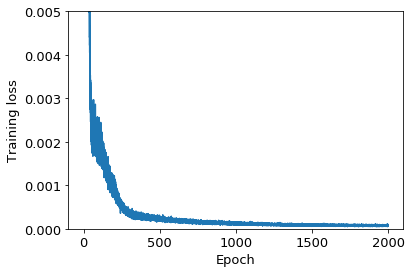

In [49]:
plt.figure()
x = np.arange(0,num_epochs,num_epochs/36000)
plt.plot(x, training_loss)
plt.xlabel('Epoch')
plt.ylabel('Training loss')
plt.ylim([0,0.005])

In [24]:
# torch.save(model, 'ae-nmf_norm_plot.pkl')

In [19]:
model = torch.load('ae-nmf_16_init_3200_allrand_norm.pkl')
# model = torch.load('ae-nmf_norm_plot.pkl')

In [20]:
W = model.decoder[0].weight.detach().numpy()
W.shape

(850, 16)

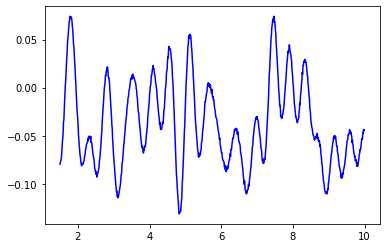

In [21]:
x = np.arange(1.5,10.0,0.01)
plt.plot(x,W[:,4], ls='-', markerfacecolor='none',c='b',label="Anatase")

## Plot decoder weights 

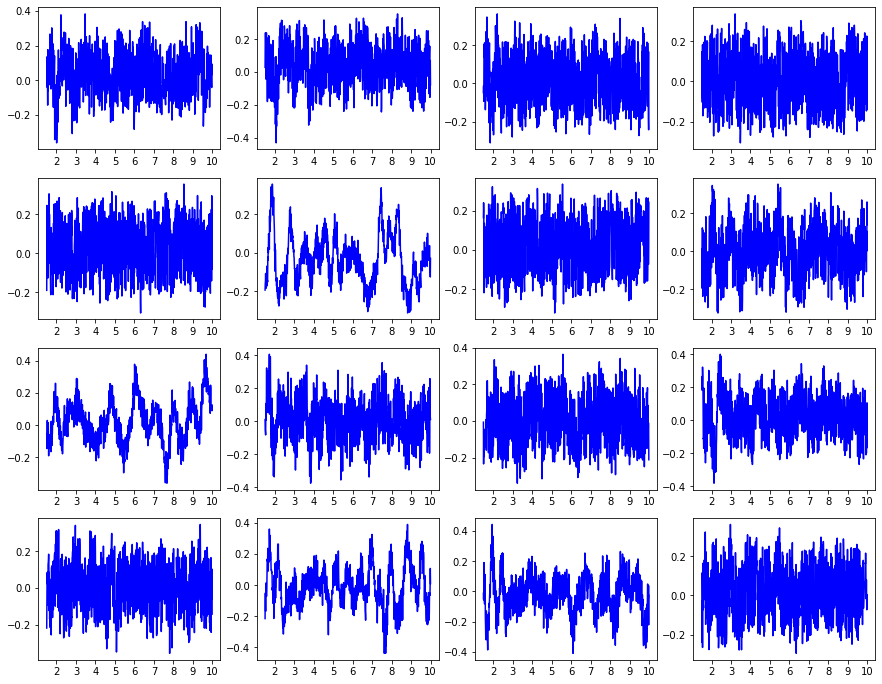

In [16]:
x = np.arange(1.5,10.0,0.01)

n_col = 4
n_row = 4

fig, axs = plt.subplots(ncols=n_col, nrows=n_row, figsize=(15, 12),
                        constrained_layout=False)

for row in range(n_row):
    for col in range(n_col):
#         axs[row, col].set_xticks([])
#         axs[row, col].set_yticks([])
        axs[row, col].plot(x,W[:,row*n_col+col], ls='-', markerfacecolor='none',c='b')
        axs[row, col].xaxis.set_major_locator(MaxNLocator(integer=True))

In [ ]:
torch.set_printoptions(profile="full")
with torch.no_grad():
    encoded,decoded = model(x_train_torch)
    
    #(3.)
    print("Number of neurons with activation > 0.5:\n", (encoded > 0.5).sum(1))
    print((encoded > 0.5).sum(1).shape)
    print(encoded)

In [22]:
latent = 16
H_train = np.zeros(shape=(720*groups,latent))
for i in range(len(x_train_torch)):
#     data = torch.from_numpy(data_nmf[i,:].astype(np.float32))
    Hx, recon_batch = model(x_train_torch[i])
    Hx = Hx.detach().numpy()
    H_train[i,:] = Hx
    
H_test = np.zeros(shape=(80*groups,latent))
for i in range(len(data_test)):
    data_test_torch = torch.from_numpy(data_test[i].astype(np.float32))
    Hx, recon_batch = model(data_test_torch)
    Hx = Hx.detach().numpy()
    H_test[i,:] = Hx

In [ ]:
H_train.shape

In [23]:
std1 = preprocessing.StandardScaler().fit(H_train)
std2 = preprocessing.StandardScaler().fit(y_train)
H_train_std = std1.transform(H_train)
H_test_std = std1.transform(H_test)
y_train_std = std2.transform(y_train)
y_test_std = std2.transform(y_test)

In [24]:
H_train_torch = torch.from_numpy(H_train_std.astype(np.float32))
H_test_torch = torch.from_numpy(H_test_std.astype(np.float32))
y_train_torch = torch.from_numpy(y_train_std.astype(np.float32))
y_test_torch = torch.from_numpy(y_test_std.astype(np.float32))

## Define neural network that maps AE latent space to defect concentration

In [25]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
#         x = (80*torch.sigmoid(self.predict(x)) - torch.from_numpy(std2.mean_.astype(np.float32)))/torch.from_numpy(std2.scale_.astype(np.float32))
        x = (80*F.relu(self.predict(x)) - torch.from_numpy(std2.mean_.astype(np.float32)))/torch.from_numpy(std2.scale_.astype(np.float32))
#         x = self.predict(x)  
        return x
    
net = Net(n_feature=latent, n_hidden=50, n_output=4)
optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
loss_func = torch.nn.MSELoss()


BATCH_SIZE = 100
EPOCH = 1000
thresh = 0.4
strength = 10.0

torch_dataset = Data.TensorDataset(H_train_torch, y_train_torch)

loader = Data.DataLoader(
    dataset=torch_dataset, 
    batch_size=BATCH_SIZE, 
    shuffle=True)

training_loss = []
for epoch in range(EPOCH):
    train_loss = 0
    for step, (batch_x, batch_y) in enumerate(loader): # for each training step
        
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        prediction = net(b_x)     # input x and predict based on x

        loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)

        optimizer.zero_grad()   # clear gradients for next train
        loss.backward()         # backpropagation, compute gradients
        optimizer.step()        # apply gradients
        
        train_loss += loss.item()
        
    training_loss += [train_loss / len(H_train_torch)]

/home/shuyan/anaconda3/lib/python3.7/site-packages/torch/autograd/__init__.py:132: UserWarning: CUDA initialization: Found no NVIDIA driver on your system. Please check that you have an NVIDIA GPU and installed a driver from http://www.nvidia.com/Download/index.aspx (Triggered internally at  /opt/conda/conda-bld/pytorch_1607370128159/work/c10/cuda/CUDAFunctions.cpp:100.)
  allow_unreachable=True)  # allow_unreachable flag


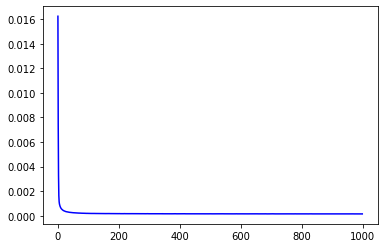

In [26]:
plt.figure()
plt.plot(np.arange(0,EPOCH),training_loss, color='blue', label="training")

In [27]:
y_train_pred_torch = net(H_train_torch)
y_train_pred = y_train_pred_torch.data.numpy()
y_test_pred_torch = net(H_test_torch)
y_test_pred = y_test_pred_torch.data.numpy()
print(y_train_pred.shape)

(2880, 4)


In [28]:
y_train_pred = y_train_pred*std2.scale_+std2.mean_
y_test_pred = y_test_pred*std2.scale_+std2.mean_

<Figure size 432x288 with 0 Axes>

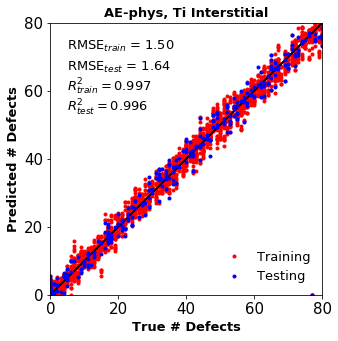

<Figure size 432x288 with 0 Axes>

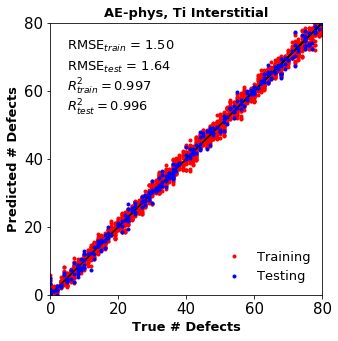

<Figure size 432x288 with 0 Axes>

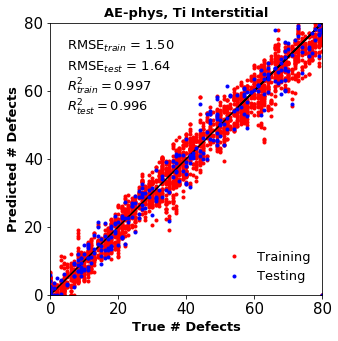

<Figure size 432x288 with 0 Axes>

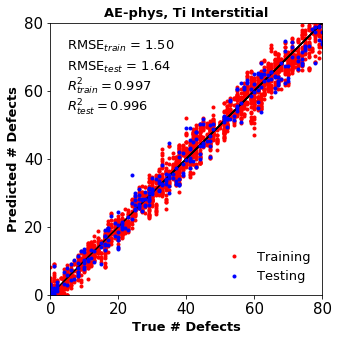

In [36]:
defect = ['Ti vac','Ti inter','O vac','O inter']
for i in range(4):
    matplotlib.rc('font', size=15)
    plt.figure()
    plt.figure(figsize=(5, 5))
    plt.axis('square')
    plt.plot(y_train[:,i], y_train_pred[:,i],'r.',label="Training")
    plt.plot(y_train[:,i], y_train[:,i],'k-')
    plt.plot(y_test[:,i], y_test_pred[:,i],'b.',label="Testing")
    plt.xlim(0,80)
    plt.ylim(0,80)
    plt.xlabel('True # Defects', fontweight='bold',fontsize=13)
    plt.ylabel('Predicted # Defects', fontweight='bold',fontsize=13)
    plt.legend(loc='lower right', frameon=False, prop={'size':13})
    plt.title('AE-phys, Ti Interstitial',fontweight='bold',fontsize=13)
    rmse_train = mean_squared_error(y_train[:,i],y_train_pred[:,i],squared = False)
    rmse_test = mean_squared_error(y_test[:,i],y_test_pred[:,i],squared = False)
    r2_train = r2_score(y_train[:,i],y_train_pred[:,i])
    r2_test = r2_score(y_test[:,i],y_test_pred[:,i])
#     print(y_train_pred[:,i])
#     print(rmse_train)
    
    
#     plt.text(5,75, r'$RMSE_{train} = %f$' % (rmse_train), fontsize=12)
#     plt.text(5,68, r'$RMSE_{test} = %f$' % (rmse_test), fontsize=12)
#     plt.text(5,61, r'$R^2_{train} = %f$' % (r2_train), fontsize=12)
#     plt.text(5,54, r'$R^2_{test} = %f$' % (r2_test), fontsize=12)
    
    plt.text(5,72, 'RMSE$_{train}$ = %.2f' % (1.5), fontsize=13)
    plt.text(5,66, 'RMSE$_{test}$ = %.2f' % (1.643), fontsize=13)
    plt.text(5,60, '$R^2_{train} = %.3f$' % (0.997), fontsize=13)
    plt.text(5,54, '$R^2_{test} = %.3f$' % (0.996), fontsize=13)
    
    plt.yticks([0, 20, 40, 60, 80])

## Test on experiment

In [ ]:
# exp = np.loadtxt('ana.unfit',delimiter=' ', dtype=float)
# exp = np.loadtxt('anatase_20191012-221015_365895.txt',delimiter=' ', dtype=float)
exp = np.loadtxt('160-40-60_Q16.txt',delimiter=' ', dtype=float)

exp = exp[:,1]
exp = (exp-min(exp))/(max(exp)-min(exp))
max(exp)

In [ ]:
exp_test_torch = torch.from_numpy(exp.astype(np.float32))
Hx, recon_batch = model(exp_test_torch)
H_exp = Hx.detach().numpy().reshape(1, -1)
H_exp

In [ ]:
H_exp_std = std1.transform(H_exp)
H_exp_std

In [ ]:
exp_test_torch = torch.from_numpy(H_exp_std.astype(np.float32))
exp_test_torch = torch.squeeze(exp_test_torch)
exp_test_pred_torch = net(exp_test_torch)
exp_test_pred = exp_test_pred_torch.data.numpy()
exp_test_pred = exp_test_pred*std2.scale_+std2.mean_

In [ ]:
exp_test_pred

## Random seeds

In [ ]:
class Net(torch.nn.Module):
    def __init__(self, n_feature, n_hidden, n_hidden2, n_output):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(n_feature, n_hidden)   # hidden layer
#         self.hidden2 = torch.nn.Linear(n_hidden, n_hidden2)
        self.predict = torch.nn.Linear(n_hidden, n_output)   # output layer

    def forward(self, x):
        x = F.relu(self.hidden(x))      # activation function for hidden layer
#         x = F.relu(self.hidden2(x)) 
        x = (80*torch.sigmoid(self.predict(x)) - torch.from_numpy(std2.mean_.astype(np.float32)))/torch.from_numpy(std2.scale_.astype(np.float32))
#         x = (80*F.relu(self.predict(x)) - torch.from_numpy(std2.mean_.astype(np.float32)))/torch.from_numpy(std2.scale_.astype(np.float32))
        #         x = self.predict(x)  
        return x

def my_loss(output, target):
    loss = torch.mean((output - target)**2)
    return loss

In [ ]:
exp = np.loadtxt('160-40-60_Q16.txt',delimiter=' ', dtype=float)
exp = exp[:,1]
exp = (exp-min(exp))/(max(exp)-min(exp))

exp_test_torch = torch.from_numpy(exp.astype(np.float32))
Hx, recon_batch = model(exp_test_torch)
H_exp = Hx.detach().numpy().reshape(1, -1)
H_exp_std = std1.transform(H_exp)
exp_test_torch = torch.from_numpy(H_exp_std.astype(np.float32))
exp_test_torch = torch.squeeze(exp_test_torch)

exp2 = np.loadtxt('anatase_20191012-221015_365895.txt',delimiter=' ', dtype=float)
# exp2 = np.loadtxt('ana.unfit',delimiter=' ', dtype=float)
exp2 = exp2[:,1]
exp2 = (exp2-min(exp2))/(max(exp2)-min(exp2))

exp2_test_torch = torch.from_numpy(exp2.astype(np.float32))
Hx2, recon_batch2 = model(exp2_test_torch)
H2_exp = Hx2.detach().numpy().reshape(1, -1)
H2_exp_std = std1.transform(H2_exp)
exp2_test_torch = torch.from_numpy(H2_exp_std.astype(np.float32))
exp2_test_torch = torch.squeeze(exp2_test_torch)

In [ ]:
exp_preds = np.empty((0,4))
exp2_preds = np.empty((0,4))
for i in range(10):
    net = Net(n_feature=latent, n_hidden=50, n_hidden2=50, n_output=4)
    optimizer = torch.optim.Adam(net.parameters(), lr=0.001, weight_decay=0.001)
    loss_func = torch.nn.MSELoss()

    BATCH_SIZE = 100
    EPOCH = 600

    torch_dataset = Data.TensorDataset(H_train_torch, y_train_torch)

    loader = Data.DataLoader(
        dataset=torch_dataset, 
        batch_size=BATCH_SIZE, 
        shuffle=True)

    training_loss = []
    for epoch in range(EPOCH):
        train_loss = 0
        for step, (batch_x, batch_y) in enumerate(loader): # for each training step

            b_x = Variable(batch_x)
            b_y = Variable(batch_y)

            prediction = net(b_x)     # input x and predict based on x

            loss = loss_func(prediction, b_y)     # must be (1. nn output, 2. target)

            optimizer.zero_grad()   # clear gradients for next train
            loss.backward()         # backpropagation, compute gradients
            optimizer.step()        # apply gradients

            train_loss += loss.item()

        training_loss += [train_loss / len(x_train_torch)]
    
    exp_test_pred_torch = net(exp_test_torch)
    exp_test_pred = exp_test_pred_torch.data.numpy()
    exp_test_pred = exp_test_pred*std2.scale_+std2.mean_
    
    exp2_test_pred_torch = net(exp2_test_torch)
    exp2_test_pred = exp2_test_pred_torch.data.numpy()
    exp2_test_pred = exp2_test_pred*std2.scale_+std2.mean_
    
    exp_preds = np.append(exp_preds, exp_test_pred.reshape([1,4]), axis=0)
    exp2_preds = np.append(exp2_preds, exp2_test_pred.reshape([1,4]), axis=0)
    print(i)

In [ ]:
data1 = exp_preds[:,0]
data2 = exp_preds[:,1]
data3 = exp_preds[:,2]
data4 = exp_preds[:,3]
data = [data1, data2, data3, data4]

In [ ]:
plt.figure()
plt.boxplot(data)
plt.xticks([1, 2, 3, 4], ['Ti vac', 'Ti inter', 'O vac','O inter'])
plt.ylabel('Number of defects')

mean = [54.28571429,34.28571429,0.714285714,8.571428571]
c = [5.345224838,5.345224838,1.889822365,6.267831705]
# mean = [0,0,0,0]
# c = [0, 0, 0, 0]
plt.errorbar([1, 2, 3, 4], mean, yerr=c, fmt="o",capsize=6)
# plt.title('Prediction on perfect anatase')

In [ ]:
data1 = exp2_preds[:,0]
data2 = exp2_preds[:,1]
data3 = exp2_preds[:,2]
data4 = exp2_preds[:,3]
data = [data1, data2, data3, data4]

In [ ]:
plt.figure()
plt.boxplot(data)
plt.xticks([1, 2, 3, 4], ['Ti vac', 'Ti inter', 'O vac','O inter'])
plt.ylabel('Number of defects')

# mean = [54.28571429,34.28571429,0.714285714,8.571428571]
# c = [5.345224838,5.345224838,1.889822365,6.267831705]
mean = [0,0,0,0]
c = [0, 0, 0, 0]
plt.errorbar([1, 2, 3, 4], mean, yerr=c, fmt="o")
plt.ylim([-5,85])
# plt.title('Prediction on perfect anatase')

In [ ]:
# np.savetxt("ae-nmf_16_sig_3200_allrand_def.txt", exp_preds)

In [ ]:
# np.savetxt("ae-nmf_16_sig_3200_allrand_per.txt", exp2_preds)

In [ ]:
result_def = np.loadtxt('ae-nmf_16_sig_3200_allrand_def.txt',delimiter=' ', dtype=float)
result_per = np.loadtxt('ae-nmf_16_sig_3200_allrand_per.txt',delimiter=' ', dtype=float)

In [ ]:
matplotlib.rc('font', size=15)
plt.figure()
plt.boxplot(result_def)
plt.xticks([1, 2, 3, 4], ['Ti vac', 'Ti inter', 'O vac','O inter'])
plt.ylabel('Number of defects')
plt.ylim([-5,85])
# plt.title('Prediction on perfect anatase')

mean = [54.28571429,34.28571429,0.714285714,8.571428571]
c = [5.345224838,5.345224838,1.889822365,6.267831705]
plt.errorbar([1, 2, 3, 4], mean, yerr=c, fmt="o",capsize = 6)

In [ ]:
plt.figure()
plt.boxplot(result_per)
plt.xticks([1, 2, 3, 4], ['Ti vac', 'Ti inter', 'O vac','O inter'])
plt.ylabel('Number of defects')
# plt.title('Prediction on perfect anatase')

mean = [0,0,0,0]
c = [0, 0, 0, 0]
plt.ylim([-5,85])
plt.errorbar([1, 2, 3, 4], mean, yerr=c, fmt="o",capsize = 6)

In [ ]:
np.mean(result_per,axis=0)

In [ ]:
np.std(result_per,axis=0)